# TESS Atlas fit for TOI 439

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 439.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-439.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-439.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-439.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 439

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 439 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

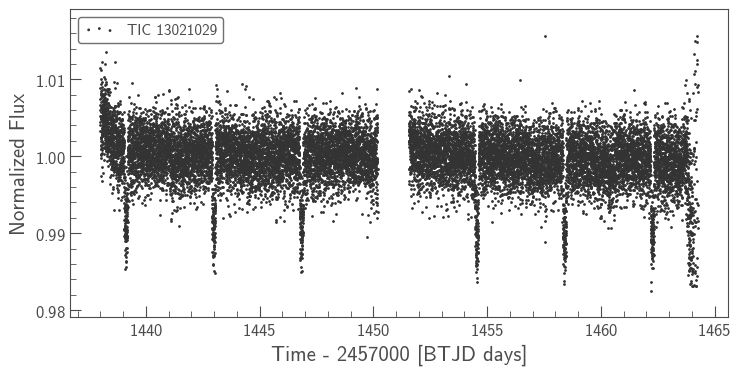

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -53793.9192302454 -> -53757.87808868209


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -43569.91842806595 -> -42858.09392405599


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -42858.09392405599 -> -42680.41014920027


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -42680.41014920027 -> -42680.41007678673


optimizing logp for variables: ['mean', 't0', 'logP']


message: Optimization terminated successfully.
logp: -42680.41007678673 -> -42677.4394724938


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -42677.4394724938 -> -42677.43680700709


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -42677.43680700709 -> -42667.63623935399


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -42667.63623935399 -> -42667.63623935399


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -42667.63623935399 -> -42667.636239353946


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -42667.636239353946 -> -42667.63623935394


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -42667.63623935394 -> -42667.63623935394


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -42667.63623935394 -> -42667.63623935394


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -42667.63623935394 -> -42667.63623935394


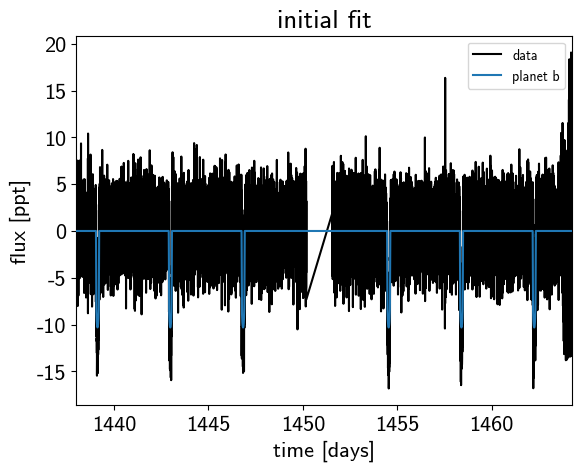

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:06, 15.53draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:11,  8.25draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:14,  6.23draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:16,  5.34draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:18,  4.75draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:19,  4.28draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:20,  3.98draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:20,  3.91draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:04<00:16,  4.75draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:04<00:22,  3.55draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:21,  3.52draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:05<00:17,  4.28draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:22,  3.38draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:06<00:18,  4.08draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:06<00:21,  3.38draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:06<00:18,  3.93draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:07<00:21,  3.37draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:07<00:17,  4.05draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:07<00:20,  3.35draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:07<00:16,  4.15draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:08<00:20,  3.29draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:08<00:16,  3.98draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:08<00:19,  3.38draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:08<00:18,  3.53draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:09<00:17,  3.62draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:09<00:18,  3.37draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:09<00:17,  3.51draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:10<00:16,  3.55draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:10<00:15,  3.70draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:10<00:15,  3.74draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:10<00:14,  3.84draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:11<00:14,  3.77draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:11<00:13,  3.97draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:11<00:13,  3.97draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:12<00:13,  3.98draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:12<00:12,  3.98draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:13<00:10,  4.43draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:13<00:10,  4.28draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:14<00:10,  4.18draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:14<00:08,  4.96draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:14<00:10,  3.89draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:14<00:08,  4.60draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:15<00:10,  3.79draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:15<00:08,  4.40draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:15<00:09,  3.77draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:15<00:08,  4.29draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:16<00:09,  3.75draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:16<00:08,  4.24draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:16<00:08,  3.77draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:16<00:07,  4.17draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:17<00:08,  3.80draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:17<00:07,  4.13draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:17<00:07,  3.83draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:17<00:06,  4.08draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:18<00:06,  3.87draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:18<00:06,  4.03draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:18<00:06,  3.90draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:18<00:06,  3.99draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:19<00:05,  3.90draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:19<00:05,  3.97draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:19<00:05,  3.84draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:19<00:05,  3.98draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:20<00:04,  3.85draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:20<00:04,  3.98draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:20<00:04,  3.90draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:20<00:04,  3.98draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:21<00:03,  3.93draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:21<00:03,  3.98draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:21<00:03,  3.96draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:21<00:03,  3.96draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:22<00:02,  3.98draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:22<00:02,  3.93draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:22<00:02,  4.01draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:22<00:02,  3.89draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:23<00:01,  4.02draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:23<00:01,  3.71draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:23<00:01,  3.80draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:24<00:01,  3.60draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:24<00:00,  3.88draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:24<00:00,  3.51draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:26<00:00,  1.52draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:26<00:00,  1.65draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:05, 16.14draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:11,  7.59draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:01<00:15,  5.69draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:18,  4.71draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:02<00:16,  5.19draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:23,  3.67draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:21,  3.96draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:24,  3.42draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:03<00:22,  3.72draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:26,  3.08draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:04<00:23,  3.40draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:04<00:27,  2.92draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:23,  3.31draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:26,  2.93draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:05<00:25,  2.95draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:23,  3.21draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:06<00:22,  3.23draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:06<00:21,  3.34draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:07<00:21,  3.37draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:07<00:20,  3.43draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:07<00:23,  3.03draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:07<00:19,  3.59draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:08<00:23,  2.95draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:08<00:17,  3.85draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:09<00:16,  3.95draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:09<00:16,  3.77draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:09<00:16,  3.80draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:09<00:18,  3.21draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:10<00:17,  3.49draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:10<00:17,  3.32draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:10<00:17,  3.35draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:11<00:17,  3.35draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:11<00:16,  3.33draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:11<00:16,  3.37draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:12<00:15,  3.45draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:12<00:16,  3.25draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:12<00:14,  3.66draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:12<00:12,  3.90draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:13<00:12,  4.04draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:13<00:13,  3.55draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:13<00:12,  3.64draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:14<00:15,  3.00draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:14<00:13,  3.35draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:14<00:14,  3.02draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:15<00:12,  3.48draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:15<00:10,  3.97draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:15<00:10,  3.99draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:16<00:10,  3.65draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:16<00:10,  3.76draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:16<00:11,  3.26draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:16<00:09,  3.67draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:17<00:11,  3.14draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:17<00:10,  3.35draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:17<00:10,  3.07draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:18<00:10,  3.16draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:18<00:09,  3.39draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:19<00:11,  2.71draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:19<00:09,  2.94draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:20<00:08,  3.00draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:20<00:07,  3.13draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:20<00:06,  3.77draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:21<00:06,  3.32draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:21<00:05,  3.98draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:21<00:05,  3.43draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:21<00:04,  4.07draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:22<00:05,  3.42draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:22<00:04,  3.75draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:22<00:04,  3.36draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:23<00:03,  3.95draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:23<00:02,  4.51draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:23<00:02,  4.05draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:24<00:02,  3.98draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:24<00:02,  3.74draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:24<00:02,  3.78draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:25<00:01,  4.13draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:25<00:01,  4.28draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:25<00:01,  3.89draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:26<00:00,  3.69draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:27<00:00,  1.80draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:28<00:00,  1.49draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<02:00,  1.68draws/s]

Sampling 2 chains:   1%|          | 2/204 [00:00<01:36,  2.09draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:01<01:15,  2.66draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<01:12,  2.74draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:01<01:18,  2.51draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:02<01:02,  3.13draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:02<01:24,  2.32draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:03<01:18,  2.48draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:03<01:02,  3.11draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:04<01:14,  2.59draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:04<01:12,  2.64draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:04<01:18,  2.42draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:05<01:12,  2.61draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:05<01:07,  2.77draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:06<01:16,  2.43draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:06<01:08,  2.69draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:06<00:56,  3.25draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:07<00:52,  3.45draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:07<01:08,  2.65draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:08<00:55,  3.24draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:08<00:44,  3.98draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:08<00:40,  4.33draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:08<00:41,  4.28draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:08<00:46,  3.73draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:09<00:50,  3.43draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:09<00:52,  3.27draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:09<00:40,  4.26draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:09<00:37,  4.59draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:10<00:30,  5.47draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:10<00:51,  3.26draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:11<00:53,  3.13draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:11<00:41,  3.97draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:11<00:35,  4.62draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:12<00:39,  4.05draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:12<00:45,  3.52draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:12<00:45,  3.54draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:13<00:49,  3.18draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:14<00:50,  3.08draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:14<00:45,  3.37draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:14<00:33,  4.50draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:15<00:37,  4.03draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:15<00:41,  3.54draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:16<00:47,  3.09draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:16<00:38,  3.75draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:16<00:38,  3.74draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:16<00:43,  3.35draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:17<00:41,  3.48draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:17<00:47,  2.98draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:17<00:38,  3.62draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:18<00:52,  2.69draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:18<00:47,  2.91draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:19<00:48,  2.81draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:19<00:41,  3.28draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:19<00:48,  2.78draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:20<00:46,  2.88draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:20<00:45,  2.94draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:21<00:43,  3.02draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:21<00:37,  3.47draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:21<00:47,  2.71draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:22<00:40,  3.16draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:22<00:35,  3.59draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:22<00:31,  3.94draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:23<00:35,  3.53draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:23<00:35,  3.42draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:23<00:38,  3.20draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:24<00:45,  2.64draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:24<00:36,  3.32draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:24<00:36,  3.25draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:25<00:38,  3.10draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:25<00:40,  2.87draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:25<00:40,  2.89draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:26<00:37,  3.07draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:26<00:36,  3.12draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:26<00:38,  2.96draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:27<00:42,  2.61draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:27<00:36,  2.99draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:28<00:29,  3.64draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:28<00:39,  2.68draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:28<00:30,  3.43draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:29<00:31,  3.34draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:29<00:27,  3.79draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:29<00:28,  3.53draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:29<00:24,  4.08draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:30<00:24,  3.95draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:30<00:23,  4.11draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:31<00:32,  2.96draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:31<00:31,  2.97draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:32<00:24,  3.72draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:32<00:31,  2.85draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:32<00:23,  3.72draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:33<00:30,  2.88draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:34<00:29,  2.95draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:34<00:24,  3.48draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:34<00:22,  3.74draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:34<00:22,  3.75draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:34<00:19,  4.24draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:35<00:22,  3.68draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:35<00:22,  3.49draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:35<00:25,  3.07draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:36<00:22,  3.36draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:36<00:24,  3.12draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:37<00:25,  2.95draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:37<00:19,  3.72draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:37<00:29,  2.50draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:38<00:27,  2.57draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:38<00:21,  3.27draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:39<00:19,  3.42draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:39<00:18,  3.58draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:39<00:15,  4.21draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:40<00:16,  3.94draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:40<00:20,  3.01draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:40<00:14,  4.00draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:40<00:12,  4.74draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:41<00:10,  5.52draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:41<00:08,  6.25draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:41<00:09,  5.86draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:41<00:08,  6.11draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:41<00:09,  5.54draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:42<00:11,  4.30draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:42<00:08,  5.39draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:43<00:12,  3.62draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:43<00:11,  3.88draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:43<00:10,  4.49draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:44<00:12,  3.60draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:44<00:10,  4.29draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:44<00:12,  3.37draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:44<00:11,  3.50draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [00:45<00:11,  3.48draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:45<00:09,  4.16draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:46<00:12,  3.05draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:46<00:11,  3.01draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:46<00:09,  3.51draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:47<00:10,  3.25draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [00:47<00:08,  3.65draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [00:47<00:09,  3.19draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:48<00:09,  3.28draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:48<00:08,  3.34draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [00:48<00:07,  3.68draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [00:49<00:05,  4.44draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:49<00:06,  4.07draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:49<00:04,  5.23draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [00:49<00:04,  5.02draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [00:50<00:04,  4.88draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:50<00:03,  5.96draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:50<00:05,  3.19draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [00:51<00:05,  3.06draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:51<00:04,  3.06draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:52<00:05,  2.34draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:52<00:06,  2.02draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:53<00:04,  2.42draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [00:53<00:05,  2.06draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:54<00:05,  1.85draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:54<00:04,  2.10draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:55<00:02,  2.54draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:55<00:02,  2.27draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:56<00:02,  1.91draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:57<00:02,  1.74draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:57<00:01,  1.64draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [00:58<00:01,  1.54draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:59<00:00,  1.46draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [01:02<00:00,  1.30s/draws]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:07, 56.10draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:00<00:07, 49.74draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:00<00:08, 44.89draws/s]

Sampling 2 chains:   4%|▍         | 18/404 [00:00<00:09, 38.86draws/s]

Sampling 2 chains:   6%|▌         | 23/404 [00:00<00:09, 39.64draws/s]

Sampling 2 chains:   7%|▋         | 27/404 [00:00<00:13, 28.65draws/s]

Sampling 2 chains:   7%|▋         | 30/404 [00:00<00:14, 25.35draws/s]

Sampling 2 chains:   8%|▊         | 33/404 [00:01<00:17, 21.09draws/s]

Sampling 2 chains:   9%|▉         | 36/404 [00:01<00:17, 21.20draws/s]

Sampling 2 chains:  10%|▉         | 39/404 [00:01<00:17, 21.44draws/s]

Sampling 2 chains:  11%|█         | 43/404 [00:01<00:14, 24.43draws/s]

Sampling 2 chains:  11%|█▏        | 46/404 [00:01<00:14, 24.02draws/s]

Sampling 2 chains:  12%|█▏        | 50/404 [00:01<00:13, 27.06draws/s]

Sampling 2 chains:  13%|█▎        | 53/404 [00:01<00:12, 27.04draws/s]

Sampling 2 chains:  14%|█▍        | 56/404 [00:02<00:14, 24.01draws/s]

Sampling 2 chains:  15%|█▍        | 59/404 [00:02<00:18, 18.78draws/s]

Sampling 2 chains:  16%|█▌        | 63/404 [00:02<00:18, 18.79draws/s]

Sampling 2 chains:  16%|█▋        | 66/404 [00:02<00:18, 18.10draws/s]

Sampling 2 chains:  17%|█▋        | 68/404 [00:02<00:18, 17.95draws/s]

Sampling 2 chains:  18%|█▊        | 71/404 [00:02<00:17, 18.79draws/s]

Sampling 2 chains:  19%|█▊        | 75/404 [00:03<00:16, 20.39draws/s]

Sampling 2 chains:  19%|█▉        | 78/404 [00:03<00:14, 21.95draws/s]

Sampling 2 chains:  21%|██        | 83/404 [00:03<00:12, 26.01draws/s]

Sampling 2 chains:  22%|██▏       | 89/404 [00:03<00:10, 31.00draws/s]

Sampling 2 chains:  23%|██▎       | 93/404 [00:03<00:13, 23.16draws/s]

Sampling 2 chains:  24%|██▍       | 97/404 [00:03<00:12, 23.65draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:03<00:13, 23.11draws/s]

Sampling 2 chains:  26%|██▌       | 104/404 [00:04<00:11, 26.45draws/s]

Sampling 2 chains:  27%|██▋       | 108/404 [00:04<00:10, 28.31draws/s]

Sampling 2 chains:  28%|██▊       | 112/404 [00:04<00:10, 27.70draws/s]

Sampling 2 chains:  29%|██▊       | 116/404 [00:04<00:09, 29.54draws/s]

Sampling 2 chains:  30%|██▉       | 120/404 [00:04<00:08, 31.77draws/s]

Sampling 2 chains:  31%|███       | 124/404 [00:04<00:08, 33.63draws/s]

Sampling 2 chains:  32%|███▏      | 129/404 [00:04<00:07, 36.79draws/s]

Sampling 2 chains:  33%|███▎      | 133/404 [00:04<00:07, 33.89draws/s]

Sampling 2 chains:  34%|███▍      | 137/404 [00:05<00:08, 32.34draws/s]

Sampling 2 chains:  35%|███▌      | 142/404 [00:05<00:07, 34.15draws/s]

Sampling 2 chains:  36%|███▌      | 146/404 [00:05<00:07, 33.86draws/s]

Sampling 2 chains:  37%|███▋      | 150/404 [00:05<00:07, 32.25draws/s]

Sampling 2 chains:  38%|███▊      | 154/404 [00:05<00:07, 32.49draws/s]

Sampling 2 chains:  40%|███▉      | 160/404 [00:05<00:06, 37.47draws/s]

Sampling 2 chains:  41%|████      | 165/404 [00:05<00:07, 34.10draws/s]

Sampling 2 chains:  42%|████▏     | 171/404 [00:05<00:05, 39.03draws/s]

Sampling 2 chains:  44%|████▎     | 176/404 [00:06<00:06, 34.16draws/s]

Sampling 2 chains:  45%|████▍     | 180/404 [00:06<00:09, 24.36draws/s]

Sampling 2 chains:  46%|████▌     | 184/404 [00:06<00:11, 18.44draws/s]

Sampling 2 chains:  46%|████▋     | 187/404 [00:06<00:12, 17.85draws/s]

Sampling 2 chains:  47%|████▋     | 190/404 [00:07<00:11, 18.23draws/s]

Sampling 2 chains:  48%|████▊     | 193/404 [00:07<00:10, 20.41draws/s]

Sampling 2 chains:  49%|████▊     | 196/404 [00:07<00:10, 20.11draws/s]

Sampling 2 chains:  49%|████▉     | 199/404 [00:07<00:10, 20.19draws/s]

Sampling 2 chains:  50%|█████     | 203/404 [00:07<00:09, 21.92draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:07<00:07, 24.72draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:07<00:06, 28.06draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:08<00:06, 28.90draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:08<00:08, 22.59draws/s]

Sampling 2 chains:  55%|█████▌    | 224/404 [00:08<00:07, 22.50draws/s]

Sampling 2 chains:  56%|█████▌    | 227/404 [00:08<00:07, 22.39draws/s]

Sampling 2 chains:  57%|█████▋    | 230/404 [00:08<00:07, 22.50draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [00:09<00:11, 14.86draws/s]

Sampling 2 chains:  58%|█████▊    | 235/404 [00:09<00:10, 15.84draws/s]

Sampling 2 chains:  59%|█████▊    | 237/404 [00:09<00:10, 16.52draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:09<00:08, 18.39draws/s]

Sampling 2 chains:  60%|██████    | 244/404 [00:09<00:07, 21.73draws/s]

Sampling 2 chains:  61%|██████    | 247/404 [00:09<00:06, 23.08draws/s]

Sampling 2 chains:  62%|██████▏   | 250/404 [00:09<00:06, 23.27draws/s]

Sampling 2 chains:  63%|██████▎   | 253/404 [00:09<00:06, 22.19draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [00:10<00:06, 24.10draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [00:10<00:05, 26.17draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [00:10<00:05, 26.77draws/s]

Sampling 2 chains:  67%|██████▋   | 269/404 [00:10<00:06, 21.76draws/s]

Sampling 2 chains:  67%|██████▋   | 272/404 [00:10<00:05, 23.40draws/s]

Sampling 2 chains:  68%|██████▊   | 275/404 [00:10<00:05, 23.79draws/s]

Sampling 2 chains:  69%|██████▉   | 278/404 [00:10<00:05, 22.54draws/s]

Sampling 2 chains:  70%|██████▉   | 282/404 [00:11<00:05, 24.24draws/s]

Sampling 2 chains:  71%|███████   | 287/404 [00:11<00:04, 27.95draws/s]

Sampling 2 chains:  72%|███████▏  | 291/404 [00:11<00:03, 30.24draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [00:11<00:03, 31.39draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [00:11<00:03, 32.69draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [00:11<00:03, 31.38draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [00:11<00:03, 25.96draws/s]

Sampling 2 chains:  77%|███████▋  | 310/404 [00:11<00:03, 26.12draws/s]

Sampling 2 chains:  77%|███████▋  | 313/404 [00:12<00:03, 26.11draws/s]

Sampling 2 chains:  78%|███████▊  | 316/404 [00:12<00:03, 27.01draws/s]

Sampling 2 chains:  79%|███████▉  | 319/404 [00:12<00:03, 23.40draws/s]

Sampling 2 chains:  80%|███████▉  | 322/404 [00:12<00:03, 23.12draws/s]

Sampling 2 chains:  81%|████████  | 326/404 [00:12<00:03, 25.01draws/s]

Sampling 2 chains:  82%|████████▏ | 331/404 [00:12<00:02, 28.83draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [00:12<00:02, 29.89draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [00:13<00:02, 28.28draws/s]

Sampling 2 chains:  85%|████████▍ | 343/404 [00:13<00:03, 19.66draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [00:13<00:02, 19.35draws/s]

Sampling 2 chains:  86%|████████▋ | 349/404 [00:13<00:02, 21.08draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:13<00:02, 20.12draws/s]

Sampling 2 chains:  88%|████████▊ | 355/404 [00:13<00:02, 21.32draws/s]

Sampling 2 chains:  89%|████████▊ | 358/404 [00:13<00:02, 21.77draws/s]

Sampling 2 chains:  89%|████████▉ | 361/404 [00:14<00:01, 22.85draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [00:14<00:02, 18.16draws/s]

Sampling 2 chains:  91%|█████████ | 367/404 [00:14<00:02, 18.41draws/s]

Sampling 2 chains:  92%|█████████▏| 370/404 [00:14<00:01, 19.79draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [00:14<00:01, 20.70draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [00:14<00:01, 17.10draws/s]

Sampling 2 chains:  94%|█████████▎| 378/404 [00:15<00:01, 16.66draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [00:15<00:01, 15.37draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [00:15<00:01, 15.86draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [00:15<00:01, 17.10draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:15<00:00, 19.23draws/s]

Sampling 2 chains:  97%|█████████▋| 391/404 [00:15<00:00, 18.81draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [00:15<00:00, 19.56draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [00:16<00:00, 21.56draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [00:16<00:00, 21.45draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [00:16<00:00, 22.53draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:16<00:00, 24.66draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 6/804 [00:00<00:15, 50.38draws/s]

Sampling 2 chains:   1%|▏         | 11/804 [00:00<00:15, 50.13draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:00<00:22, 34.95draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:00<00:30, 25.90draws/s]

Sampling 2 chains:   3%|▎         | 23/804 [00:00<00:32, 24.11draws/s]

Sampling 2 chains:   3%|▎         | 26/804 [00:00<00:31, 25.00draws/s]

Sampling 2 chains:   4%|▎         | 29/804 [00:01<00:41, 18.73draws/s]

Sampling 2 chains:   4%|▍         | 32/804 [00:01<00:37, 20.76draws/s]

Sampling 2 chains:   4%|▍         | 36/804 [00:01<00:32, 23.66draws/s]

Sampling 2 chains:   5%|▍         | 40/804 [00:01<00:35, 21.64draws/s]

Sampling 2 chains:   6%|▌         | 45/804 [00:01<00:31, 24.37draws/s]

Sampling 2 chains:   6%|▌         | 50/804 [00:01<00:28, 26.07draws/s]

Sampling 2 chains:   7%|▋         | 53/804 [00:02<00:27, 27.08draws/s]

Sampling 2 chains:   7%|▋         | 58/804 [00:02<00:28, 26.37draws/s]

Sampling 2 chains:   8%|▊         | 61/804 [00:02<00:40, 18.49draws/s]

Sampling 2 chains:   8%|▊         | 64/804 [00:02<00:47, 15.54draws/s]

Sampling 2 chains:   8%|▊         | 68/804 [00:02<00:40, 18.13draws/s]

Sampling 2 chains:   9%|▉         | 71/804 [00:03<00:38, 19.00draws/s]

Sampling 2 chains:   9%|▉         | 75/804 [00:03<00:34, 20.97draws/s]

Sampling 2 chains:  10%|▉         | 78/804 [00:03<00:32, 22.59draws/s]

Sampling 2 chains:  10%|█         | 81/804 [00:03<00:31, 23.07draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:03<00:29, 24.26draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:03<00:27, 25.66draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:03<00:24, 28.68draws/s]

Sampling 2 chains:  12%|█▏        | 95/804 [00:03<00:23, 29.76draws/s]

Sampling 2 chains:  12%|█▏        | 100/804 [00:04<00:23, 30.31draws/s]

Sampling 2 chains:  13%|█▎        | 104/804 [00:04<00:26, 26.50draws/s]

Sampling 2 chains:  14%|█▎        | 110/804 [00:04<00:23, 29.94draws/s]

Sampling 2 chains:  14%|█▍        | 115/804 [00:04<00:21, 31.83draws/s]

Sampling 2 chains:  15%|█▍        | 120/804 [00:04<00:19, 35.21draws/s]

Sampling 2 chains:  16%|█▌        | 125/804 [00:04<00:17, 37.99draws/s]

Sampling 2 chains:  16%|█▌        | 130/804 [00:04<00:17, 38.28draws/s]

Sampling 2 chains:  17%|█▋        | 135/804 [00:04<00:17, 38.23draws/s]

Sampling 2 chains:  17%|█▋        | 139/804 [00:05<00:23, 28.09draws/s]

Sampling 2 chains:  18%|█▊        | 143/804 [00:05<00:25, 26.38draws/s]

Sampling 2 chains:  18%|█▊        | 147/804 [00:05<00:23, 28.50draws/s]

Sampling 2 chains:  19%|█▉        | 151/804 [00:05<00:24, 26.85draws/s]

Sampling 2 chains:  19%|█▉        | 156/804 [00:05<00:21, 29.63draws/s]

Sampling 2 chains:  20%|██        | 161/804 [00:05<00:19, 32.32draws/s]

Sampling 2 chains:  21%|██        | 165/804 [00:06<00:19, 32.79draws/s]

Sampling 2 chains:  21%|██        | 169/804 [00:06<00:19, 32.84draws/s]

Sampling 2 chains:  22%|██▏       | 173/804 [00:06<00:21, 28.81draws/s]

Sampling 2 chains:  22%|██▏       | 177/804 [00:06<00:26, 23.82draws/s]

Sampling 2 chains:  22%|██▏       | 180/804 [00:06<00:28, 21.57draws/s]

Sampling 2 chains:  23%|██▎       | 183/804 [00:06<00:28, 21.44draws/s]

Sampling 2 chains:  23%|██▎       | 187/804 [00:06<00:25, 24.50draws/s]

Sampling 2 chains:  24%|██▎       | 190/804 [00:07<00:25, 24.22draws/s]

Sampling 2 chains:  24%|██▍       | 195/804 [00:07<00:21, 28.28draws/s]

Sampling 2 chains:  25%|██▍       | 199/804 [00:07<00:21, 28.11draws/s]

Sampling 2 chains:  25%|██▌       | 203/804 [00:07<00:23, 25.50draws/s]

Sampling 2 chains:  26%|██▌       | 206/804 [00:07<00:29, 20.06draws/s]

Sampling 2 chains:  26%|██▌       | 209/804 [00:07<00:29, 20.46draws/s]

Sampling 2 chains:  26%|██▋       | 213/804 [00:08<00:26, 22.33draws/s]

Sampling 2 chains:  27%|██▋       | 216/804 [00:08<00:26, 21.90draws/s]

Sampling 2 chains:  27%|██▋       | 219/804 [00:08<00:28, 20.49draws/s]

Sampling 2 chains:  28%|██▊       | 223/804 [00:08<00:24, 23.94draws/s]

Sampling 2 chains:  28%|██▊       | 228/804 [00:08<00:21, 26.86draws/s]

Sampling 2 chains:  29%|██▉       | 232/804 [00:08<00:19, 29.08draws/s]

Sampling 2 chains:  30%|██▉       | 238/804 [00:08<00:17, 33.14draws/s]

Sampling 2 chains:  30%|███       | 242/804 [00:08<00:16, 33.35draws/s]

Sampling 2 chains:  31%|███       | 247/804 [00:09<00:15, 35.83draws/s]

Sampling 2 chains:  31%|███       | 251/804 [00:09<00:20, 26.96draws/s]

Sampling 2 chains:  32%|███▏      | 255/804 [00:09<00:18, 29.69draws/s]

Sampling 2 chains:  32%|███▏      | 259/804 [00:09<00:17, 32.00draws/s]

Sampling 2 chains:  33%|███▎      | 263/804 [00:09<00:16, 32.53draws/s]

Sampling 2 chains:  33%|███▎      | 268/804 [00:09<00:15, 35.66draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [00:09<00:15, 34.11draws/s]

Sampling 2 chains:  34%|███▍      | 276/804 [00:09<00:15, 35.17draws/s]

Sampling 2 chains:  35%|███▍      | 280/804 [00:10<00:14, 36.01draws/s]

Sampling 2 chains:  35%|███▌      | 284/804 [00:10<00:14, 35.35draws/s]

Sampling 2 chains:  36%|███▌      | 289/804 [00:10<00:14, 36.64draws/s]

Sampling 2 chains:  37%|███▋      | 294/804 [00:10<00:12, 39.44draws/s]

Sampling 2 chains:  37%|███▋      | 299/804 [00:10<00:14, 35.30draws/s]

Sampling 2 chains:  38%|███▊      | 303/804 [00:10<00:14, 34.68draws/s]

Sampling 2 chains:  38%|███▊      | 307/804 [00:10<00:14, 34.23draws/s]

Sampling 2 chains:  39%|███▊      | 311/804 [00:10<00:13, 35.30draws/s]

Sampling 2 chains:  39%|███▉      | 315/804 [00:11<00:14, 32.75draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [00:11<00:13, 35.04draws/s]

Sampling 2 chains:  40%|████      | 324/804 [00:11<00:13, 34.99draws/s]

Sampling 2 chains:  41%|████      | 328/804 [00:11<00:15, 31.54draws/s]

Sampling 2 chains:  41%|████▏     | 332/804 [00:11<00:15, 31.07draws/s]

Sampling 2 chains:  42%|████▏     | 337/804 [00:11<00:14, 32.79draws/s]

Sampling 2 chains:  43%|████▎     | 342/804 [00:11<00:13, 35.52draws/s]

Sampling 2 chains:  43%|████▎     | 346/804 [00:11<00:12, 35.37draws/s]

Sampling 2 chains:  44%|████▍     | 352/804 [00:12<00:12, 35.94draws/s]

Sampling 2 chains:  44%|████▍     | 356/804 [00:12<00:13, 33.12draws/s]

Sampling 2 chains:  45%|████▍     | 361/804 [00:12<00:12, 35.50draws/s]

Sampling 2 chains:  46%|████▌     | 366/804 [00:12<00:11, 36.60draws/s]

Sampling 2 chains:  46%|████▌     | 370/804 [00:12<00:13, 32.34draws/s]

Sampling 2 chains:  47%|████▋     | 374/804 [00:12<00:13, 33.04draws/s]

Sampling 2 chains:  47%|████▋     | 380/804 [00:12<00:11, 37.53draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [00:13<00:13, 31.55draws/s]

Sampling 2 chains:  48%|████▊     | 389/804 [00:13<00:14, 28.97draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [00:13<00:15, 26.34draws/s]

Sampling 2 chains:  49%|████▉     | 397/804 [00:13<00:14, 28.58draws/s]

Sampling 2 chains:  50%|████▉     | 401/804 [00:13<00:12, 31.09draws/s]

Sampling 2 chains:  50%|█████     | 405/804 [00:13<00:12, 33.12draws/s]

Sampling 2 chains:  51%|█████     | 410/804 [00:13<00:10, 36.83draws/s]

Sampling 2 chains:  52%|█████▏    | 416/804 [00:14<00:09, 39.98draws/s]

Sampling 2 chains:  52%|█████▏    | 421/804 [00:14<00:10, 37.16draws/s]

Sampling 2 chains:  53%|█████▎    | 425/804 [00:14<00:10, 34.73draws/s]

Sampling 2 chains:  53%|█████▎    | 429/804 [00:14<00:10, 34.23draws/s]

Sampling 2 chains:  54%|█████▍    | 433/804 [00:14<00:11, 31.52draws/s]

Sampling 2 chains:  54%|█████▍    | 437/804 [00:14<00:11, 33.30draws/s]

Sampling 2 chains:  55%|█████▍    | 441/804 [00:14<00:11, 31.46draws/s]

Sampling 2 chains:  55%|█████▌    | 445/804 [00:14<00:11, 30.40draws/s]

Sampling 2 chains:  56%|█████▌    | 450/804 [00:15<00:10, 33.57draws/s]

Sampling 2 chains:  56%|█████▋    | 454/804 [00:15<00:11, 29.91draws/s]

Sampling 2 chains:  57%|█████▋    | 458/804 [00:15<00:11, 30.36draws/s]

Sampling 2 chains:  57%|█████▋    | 462/804 [00:15<00:11, 29.67draws/s]

Sampling 2 chains:  58%|█████▊    | 466/804 [00:15<00:11, 30.58draws/s]

Sampling 2 chains:  59%|█████▊    | 471/804 [00:15<00:10, 32.09draws/s]

Sampling 2 chains:  59%|█████▉    | 475/804 [00:15<00:10, 31.55draws/s]

Sampling 2 chains:  60%|█████▉    | 479/804 [00:16<00:10, 30.46draws/s]

Sampling 2 chains:  60%|██████    | 483/804 [00:16<00:10, 31.62draws/s]

Sampling 2 chains:  61%|██████    | 487/804 [00:16<00:09, 32.97draws/s]

Sampling 2 chains:  61%|██████    | 491/804 [00:16<00:09, 33.97draws/s]

Sampling 2 chains:  62%|██████▏   | 497/804 [00:16<00:08, 36.82draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [00:16<00:07, 39.95draws/s]

Sampling 2 chains:  63%|██████▎   | 508/804 [00:16<00:08, 35.45draws/s]

Sampling 2 chains:  64%|██████▎   | 512/804 [00:16<00:09, 29.63draws/s]

Sampling 2 chains:  64%|██████▍   | 516/804 [00:17<00:11, 24.82draws/s]

Sampling 2 chains:  65%|██████▍   | 520/804 [00:17<00:11, 25.24draws/s]

Sampling 2 chains:  65%|██████▌   | 523/804 [00:17<00:13, 20.61draws/s]

Sampling 2 chains:  66%|██████▌   | 527/804 [00:17<00:11, 23.35draws/s]

Sampling 2 chains:  66%|██████▌   | 530/804 [00:17<00:11, 24.24draws/s]

Sampling 2 chains:  66%|██████▋   | 533/804 [00:17<00:10, 24.79draws/s]

Sampling 2 chains:  67%|██████▋   | 537/804 [00:18<00:09, 26.92draws/s]

Sampling 2 chains:  67%|██████▋   | 541/804 [00:18<00:09, 29.12draws/s]

Sampling 2 chains:  68%|██████▊   | 545/804 [00:18<00:08, 30.59draws/s]

Sampling 2 chains:  68%|██████▊   | 549/804 [00:18<00:07, 32.00draws/s]

Sampling 2 chains:  69%|██████▉   | 554/804 [00:18<00:07, 35.20draws/s]

Sampling 2 chains:  70%|██████▉   | 559/804 [00:18<00:06, 38.46draws/s]

Sampling 2 chains:  70%|███████   | 564/804 [00:18<00:07, 33.36draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [00:18<00:08, 27.41draws/s]

Sampling 2 chains:  71%|███████   | 572/804 [00:19<00:09, 24.32draws/s]

Sampling 2 chains:  72%|███████▏  | 575/804 [00:19<00:10, 22.38draws/s]

Sampling 2 chains:  72%|███████▏  | 578/804 [00:19<00:09, 23.40draws/s]

Sampling 2 chains:  72%|███████▏  | 581/804 [00:19<00:09, 23.56draws/s]

Sampling 2 chains:  73%|███████▎  | 584/804 [00:19<00:10, 20.60draws/s]

Sampling 2 chains:  73%|███████▎  | 587/804 [00:19<00:10, 21.44draws/s]

Sampling 2 chains:  73%|███████▎  | 590/804 [00:20<00:09, 22.96draws/s]

Sampling 2 chains:  74%|███████▍  | 594/804 [00:20<00:08, 23.67draws/s]

Sampling 2 chains:  74%|███████▍  | 598/804 [00:20<00:07, 26.20draws/s]

Sampling 2 chains:  75%|███████▌  | 603/804 [00:20<00:06, 28.95draws/s]

Sampling 2 chains:  75%|███████▌  | 607/804 [00:20<00:07, 27.73draws/s]

Sampling 2 chains:  76%|███████▌  | 611/804 [00:20<00:06, 29.63draws/s]

Sampling 2 chains:  76%|███████▋  | 615/804 [00:20<00:07, 26.88draws/s]

Sampling 2 chains:  77%|███████▋  | 618/804 [00:20<00:06, 27.19draws/s]

Sampling 2 chains:  77%|███████▋  | 621/804 [00:21<00:06, 27.05draws/s]

Sampling 2 chains:  78%|███████▊  | 626/804 [00:21<00:05, 29.74draws/s]

Sampling 2 chains:  78%|███████▊  | 630/804 [00:21<00:07, 22.54draws/s]

Sampling 2 chains:  79%|███████▉  | 634/804 [00:21<00:06, 24.81draws/s]

Sampling 2 chains:  79%|███████▉  | 639/804 [00:21<00:06, 27.25draws/s]

Sampling 2 chains:  80%|███████▉  | 643/804 [00:21<00:05, 27.55draws/s]

Sampling 2 chains:  80%|████████  | 646/804 [00:22<00:06, 25.36draws/s]

Sampling 2 chains:  81%|████████  | 650/804 [00:22<00:05, 27.54draws/s]

Sampling 2 chains:  81%|████████  | 653/804 [00:22<00:07, 19.36draws/s]

Sampling 2 chains:  82%|████████▏ | 656/804 [00:22<00:07, 19.16draws/s]

Sampling 2 chains:  82%|████████▏ | 660/804 [00:22<00:06, 21.63draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [00:23<00:10, 13.92draws/s]

Sampling 2 chains:  83%|████████▎ | 665/804 [00:23<00:11, 12.27draws/s]

Sampling 2 chains:  83%|████████▎ | 667/804 [00:23<00:11, 12.42draws/s]

Sampling 2 chains:  83%|████████▎ | 669/804 [00:23<00:10, 12.56draws/s]

Sampling 2 chains:  83%|████████▎ | 671/804 [00:23<00:11, 11.33draws/s]

Sampling 2 chains:  84%|████████▎ | 673/804 [00:24<00:11, 11.24draws/s]

Sampling 2 chains:  84%|████████▍ | 676/804 [00:24<00:09, 13.01draws/s]

Sampling 2 chains:  84%|████████▍ | 679/804 [00:24<00:08, 14.48draws/s]

Sampling 2 chains:  85%|████████▍ | 681/804 [00:24<00:08, 13.80draws/s]

Sampling 2 chains:  85%|████████▍ | 683/804 [00:24<00:08, 13.64draws/s]

Sampling 2 chains:  85%|████████▌ | 686/804 [00:24<00:07, 15.50draws/s]

Sampling 2 chains:  86%|████████▌ | 689/804 [00:24<00:06, 16.60draws/s]

Sampling 2 chains:  86%|████████▌ | 691/804 [00:25<00:07, 15.07draws/s]

Sampling 2 chains:  86%|████████▌ | 693/804 [00:25<00:07, 14.37draws/s]

Sampling 2 chains:  86%|████████▋ | 695/804 [00:25<00:08, 13.39draws/s]

Sampling 2 chains:  87%|████████▋ | 697/804 [00:25<00:07, 14.67draws/s]

Sampling 2 chains:  87%|████████▋ | 699/804 [00:25<00:06, 15.27draws/s]

Sampling 2 chains:  87%|████████▋ | 701/804 [00:25<00:06, 16.22draws/s]

Sampling 2 chains:  88%|████████▊ | 704/804 [00:25<00:06, 16.65draws/s]

Sampling 2 chains:  88%|████████▊ | 707/804 [00:26<00:05, 16.84draws/s]

Sampling 2 chains:  88%|████████▊ | 709/804 [00:26<00:07, 12.42draws/s]

Sampling 2 chains:  88%|████████▊ | 711/804 [00:26<00:07, 12.02draws/s]

Sampling 2 chains:  89%|████████▊ | 713/804 [00:26<00:07, 12.74draws/s]

Sampling 2 chains:  89%|████████▉ | 716/804 [00:26<00:05, 15.04draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [00:26<00:05, 16.23draws/s]

Sampling 2 chains:  90%|████████▉ | 721/804 [00:26<00:04, 18.19draws/s]

Sampling 2 chains:  90%|█████████ | 724/804 [00:27<00:03, 20.44draws/s]

Sampling 2 chains:  91%|█████████ | 728/804 [00:27<00:03, 23.12draws/s]

Sampling 2 chains:  91%|█████████ | 731/804 [00:27<00:03, 23.73draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [00:27<00:03, 23.10draws/s]

Sampling 2 chains:  92%|█████████▏| 737/804 [00:27<00:02, 24.60draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [00:27<00:02, 25.78draws/s]

Sampling 2 chains:  92%|█████████▏| 743/804 [00:27<00:02, 25.47draws/s]

Sampling 2 chains:  93%|█████████▎| 746/804 [00:28<00:02, 20.76draws/s]

Sampling 2 chains:  93%|█████████▎| 749/804 [00:28<00:02, 21.07draws/s]

Sampling 2 chains:  94%|█████████▎| 752/804 [00:28<00:02, 20.14draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [00:28<00:02, 22.12draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [00:28<00:01, 23.74draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [00:28<00:01, 25.03draws/s]

Sampling 2 chains:  95%|█████████▌| 764/804 [00:28<00:01, 23.92draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [00:28<00:01, 24.52draws/s]

Sampling 2 chains:  96%|█████████▌| 770/804 [00:29<00:01, 23.71draws/s]

Sampling 2 chains:  96%|█████████▌| 773/804 [00:29<00:01, 20.76draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [00:29<00:01, 19.33draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [00:29<00:01, 20.52draws/s]

Sampling 2 chains:  97%|█████████▋| 782/804 [00:29<00:01, 19.15draws/s]

Sampling 2 chains:  98%|█████████▊| 786/804 [00:29<00:00, 22.57draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [00:29<00:00, 23.76draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [00:30<00:00, 19.77draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [00:30<00:00, 19.67draws/s]

Sampling 2 chains:  99%|█████████▉| 798/804 [00:30<00:00, 19.40draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [00:30<00:00, 20.10draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:30<00:00, 22.00draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/4404 [00:00<02:58, 24.63draws/s]

Sampling 2 chains:   0%|          | 8/4404 [00:00<02:36, 28.08draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:00<02:28, 29.55draws/s]

Sampling 2 chains:   0%|          | 15/4404 [00:00<02:42, 27.06draws/s]

Sampling 2 chains:   0%|          | 18/4404 [00:00<02:43, 26.84draws/s]

Sampling 2 chains:   0%|          | 21/4404 [00:00<02:39, 27.48draws/s]

Sampling 2 chains:   1%|          | 25/4404 [00:00<02:35, 28.18draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:00<02:13, 32.77draws/s]

Sampling 2 chains:   1%|          | 37/4404 [00:01<01:59, 36.56draws/s]

Sampling 2 chains:   1%|          | 41/4404 [00:01<02:18, 31.50draws/s]

Sampling 2 chains:   1%|          | 45/4404 [00:01<02:13, 32.77draws/s]

Sampling 2 chains:   1%|          | 49/4404 [00:01<03:00, 24.09draws/s]

Sampling 2 chains:   1%|          | 52/4404 [00:01<04:36, 15.72draws/s]

Sampling 2 chains:   1%|          | 55/4404 [00:02<04:37, 15.65draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:02<04:37, 15.68draws/s]

Sampling 2 chains:   1%|▏         | 60/4404 [00:02<05:43, 12.64draws/s]

Sampling 2 chains:   1%|▏         | 62/4404 [00:02<07:33,  9.58draws/s]

Sampling 2 chains:   1%|▏         | 64/4404 [00:03<07:35,  9.52draws/s]

Sampling 2 chains:   1%|▏         | 66/4404 [00:03<06:49, 10.59draws/s]

Sampling 2 chains:   2%|▏         | 69/4404 [00:03<05:45, 12.53draws/s]

Sampling 2 chains:   2%|▏         | 74/4404 [00:03<04:38, 15.56draws/s]

Sampling 2 chains:   2%|▏         | 77/4404 [00:03<04:00, 18.00draws/s]

Sampling 2 chains:   2%|▏         | 81/4404 [00:03<03:31, 20.47draws/s]

Sampling 2 chains:   2%|▏         | 85/4404 [00:03<03:28, 20.73draws/s]

Sampling 2 chains:   2%|▏         | 88/4404 [00:04<03:13, 22.33draws/s]

Sampling 2 chains:   2%|▏         | 93/4404 [00:04<02:45, 25.99draws/s]

Sampling 2 chains:   2%|▏         | 97/4404 [00:04<03:14, 22.10draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:04<03:19, 21.59draws/s]

Sampling 2 chains:   2%|▏         | 103/4404 [00:04<04:04, 17.61draws/s]

Sampling 2 chains:   2%|▏         | 107/4404 [00:04<03:27, 20.73draws/s]

Sampling 2 chains:   2%|▏         | 110/4404 [00:05<03:28, 20.63draws/s]

Sampling 2 chains:   3%|▎         | 113/4404 [00:05<04:30, 15.88draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:05<04:21, 16.43draws/s]

Sampling 2 chains:   3%|▎         | 118/4404 [00:05<04:10, 17.13draws/s]

Sampling 2 chains:   3%|▎         | 122/4404 [00:05<03:30, 20.35draws/s]

Sampling 2 chains:   3%|▎         | 125/4404 [00:05<03:14, 21.97draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:05<03:02, 23.38draws/s]

Sampling 2 chains:   3%|▎         | 133/4404 [00:06<02:41, 26.38draws/s]

Sampling 2 chains:   3%|▎         | 138/4404 [00:06<02:20, 30.38draws/s]

Sampling 2 chains:   3%|▎         | 142/4404 [00:06<02:24, 29.47draws/s]

Sampling 2 chains:   3%|▎         | 147/4404 [00:06<02:07, 33.26draws/s]

Sampling 2 chains:   3%|▎         | 151/4404 [00:06<02:14, 31.73draws/s]

Sampling 2 chains:   4%|▎         | 155/4404 [00:06<02:57, 23.92draws/s]

Sampling 2 chains:   4%|▎         | 158/4404 [00:06<02:54, 24.34draws/s]

Sampling 2 chains:   4%|▎         | 161/4404 [00:07<03:05, 22.93draws/s]

Sampling 2 chains:   4%|▎         | 164/4404 [00:07<02:59, 23.57draws/s]

Sampling 2 chains:   4%|▍         | 167/4404 [00:07<02:55, 24.15draws/s]

Sampling 2 chains:   4%|▍         | 172/4404 [00:07<02:35, 27.16draws/s]

Sampling 2 chains:   4%|▍         | 176/4404 [00:07<02:22, 29.69draws/s]

Sampling 2 chains:   4%|▍         | 181/4404 [00:07<02:24, 29.23draws/s]

Sampling 2 chains:   4%|▍         | 185/4404 [00:07<02:21, 29.75draws/s]

Sampling 2 chains:   4%|▍         | 190/4404 [00:08<02:12, 31.81draws/s]

Sampling 2 chains:   4%|▍         | 194/4404 [00:08<02:07, 33.00draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:08<02:18, 30.40draws/s]

Sampling 2 chains:   5%|▍         | 202/4404 [00:08<03:11, 21.97draws/s]

Sampling 2 chains:   5%|▍         | 205/4404 [00:08<03:11, 21.92draws/s]

Sampling 2 chains:   5%|▍         | 208/4404 [00:08<03:20, 20.93draws/s]

Sampling 2 chains:   5%|▍         | 211/4404 [00:09<03:08, 22.24draws/s]

Sampling 2 chains:   5%|▍         | 215/4404 [00:09<02:46, 25.21draws/s]

Sampling 2 chains:   5%|▍         | 218/4404 [00:09<02:40, 26.12draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:09<02:31, 27.61draws/s]

Sampling 2 chains:   5%|▌         | 227/4404 [00:09<02:16, 30.71draws/s]

Sampling 2 chains:   5%|▌         | 231/4404 [00:09<02:23, 29.03draws/s]

Sampling 2 chains:   5%|▌         | 235/4404 [00:09<02:22, 29.19draws/s]

Sampling 2 chains:   5%|▌         | 239/4404 [00:09<02:18, 30.08draws/s]

Sampling 2 chains:   6%|▌         | 243/4404 [00:10<02:14, 30.97draws/s]

Sampling 2 chains:   6%|▌         | 247/4404 [00:10<02:27, 28.18draws/s]

Sampling 2 chains:   6%|▌         | 250/4404 [00:10<02:42, 25.52draws/s]

Sampling 2 chains:   6%|▌         | 253/4404 [00:10<02:36, 26.57draws/s]

Sampling 2 chains:   6%|▌         | 258/4404 [00:10<02:16, 30.41draws/s]

Sampling 2 chains:   6%|▌         | 262/4404 [00:10<02:07, 32.39draws/s]

Sampling 2 chains:   6%|▌         | 267/4404 [00:10<01:55, 35.92draws/s]

Sampling 2 chains:   6%|▌         | 271/4404 [00:10<01:55, 35.64draws/s]

Sampling 2 chains:   6%|▌         | 275/4404 [00:11<02:04, 33.28draws/s]

Sampling 2 chains:   6%|▋         | 279/4404 [00:11<02:13, 30.88draws/s]

Sampling 2 chains:   6%|▋         | 283/4404 [00:11<02:16, 30.28draws/s]

Sampling 2 chains:   7%|▋         | 288/4404 [00:11<02:11, 31.32draws/s]

Sampling 2 chains:   7%|▋         | 292/4404 [00:11<02:03, 33.21draws/s]

Sampling 2 chains:   7%|▋         | 296/4404 [00:11<02:00, 34.18draws/s]

Sampling 2 chains:   7%|▋         | 300/4404 [00:11<01:57, 34.85draws/s]

Sampling 2 chains:   7%|▋         | 305/4404 [00:11<01:50, 37.08draws/s]

Sampling 2 chains:   7%|▋         | 309/4404 [00:12<02:07, 32.04draws/s]

Sampling 2 chains:   7%|▋         | 313/4404 [00:12<02:18, 29.52draws/s]

Sampling 2 chains:   7%|▋         | 318/4404 [00:12<02:07, 31.94draws/s]

Sampling 2 chains:   7%|▋         | 322/4404 [00:12<02:00, 33.94draws/s]

Sampling 2 chains:   7%|▋         | 326/4404 [00:12<02:02, 33.41draws/s]

Sampling 2 chains:   8%|▊         | 331/4404 [00:12<01:56, 34.91draws/s]

Sampling 2 chains:   8%|▊         | 336/4404 [00:12<01:52, 36.14draws/s]

Sampling 2 chains:   8%|▊         | 340/4404 [00:12<01:53, 35.67draws/s]

Sampling 2 chains:   8%|▊         | 344/4404 [00:13<02:09, 31.42draws/s]

Sampling 2 chains:   8%|▊         | 348/4404 [00:13<02:23, 28.29draws/s]

Sampling 2 chains:   8%|▊         | 351/4404 [00:13<02:51, 23.62draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [00:13<02:44, 24.63draws/s]

Sampling 2 chains:   8%|▊         | 357/4404 [00:13<03:01, 22.29draws/s]

Sampling 2 chains:   8%|▊         | 361/4404 [00:13<02:45, 24.46draws/s]

Sampling 2 chains:   8%|▊         | 364/4404 [00:13<02:39, 25.27draws/s]

Sampling 2 chains:   8%|▊         | 370/4404 [00:14<02:17, 29.30draws/s]

Sampling 2 chains:   8%|▊         | 374/4404 [00:14<02:14, 29.89draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [00:14<01:57, 34.20draws/s]

Sampling 2 chains:   9%|▊         | 384/4404 [00:14<02:04, 32.26draws/s]

Sampling 2 chains:   9%|▉         | 392/4404 [00:14<01:44, 38.34draws/s]

Sampling 2 chains:   9%|▉         | 397/4404 [00:15<03:20, 19.97draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:15<05:01, 13.30draws/s]

Sampling 2 chains:   9%|▉         | 404/4404 [00:15<05:21, 12.44draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [00:16<06:29, 10.26draws/s]

Sampling 2 chains:   9%|▉         | 409/4404 [00:16<09:48,  6.79draws/s]

Sampling 2 chains:   9%|▉         | 411/4404 [00:17<10:28,  6.36draws/s]

Sampling 2 chains:   9%|▉         | 413/4404 [00:17<11:32,  5.76draws/s]

Sampling 2 chains:   9%|▉         | 415/4404 [00:17<09:17,  7.16draws/s]

Sampling 2 chains:   9%|▉         | 418/4404 [00:18<08:09,  8.14draws/s]

Sampling 2 chains:  10%|▉         | 420/4404 [00:18<07:51,  8.44draws/s]

Sampling 2 chains:  10%|▉         | 422/4404 [00:18<07:44,  8.57draws/s]

Sampling 2 chains:  10%|▉         | 425/4404 [00:18<06:14, 10.61draws/s]

Sampling 2 chains:  10%|▉         | 428/4404 [00:18<05:13, 12.69draws/s]

Sampling 2 chains:  10%|▉         | 432/4404 [00:18<04:12, 15.71draws/s]

Sampling 2 chains:  10%|▉         | 436/4404 [00:18<03:39, 18.06draws/s]

Sampling 2 chains:  10%|▉         | 439/4404 [00:19<03:20, 19.79draws/s]

Sampling 2 chains:  10%|█         | 444/4404 [00:19<02:46, 23.72draws/s]

Sampling 2 chains:  10%|█         | 448/4404 [00:19<02:32, 25.97draws/s]

Sampling 2 chains:  10%|█         | 452/4404 [00:19<02:17, 28.68draws/s]

Sampling 2 chains:  10%|█         | 456/4404 [00:19<02:10, 30.26draws/s]

Sampling 2 chains:  10%|█         | 460/4404 [00:19<02:02, 32.17draws/s]

Sampling 2 chains:  11%|█         | 464/4404 [00:19<02:17, 28.67draws/s]

Sampling 2 chains:  11%|█         | 469/4404 [00:19<02:07, 30.88draws/s]

Sampling 2 chains:  11%|█         | 473/4404 [00:20<02:10, 30.07draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [00:20<02:50, 23.04draws/s]

Sampling 2 chains:  11%|█         | 480/4404 [00:20<02:42, 24.22draws/s]

Sampling 2 chains:  11%|█         | 484/4404 [00:20<02:29, 26.19draws/s]

Sampling 2 chains:  11%|█         | 487/4404 [00:20<02:41, 24.28draws/s]

Sampling 2 chains:  11%|█         | 491/4404 [00:20<02:30, 26.00draws/s]

Sampling 2 chains:  11%|█▏        | 496/4404 [00:21<02:15, 28.80draws/s]

Sampling 2 chains:  11%|█▏        | 501/4404 [00:21<02:01, 32.16draws/s]

Sampling 2 chains:  11%|█▏        | 506/4404 [00:21<01:54, 33.98draws/s]

Sampling 2 chains:  12%|█▏        | 510/4404 [00:21<02:02, 31.78draws/s]

Sampling 2 chains:  12%|█▏        | 517/4404 [00:21<01:43, 37.49draws/s]

Sampling 2 chains:  12%|█▏        | 522/4404 [00:21<01:37, 39.94draws/s]

Sampling 2 chains:  12%|█▏        | 527/4404 [00:21<02:15, 28.62draws/s]

Sampling 2 chains:  12%|█▏        | 531/4404 [00:22<02:43, 23.64draws/s]

Sampling 2 chains:  12%|█▏        | 535/4404 [00:22<02:31, 25.57draws/s]

Sampling 2 chains:  12%|█▏        | 539/4404 [00:22<02:28, 26.04draws/s]

Sampling 2 chains:  12%|█▏        | 542/4404 [00:22<02:47, 23.05draws/s]

Sampling 2 chains:  12%|█▏        | 546/4404 [00:22<02:32, 25.23draws/s]

Sampling 2 chains:  12%|█▏        | 550/4404 [00:22<02:21, 27.31draws/s]

Sampling 2 chains:  13%|█▎        | 555/4404 [00:22<02:04, 30.82draws/s]

Sampling 2 chains:  13%|█▎        | 560/4404 [00:23<01:57, 32.79draws/s]

Sampling 2 chains:  13%|█▎        | 564/4404 [00:23<01:54, 33.68draws/s]

Sampling 2 chains:  13%|█▎        | 569/4404 [00:23<01:48, 35.29draws/s]

Sampling 2 chains:  13%|█▎        | 574/4404 [00:23<01:46, 36.04draws/s]

Sampling 2 chains:  13%|█▎        | 578/4404 [00:23<01:46, 35.99draws/s]

Sampling 2 chains:  13%|█▎        | 582/4404 [00:23<01:53, 33.59draws/s]

Sampling 2 chains:  13%|█▎        | 587/4404 [00:23<01:49, 34.90draws/s]

Sampling 2 chains:  13%|█▎        | 593/4404 [00:23<01:39, 38.47draws/s]

Sampling 2 chains:  14%|█▎        | 599/4404 [00:24<01:31, 41.53draws/s]

Sampling 2 chains:  14%|█▎        | 604/4404 [00:24<01:32, 41.02draws/s]

Sampling 2 chains:  14%|█▍        | 609/4404 [00:24<01:34, 40.24draws/s]

Sampling 2 chains:  14%|█▍        | 615/4404 [00:24<01:26, 43.71draws/s]

Sampling 2 chains:  14%|█▍        | 621/4404 [00:24<01:31, 41.16draws/s]

Sampling 2 chains:  14%|█▍        | 626/4404 [00:24<01:30, 41.75draws/s]

Sampling 2 chains:  14%|█▍        | 632/4404 [00:24<01:25, 44.29draws/s]

Sampling 2 chains:  15%|█▍        | 640/4404 [00:24<01:15, 50.05draws/s]

Sampling 2 chains:  15%|█▍        | 646/4404 [00:25<01:24, 44.58draws/s]

Sampling 2 chains:  15%|█▍        | 651/4404 [00:25<01:29, 42.01draws/s]

Sampling 2 chains:  15%|█▍        | 657/4404 [00:25<01:27, 43.02draws/s]

Sampling 2 chains:  15%|█▌        | 662/4404 [00:25<01:28, 42.50draws/s]

Sampling 2 chains:  15%|█▌        | 667/4404 [00:25<01:41, 36.88draws/s]

Sampling 2 chains:  15%|█▌        | 672/4404 [00:25<01:39, 37.63draws/s]

Sampling 2 chains:  15%|█▌        | 679/4404 [00:25<01:26, 43.05draws/s]

Sampling 2 chains:  16%|█▌        | 684/4404 [00:26<01:30, 41.16draws/s]

Sampling 2 chains:  16%|█▌        | 691/4404 [00:26<01:19, 46.53draws/s]

Sampling 2 chains:  16%|█▌        | 697/4404 [00:26<01:18, 47.48draws/s]

Sampling 2 chains:  16%|█▌        | 703/4404 [00:26<01:15, 48.75draws/s]

Sampling 2 chains:  16%|█▌        | 709/4404 [00:26<01:26, 42.70draws/s]

Sampling 2 chains:  16%|█▌        | 714/4404 [00:26<01:37, 37.68draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [00:26<01:34, 39.18draws/s]

Sampling 2 chains:  16%|█▋        | 724/4404 [00:26<01:31, 40.05draws/s]

Sampling 2 chains:  17%|█▋        | 729/4404 [00:27<01:26, 42.24draws/s]

Sampling 2 chains:  17%|█▋        | 735/4404 [00:27<01:22, 44.29draws/s]

Sampling 2 chains:  17%|█▋        | 740/4404 [00:27<01:23, 43.84draws/s]

Sampling 2 chains:  17%|█▋        | 745/4404 [00:27<01:29, 41.01draws/s]

Sampling 2 chains:  17%|█▋        | 751/4404 [00:27<01:22, 44.24draws/s]

Sampling 2 chains:  17%|█▋        | 756/4404 [00:27<01:26, 41.99draws/s]

Sampling 2 chains:  17%|█▋        | 762/4404 [00:27<01:19, 46.09draws/s]

Sampling 2 chains:  17%|█▋        | 767/4404 [00:27<01:29, 40.79draws/s]

Sampling 2 chains:  18%|█▊        | 772/4404 [00:28<01:39, 36.62draws/s]

Sampling 2 chains:  18%|█▊        | 777/4404 [00:28<01:38, 36.84draws/s]

Sampling 2 chains:  18%|█▊        | 781/4404 [00:28<01:39, 36.42draws/s]

Sampling 2 chains:  18%|█▊        | 785/4404 [00:28<01:39, 36.28draws/s]

Sampling 2 chains:  18%|█▊        | 789/4404 [00:28<01:37, 36.95draws/s]

Sampling 2 chains:  18%|█▊        | 794/4404 [00:28<01:34, 38.32draws/s]

Sampling 2 chains:  18%|█▊        | 799/4404 [00:28<01:34, 38.19draws/s]

Sampling 2 chains:  18%|█▊        | 803/4404 [00:28<01:36, 37.22draws/s]

Sampling 2 chains:  18%|█▊        | 807/4404 [00:29<01:51, 32.34draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [00:29<01:46, 33.79draws/s]

Sampling 2 chains:  19%|█▊        | 817/4404 [00:29<01:36, 37.09draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [00:29<01:34, 37.81draws/s]

Sampling 2 chains:  19%|█▉        | 826/4404 [00:29<01:31, 38.98draws/s]

Sampling 2 chains:  19%|█▉        | 833/4404 [00:29<01:22, 43.54draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [00:29<01:22, 42.99draws/s]

Sampling 2 chains:  19%|█▉        | 843/4404 [00:29<01:33, 37.97draws/s]

Sampling 2 chains:  19%|█▉        | 848/4404 [00:30<01:38, 36.21draws/s]

Sampling 2 chains:  19%|█▉        | 852/4404 [00:30<01:37, 36.44draws/s]

Sampling 2 chains:  19%|█▉        | 857/4404 [00:30<01:31, 38.66draws/s]

Sampling 2 chains:  20%|█▉        | 861/4404 [00:30<01:40, 35.08draws/s]

Sampling 2 chains:  20%|█▉        | 868/4404 [00:30<01:27, 40.21draws/s]

Sampling 2 chains:  20%|█▉        | 873/4404 [00:30<01:31, 38.42draws/s]

Sampling 2 chains:  20%|█▉        | 878/4404 [00:30<01:26, 40.54draws/s]

Sampling 2 chains:  20%|██        | 883/4404 [00:30<01:34, 37.44draws/s]

Sampling 2 chains:  20%|██        | 887/4404 [00:31<01:34, 37.03draws/s]

Sampling 2 chains:  20%|██        | 891/4404 [00:31<01:43, 34.07draws/s]

Sampling 2 chains:  20%|██        | 896/4404 [00:31<01:38, 35.74draws/s]

Sampling 2 chains:  20%|██        | 900/4404 [00:31<01:36, 36.26draws/s]

Sampling 2 chains:  21%|██        | 904/4404 [00:31<01:50, 31.70draws/s]

Sampling 2 chains:  21%|██        | 908/4404 [00:31<01:57, 29.65draws/s]

Sampling 2 chains:  21%|██        | 912/4404 [00:31<01:58, 29.39draws/s]

Sampling 2 chains:  21%|██        | 916/4404 [00:32<01:53, 30.71draws/s]

Sampling 2 chains:  21%|██        | 920/4404 [00:32<01:47, 32.53draws/s]

Sampling 2 chains:  21%|██        | 925/4404 [00:32<01:39, 34.94draws/s]

Sampling 2 chains:  21%|██        | 929/4404 [00:32<01:39, 34.89draws/s]

Sampling 2 chains:  21%|██        | 933/4404 [00:32<01:36, 35.87draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [00:32<01:40, 34.41draws/s]

Sampling 2 chains:  21%|██▏       | 943/4404 [00:32<01:28, 39.12draws/s]

Sampling 2 chains:  22%|██▏       | 948/4404 [00:32<01:48, 31.71draws/s]

Sampling 2 chains:  22%|██▏       | 952/4404 [00:33<01:49, 31.65draws/s]

Sampling 2 chains:  22%|██▏       | 956/4404 [00:33<01:49, 31.59draws/s]

Sampling 2 chains:  22%|██▏       | 960/4404 [00:33<01:53, 30.40draws/s]

Sampling 2 chains:  22%|██▏       | 965/4404 [00:33<01:42, 33.55draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [00:33<01:50, 30.95draws/s]

Sampling 2 chains:  22%|██▏       | 973/4404 [00:33<01:55, 29.80draws/s]

Sampling 2 chains:  22%|██▏       | 977/4404 [00:33<02:03, 27.82draws/s]

Sampling 2 chains:  22%|██▏       | 980/4404 [00:34<02:03, 27.67draws/s]

Sampling 2 chains:  22%|██▏       | 984/4404 [00:34<01:55, 29.69draws/s]

Sampling 2 chains:  22%|██▏       | 988/4404 [00:34<02:06, 27.01draws/s]

Sampling 2 chains:  23%|██▎       | 991/4404 [00:34<02:19, 24.53draws/s]

Sampling 2 chains:  23%|██▎       | 994/4404 [00:34<02:25, 23.37draws/s]

Sampling 2 chains:  23%|██▎       | 997/4404 [00:34<03:11, 17.81draws/s]

Sampling 2 chains:  23%|██▎       | 1000/4404 [00:35<03:10, 17.86draws/s]

Sampling 2 chains:  23%|██▎       | 1002/4404 [00:35<03:10, 17.88draws/s]

Sampling 2 chains:  23%|██▎       | 1005/4404 [00:35<02:55, 19.38draws/s]

Sampling 2 chains:  23%|██▎       | 1008/4404 [00:35<02:43, 20.78draws/s]

Sampling 2 chains:  23%|██▎       | 1011/4404 [00:35<02:47, 20.20draws/s]

Sampling 2 chains:  23%|██▎       | 1014/4404 [00:35<02:31, 22.38draws/s]

Sampling 2 chains:  23%|██▎       | 1018/4404 [00:35<02:16, 24.75draws/s]

Sampling 2 chains:  23%|██▎       | 1022/4404 [00:35<02:08, 26.34draws/s]

Sampling 2 chains:  23%|██▎       | 1026/4404 [00:36<02:00, 28.13draws/s]

Sampling 2 chains:  23%|██▎       | 1030/4404 [00:36<01:52, 30.06draws/s]

Sampling 2 chains:  23%|██▎       | 1034/4404 [00:36<01:56, 28.98draws/s]

Sampling 2 chains:  24%|██▎       | 1037/4404 [00:36<02:08, 26.12draws/s]

Sampling 2 chains:  24%|██▎       | 1041/4404 [00:36<02:03, 27.12draws/s]

Sampling 2 chains:  24%|██▍       | 1047/4404 [00:36<01:43, 32.44draws/s]

Sampling 2 chains:  24%|██▍       | 1053/4404 [00:36<01:33, 35.83draws/s]

Sampling 2 chains:  24%|██▍       | 1058/4404 [00:36<01:25, 39.02draws/s]

Sampling 2 chains:  24%|██▍       | 1064/4404 [00:36<01:18, 42.76draws/s]

Sampling 2 chains:  24%|██▍       | 1069/4404 [00:37<01:18, 42.28draws/s]

Sampling 2 chains:  24%|██▍       | 1074/4404 [00:37<01:26, 38.44draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [00:37<01:26, 38.33draws/s]

Sampling 2 chains:  25%|██▍       | 1084/4404 [00:37<01:25, 38.74draws/s]

Sampling 2 chains:  25%|██▍       | 1089/4404 [00:37<01:27, 37.83draws/s]

Sampling 2 chains:  25%|██▍       | 1094/4404 [00:37<01:23, 39.65draws/s]

Sampling 2 chains:  25%|██▍       | 1099/4404 [00:37<01:30, 36.49draws/s]

Sampling 2 chains:  25%|██▌       | 1104/4404 [00:38<01:24, 39.13draws/s]

Sampling 2 chains:  25%|██▌       | 1109/4404 [00:38<01:28, 37.23draws/s]

Sampling 2 chains:  25%|██▌       | 1113/4404 [00:38<01:32, 35.67draws/s]

Sampling 2 chains:  25%|██▌       | 1120/4404 [00:38<01:20, 40.87draws/s]

Sampling 2 chains:  26%|██▌       | 1125/4404 [00:38<01:22, 39.95draws/s]

Sampling 2 chains:  26%|██▌       | 1130/4404 [00:38<01:20, 40.55draws/s]

Sampling 2 chains:  26%|██▌       | 1135/4404 [00:38<01:20, 40.77draws/s]

Sampling 2 chains:  26%|██▌       | 1140/4404 [00:38<01:17, 42.34draws/s]

Sampling 2 chains:  26%|██▌       | 1145/4404 [00:39<01:20, 40.51draws/s]

Sampling 2 chains:  26%|██▌       | 1150/4404 [00:39<01:16, 42.59draws/s]

Sampling 2 chains:  26%|██▌       | 1155/4404 [00:39<01:18, 41.43draws/s]

Sampling 2 chains:  26%|██▋       | 1160/4404 [00:39<01:30, 35.78draws/s]

Sampling 2 chains:  26%|██▋       | 1164/4404 [00:39<01:48, 29.94draws/s]

Sampling 2 chains:  27%|██▋       | 1168/4404 [00:39<01:52, 28.66draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [00:39<01:43, 31.27draws/s]

Sampling 2 chains:  27%|██▋       | 1177/4404 [00:40<01:39, 32.42draws/s]

Sampling 2 chains:  27%|██▋       | 1181/4404 [00:40<01:49, 29.51draws/s]

Sampling 2 chains:  27%|██▋       | 1185/4404 [00:40<01:42, 31.32draws/s]

Sampling 2 chains:  27%|██▋       | 1189/4404 [00:40<01:40, 32.10draws/s]

Sampling 2 chains:  27%|██▋       | 1193/4404 [00:40<01:35, 33.75draws/s]

Sampling 2 chains:  27%|██▋       | 1198/4404 [00:40<01:29, 35.94draws/s]

Sampling 2 chains:  27%|██▋       | 1202/4404 [00:40<01:34, 33.71draws/s]

Sampling 2 chains:  27%|██▋       | 1208/4404 [00:40<01:23, 38.17draws/s]

Sampling 2 chains:  28%|██▊       | 1213/4404 [00:41<01:21, 39.38draws/s]

Sampling 2 chains:  28%|██▊       | 1222/4404 [00:41<01:10, 45.45draws/s]

Sampling 2 chains:  28%|██▊       | 1228/4404 [00:41<01:11, 44.38draws/s]

Sampling 2 chains:  28%|██▊       | 1233/4404 [00:41<01:16, 41.71draws/s]

Sampling 2 chains:  28%|██▊       | 1238/4404 [00:41<01:12, 43.72draws/s]

Sampling 2 chains:  28%|██▊       | 1243/4404 [00:41<01:11, 43.93draws/s]

Sampling 2 chains:  28%|██▊       | 1248/4404 [00:41<01:12, 43.71draws/s]

Sampling 2 chains:  28%|██▊       | 1253/4404 [00:41<01:17, 40.83draws/s]

Sampling 2 chains:  29%|██▊       | 1258/4404 [00:41<01:13, 42.69draws/s]

Sampling 2 chains:  29%|██▊       | 1264/4404 [00:42<01:08, 45.95draws/s]

Sampling 2 chains:  29%|██▉       | 1269/4404 [00:42<01:08, 45.93draws/s]

Sampling 2 chains:  29%|██▉       | 1275/4404 [00:42<01:06, 46.82draws/s]

Sampling 2 chains:  29%|██▉       | 1281/4404 [00:42<01:03, 49.10draws/s]

Sampling 2 chains:  29%|██▉       | 1286/4404 [00:42<01:06, 47.06draws/s]

Sampling 2 chains:  29%|██▉       | 1291/4404 [00:42<01:10, 44.36draws/s]

Sampling 2 chains:  29%|██▉       | 1296/4404 [00:42<01:12, 42.76draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [00:43<01:27, 35.62draws/s]

Sampling 2 chains:  30%|██▉       | 1306/4404 [00:43<01:24, 36.85draws/s]

Sampling 2 chains:  30%|██▉       | 1311/4404 [00:43<01:18, 39.38draws/s]

Sampling 2 chains:  30%|██▉       | 1316/4404 [00:43<01:17, 39.65draws/s]

Sampling 2 chains:  30%|██▉       | 1321/4404 [00:43<01:15, 40.95draws/s]

Sampling 2 chains:  30%|███       | 1326/4404 [00:43<01:12, 42.31draws/s]

Sampling 2 chains:  30%|███       | 1331/4404 [00:43<01:22, 37.04draws/s]

Sampling 2 chains:  30%|███       | 1335/4404 [00:43<01:29, 34.20draws/s]

Sampling 2 chains:  30%|███       | 1339/4404 [00:44<01:38, 31.20draws/s]

Sampling 2 chains:  30%|███       | 1343/4404 [00:44<01:47, 28.38draws/s]

Sampling 2 chains:  31%|███       | 1347/4404 [00:44<01:47, 28.31draws/s]

Sampling 2 chains:  31%|███       | 1350/4404 [00:44<01:46, 28.68draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [00:44<01:45, 28.99draws/s]

Sampling 2 chains:  31%|███       | 1357/4404 [00:44<01:41, 29.93draws/s]

Sampling 2 chains:  31%|███       | 1361/4404 [00:44<01:34, 32.08draws/s]

Sampling 2 chains:  31%|███       | 1366/4404 [00:44<01:28, 34.42draws/s]

Sampling 2 chains:  31%|███       | 1371/4404 [00:45<01:20, 37.86draws/s]

Sampling 2 chains:  31%|███▏      | 1377/4404 [00:45<01:12, 42.03draws/s]

Sampling 2 chains:  31%|███▏      | 1383/4404 [00:45<01:08, 44.11draws/s]

Sampling 2 chains:  32%|███▏      | 1389/4404 [00:45<01:05, 46.33draws/s]

Sampling 2 chains:  32%|███▏      | 1394/4404 [00:45<01:05, 46.07draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [00:45<01:00, 49.47draws/s]

Sampling 2 chains:  32%|███▏      | 1406/4404 [00:45<00:58, 50.92draws/s]

Sampling 2 chains:  32%|███▏      | 1412/4404 [00:45<00:58, 51.29draws/s]

Sampling 2 chains:  32%|███▏      | 1418/4404 [00:45<00:57, 52.08draws/s]

Sampling 2 chains:  32%|███▏      | 1424/4404 [00:46<01:01, 48.33draws/s]

Sampling 2 chains:  32%|███▏      | 1430/4404 [00:46<01:01, 48.63draws/s]

Sampling 2 chains:  33%|███▎      | 1435/4404 [00:46<01:02, 47.54draws/s]

Sampling 2 chains:  33%|███▎      | 1440/4404 [00:46<01:05, 45.38draws/s]

Sampling 2 chains:  33%|███▎      | 1445/4404 [00:46<01:10, 41.79draws/s]

Sampling 2 chains:  33%|███▎      | 1450/4404 [00:46<01:09, 42.42draws/s]

Sampling 2 chains:  33%|███▎      | 1455/4404 [00:46<01:08, 42.76draws/s]

Sampling 2 chains:  33%|███▎      | 1460/4404 [00:46<01:08, 43.17draws/s]

Sampling 2 chains:  33%|███▎      | 1465/4404 [00:46<01:07, 43.23draws/s]

Sampling 2 chains:  33%|███▎      | 1470/4404 [00:47<01:16, 38.44draws/s]

Sampling 2 chains:  33%|███▎      | 1474/4404 [00:47<01:21, 36.14draws/s]

Sampling 2 chains:  34%|███▎      | 1479/4404 [00:47<01:15, 38.53draws/s]

Sampling 2 chains:  34%|███▎      | 1484/4404 [00:47<01:12, 40.07draws/s]

Sampling 2 chains:  34%|███▍      | 1489/4404 [00:47<01:11, 40.87draws/s]

Sampling 2 chains:  34%|███▍      | 1494/4404 [00:47<01:28, 33.06draws/s]

Sampling 2 chains:  34%|███▍      | 1498/4404 [00:47<01:32, 31.57draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [00:48<01:34, 30.57draws/s]

Sampling 2 chains:  34%|███▍      | 1506/4404 [00:48<01:44, 27.67draws/s]

Sampling 2 chains:  34%|███▍      | 1509/4404 [00:48<02:01, 23.87draws/s]

Sampling 2 chains:  34%|███▍      | 1512/4404 [00:48<02:00, 24.07draws/s]

Sampling 2 chains:  34%|███▍      | 1515/4404 [00:48<01:56, 24.90draws/s]

Sampling 2 chains:  34%|███▍      | 1518/4404 [00:48<01:56, 24.84draws/s]

Sampling 2 chains:  35%|███▍      | 1521/4404 [00:48<01:54, 25.20draws/s]

Sampling 2 chains:  35%|███▍      | 1526/4404 [00:49<01:44, 27.54draws/s]

Sampling 2 chains:  35%|███▍      | 1531/4404 [00:49<01:39, 28.98draws/s]

Sampling 2 chains:  35%|███▍      | 1536/4404 [00:49<01:29, 31.97draws/s]

Sampling 2 chains:  35%|███▍      | 1540/4404 [00:49<01:29, 31.87draws/s]

Sampling 2 chains:  35%|███▌      | 1544/4404 [00:49<01:25, 33.42draws/s]

Sampling 2 chains:  35%|███▌      | 1548/4404 [00:49<01:27, 32.56draws/s]

Sampling 2 chains:  35%|███▌      | 1552/4404 [00:49<01:25, 33.36draws/s]

Sampling 2 chains:  35%|███▌      | 1556/4404 [00:49<01:34, 30.20draws/s]

Sampling 2 chains:  35%|███▌      | 1561/4404 [00:50<01:29, 31.84draws/s]

Sampling 2 chains:  36%|███▌      | 1566/4404 [00:50<01:19, 35.71draws/s]

Sampling 2 chains:  36%|███▌      | 1570/4404 [00:50<01:17, 36.43draws/s]

Sampling 2 chains:  36%|███▌      | 1574/4404 [00:50<01:16, 36.92draws/s]

Sampling 2 chains:  36%|███▌      | 1578/4404 [00:50<01:15, 37.43draws/s]

Sampling 2 chains:  36%|███▌      | 1582/4404 [00:50<01:14, 37.94draws/s]

Sampling 2 chains:  36%|███▌      | 1586/4404 [00:50<01:14, 37.59draws/s]

Sampling 2 chains:  36%|███▌      | 1592/4404 [00:50<01:06, 42.20draws/s]

Sampling 2 chains:  36%|███▋      | 1597/4404 [00:50<01:03, 43.87draws/s]

Sampling 2 chains:  36%|███▋      | 1602/4404 [00:51<01:18, 35.88draws/s]

Sampling 2 chains:  37%|███▋      | 1608/4404 [00:51<01:09, 40.20draws/s]

Sampling 2 chains:  37%|███▋      | 1613/4404 [00:51<01:11, 38.81draws/s]

Sampling 2 chains:  37%|███▋      | 1618/4404 [00:51<01:15, 36.81draws/s]

Sampling 2 chains:  37%|███▋      | 1622/4404 [00:51<01:25, 32.50draws/s]

Sampling 2 chains:  37%|███▋      | 1626/4404 [00:51<01:33, 29.58draws/s]

Sampling 2 chains:  37%|███▋      | 1630/4404 [00:52<01:36, 28.75draws/s]

Sampling 2 chains:  37%|███▋      | 1637/4404 [00:52<01:20, 34.22draws/s]

Sampling 2 chains:  37%|███▋      | 1642/4404 [00:52<01:16, 36.08draws/s]

Sampling 2 chains:  37%|███▋      | 1647/4404 [00:52<01:19, 34.85draws/s]

Sampling 2 chains:  38%|███▊      | 1652/4404 [00:52<01:19, 34.60draws/s]

Sampling 2 chains:  38%|███▊      | 1657/4404 [00:52<01:14, 37.10draws/s]

Sampling 2 chains:  38%|███▊      | 1661/4404 [00:52<01:16, 35.88draws/s]

Sampling 2 chains:  38%|███▊      | 1665/4404 [00:52<01:23, 32.78draws/s]

Sampling 2 chains:  38%|███▊      | 1671/4404 [00:53<01:13, 37.35draws/s]

Sampling 2 chains:  38%|███▊      | 1678/4404 [00:53<01:04, 42.26draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [00:53<01:11, 38.28draws/s]

Sampling 2 chains:  38%|███▊      | 1688/4404 [00:53<01:20, 33.63draws/s]

Sampling 2 chains:  38%|███▊      | 1692/4404 [00:53<01:18, 34.73draws/s]

Sampling 2 chains:  39%|███▊      | 1696/4404 [00:53<01:16, 35.49draws/s]

Sampling 2 chains:  39%|███▊      | 1702/4404 [00:53<01:09, 38.91draws/s]

Sampling 2 chains:  39%|███▉      | 1707/4404 [00:53<01:08, 39.54draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [00:54<01:07, 40.07draws/s]

Sampling 2 chains:  39%|███▉      | 1717/4404 [00:54<01:04, 41.61draws/s]

Sampling 2 chains:  39%|███▉      | 1722/4404 [00:54<01:04, 41.64draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [00:54<01:23, 32.23draws/s]

Sampling 2 chains:  39%|███▉      | 1732/4404 [00:54<01:16, 35.10draws/s]

Sampling 2 chains:  39%|███▉      | 1736/4404 [00:54<01:14, 35.62draws/s]

Sampling 2 chains:  40%|███▉      | 1741/4404 [00:54<01:12, 36.93draws/s]

Sampling 2 chains:  40%|███▉      | 1746/4404 [00:54<01:06, 39.83draws/s]

Sampling 2 chains:  40%|███▉      | 1751/4404 [00:55<01:03, 42.02draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [00:55<01:07, 39.18draws/s]

Sampling 2 chains:  40%|███▉      | 1761/4404 [00:55<01:07, 39.36draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [00:55<01:13, 36.10draws/s]

Sampling 2 chains:  40%|████      | 1771/4404 [00:55<01:08, 38.49draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [00:55<01:07, 38.66draws/s]

Sampling 2 chains:  40%|████      | 1782/4404 [00:55<01:02, 41.70draws/s]

Sampling 2 chains:  41%|████      | 1787/4404 [00:56<01:06, 39.06draws/s]

Sampling 2 chains:  41%|████      | 1792/4404 [00:56<01:11, 36.57draws/s]

Sampling 2 chains:  41%|████      | 1796/4404 [00:56<01:24, 30.69draws/s]

Sampling 2 chains:  41%|████      | 1801/4404 [00:56<01:17, 33.49draws/s]

Sampling 2 chains:  41%|████      | 1810/4404 [00:56<01:03, 40.87draws/s]

Sampling 2 chains:  41%|████▏     | 1817/4404 [00:56<00:56, 45.49draws/s]

Sampling 2 chains:  41%|████▏     | 1823/4404 [00:56<00:54, 47.38draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [00:56<00:46, 54.98draws/s]

Sampling 2 chains:  42%|████▏     | 1842/4404 [00:57<00:42, 60.98draws/s]

Sampling 2 chains:  42%|████▏     | 1849/4404 [00:57<00:43, 58.52draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [00:57<00:52, 48.98draws/s]

Sampling 2 chains:  42%|████▏     | 1862/4404 [00:57<01:20, 31.61draws/s]

Sampling 2 chains:  42%|████▏     | 1867/4404 [00:57<01:32, 27.42draws/s]

Sampling 2 chains:  42%|████▏     | 1871/4404 [00:58<01:33, 27.03draws/s]

Sampling 2 chains:  43%|████▎     | 1875/4404 [00:58<01:44, 24.19draws/s]

Sampling 2 chains:  43%|████▎     | 1878/4404 [00:58<02:03, 20.53draws/s]

Sampling 2 chains:  43%|████▎     | 1881/4404 [00:58<02:00, 20.92draws/s]

Sampling 2 chains:  43%|████▎     | 1888/4404 [00:58<01:37, 25.87draws/s]

Sampling 2 chains:  43%|████▎     | 1892/4404 [00:58<01:45, 23.81draws/s]

Sampling 2 chains:  43%|████▎     | 1896/4404 [00:59<02:14, 18.68draws/s]

Sampling 2 chains:  43%|████▎     | 1899/4404 [00:59<02:46, 15.03draws/s]

Sampling 2 chains:  43%|████▎     | 1902/4404 [00:59<03:31, 11.85draws/s]

Sampling 2 chains:  43%|████▎     | 1904/4404 [01:00<03:38, 11.45draws/s]

Sampling 2 chains:  43%|████▎     | 1907/4404 [01:00<03:40, 11.32draws/s]

Sampling 2 chains:  43%|████▎     | 1909/4404 [01:00<03:25, 12.14draws/s]

Sampling 2 chains:  43%|████▎     | 1911/4404 [01:00<03:31, 11.81draws/s]

Sampling 2 chains:  43%|████▎     | 1913/4404 [01:00<03:43, 11.14draws/s]

Sampling 2 chains:  43%|████▎     | 1915/4404 [01:01<03:47, 10.92draws/s]

Sampling 2 chains:  44%|████▎     | 1917/4404 [01:01<03:29, 11.84draws/s]

Sampling 2 chains:  44%|████▎     | 1920/4404 [01:01<02:52, 14.36draws/s]

Sampling 2 chains:  44%|████▎     | 1923/4404 [01:01<02:28, 16.72draws/s]

Sampling 2 chains:  44%|████▍     | 1927/4404 [01:01<02:06, 19.52draws/s]

Sampling 2 chains:  44%|████▍     | 1930/4404 [01:01<01:54, 21.56draws/s]

Sampling 2 chains:  44%|████▍     | 1933/4404 [01:01<02:14, 18.33draws/s]

Sampling 2 chains:  44%|████▍     | 1936/4404 [01:02<02:14, 18.29draws/s]

Sampling 2 chains:  44%|████▍     | 1939/4404 [01:02<02:15, 18.21draws/s]

Sampling 2 chains:  44%|████▍     | 1942/4404 [01:02<02:02, 20.06draws/s]

Sampling 2 chains:  44%|████▍     | 1945/4404 [01:02<01:51, 22.11draws/s]

Sampling 2 chains:  44%|████▍     | 1948/4404 [01:02<01:44, 23.56draws/s]

Sampling 2 chains:  44%|████▍     | 1953/4404 [01:02<01:33, 26.33draws/s]

Sampling 2 chains:  44%|████▍     | 1957/4404 [01:02<01:35, 25.52draws/s]

Sampling 2 chains:  45%|████▍     | 1960/4404 [01:03<01:32, 26.29draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [01:03<01:27, 27.84draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [01:03<01:33, 26.02draws/s]

Sampling 2 chains:  45%|████▍     | 1970/4404 [01:03<01:33, 26.09draws/s]

Sampling 2 chains:  45%|████▍     | 1973/4404 [01:03<01:40, 24.12draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [01:03<01:37, 24.89draws/s]

Sampling 2 chains:  45%|████▍     | 1979/4404 [01:03<01:41, 23.88draws/s]

Sampling 2 chains:  45%|████▌     | 1982/4404 [01:03<01:48, 22.22draws/s]

Sampling 2 chains:  45%|████▌     | 1985/4404 [01:04<01:40, 23.96draws/s]

Sampling 2 chains:  45%|████▌     | 1988/4404 [01:04<01:45, 22.99draws/s]

Sampling 2 chains:  45%|████▌     | 1992/4404 [01:04<01:38, 24.56draws/s]

Sampling 2 chains:  45%|████▌     | 1996/4404 [01:04<01:31, 26.19draws/s]

Sampling 2 chains:  45%|████▌     | 1999/4404 [01:04<01:29, 27.02draws/s]

Sampling 2 chains:  45%|████▌     | 2002/4404 [01:04<01:43, 23.13draws/s]

Sampling 2 chains:  46%|████▌     | 2005/4404 [01:04<01:50, 21.78draws/s]

Sampling 2 chains:  46%|████▌     | 2014/4404 [01:04<01:25, 28.03draws/s]

Sampling 2 chains:  46%|████▌     | 2019/4404 [01:05<01:22, 28.95draws/s]

Sampling 2 chains:  46%|████▌     | 2023/4404 [01:07<06:48,  5.83draws/s]

Sampling 2 chains:  46%|████▌     | 2026/4404 [01:07<06:01,  6.58draws/s]

Sampling 2 chains:  46%|████▌     | 2029/4404 [01:08<09:00,  4.39draws/s]

Sampling 2 chains:  46%|████▌     | 2031/4404 [01:09<12:49,  3.08draws/s]

Sampling 2 chains:  46%|████▌     | 2033/4404 [01:10<15:34,  2.54draws/s]

Sampling 2 chains:  46%|████▌     | 2034/4404 [01:11<17:38,  2.24draws/s]

Sampling 2 chains:  46%|████▌     | 2035/4404 [01:12<19:38,  2.01draws/s]

Sampling 2 chains:  46%|████▌     | 2036/4404 [01:12<20:08,  1.96draws/s]

Sampling 2 chains:  46%|████▋     | 2037/4404 [01:13<28:16,  1.40draws/s]

Sampling 2 chains:  46%|████▋     | 2039/4404 [01:15<28:14,  1.40draws/s]

Sampling 2 chains:  46%|████▋     | 2040/4404 [01:15<27:35,  1.43draws/s]

Sampling 2 chains:  46%|████▋     | 2041/4404 [01:16<27:44,  1.42draws/s]

Sampling 2 chains:  46%|████▋     | 2042/4404 [01:17<26:29,  1.49draws/s]

Sampling 2 chains:  46%|████▋     | 2043/4404 [01:17<25:30,  1.54draws/s]

Sampling 2 chains:  46%|████▋     | 2044/4404 [01:18<23:08,  1.70draws/s]

Sampling 2 chains:  46%|████▋     | 2045/4404 [01:18<17:27,  2.25draws/s]

Sampling 2 chains:  46%|████▋     | 2046/4404 [01:18<17:57,  2.19draws/s]

Sampling 2 chains:  47%|████▋     | 2048/4404 [01:19<16:06,  2.44draws/s]

Sampling 2 chains:  47%|████▋     | 2049/4404 [01:19<17:55,  2.19draws/s]

Sampling 2 chains:  47%|████▋     | 2050/4404 [01:20<15:30,  2.53draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [01:20<16:57,  2.31draws/s]

Sampling 2 chains:  47%|████▋     | 2052/4404 [01:21<16:59,  2.31draws/s]

Sampling 2 chains:  47%|████▋     | 2053/4404 [01:21<13:21,  2.93draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [01:21<17:00,  2.30draws/s]

Sampling 2 chains:  47%|████▋     | 2055/4404 [01:22<13:33,  2.89draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [01:22<10:21,  3.77draws/s]

Sampling 2 chains:  47%|████▋     | 2058/4404 [01:22<10:58,  3.56draws/s]

Sampling 2 chains:  47%|████▋     | 2059/4404 [01:22<12:09,  3.21draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [01:23<11:55,  3.28draws/s]

Sampling 2 chains:  47%|████▋     | 2061/4404 [01:23<10:05,  3.87draws/s]

Sampling 2 chains:  47%|████▋     | 2062/4404 [01:23<10:24,  3.75draws/s]

Sampling 2 chains:  47%|████▋     | 2063/4404 [01:23<10:44,  3.63draws/s]

Sampling 2 chains:  47%|████▋     | 2064/4404 [01:24<09:18,  4.19draws/s]

Sampling 2 chains:  47%|████▋     | 2065/4404 [01:24<09:40,  4.03draws/s]

Sampling 2 chains:  47%|████▋     | 2066/4404 [01:24<08:59,  4.33draws/s]

Sampling 2 chains:  47%|████▋     | 2067/4404 [01:24<07:39,  5.08draws/s]

Sampling 2 chains:  47%|████▋     | 2068/4404 [01:24<07:05,  5.49draws/s]

Sampling 2 chains:  47%|████▋     | 2069/4404 [01:25<06:38,  5.86draws/s]

Sampling 2 chains:  47%|████▋     | 2070/4404 [01:25<06:21,  6.11draws/s]

Sampling 2 chains:  47%|████▋     | 2071/4404 [01:25<05:59,  6.48draws/s]

Sampling 2 chains:  47%|████▋     | 2072/4404 [01:25<05:52,  6.62draws/s]

Sampling 2 chains:  47%|████▋     | 2073/4404 [01:25<05:56,  6.54draws/s]

Sampling 2 chains:  47%|████▋     | 2074/4404 [01:25<05:49,  6.66draws/s]

Sampling 2 chains:  47%|████▋     | 2075/4404 [01:25<05:46,  6.72draws/s]

Sampling 2 chains:  47%|████▋     | 2077/4404 [01:26<04:55,  7.86draws/s]

Sampling 2 chains:  47%|████▋     | 2079/4404 [01:26<04:35,  8.45draws/s]

Sampling 2 chains:  47%|████▋     | 2080/4404 [01:26<04:47,  8.07draws/s]

Sampling 2 chains:  47%|████▋     | 2082/4404 [01:26<04:10,  9.28draws/s]

Sampling 2 chains:  47%|████▋     | 2084/4404 [01:26<04:09,  9.29draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [01:26<03:47, 10.19draws/s]

Sampling 2 chains:  47%|████▋     | 2089/4404 [01:27<03:09, 12.25draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [01:27<02:46, 13.87draws/s]

Sampling 2 chains:  48%|████▊     | 2095/4404 [01:27<02:30, 15.34draws/s]

Sampling 2 chains:  48%|████▊     | 2097/4404 [01:27<02:36, 14.78draws/s]

Sampling 2 chains:  48%|████▊     | 2099/4404 [01:27<02:30, 15.35draws/s]

Sampling 2 chains:  48%|████▊     | 2101/4404 [01:27<02:28, 15.54draws/s]

Sampling 2 chains:  48%|████▊     | 2103/4404 [01:27<02:38, 14.55draws/s]

Sampling 2 chains:  48%|████▊     | 2106/4404 [01:27<02:19, 16.48draws/s]

Sampling 2 chains:  48%|████▊     | 2109/4404 [01:28<02:06, 18.17draws/s]

Sampling 2 chains:  48%|████▊     | 2111/4404 [01:28<02:11, 17.49draws/s]

Sampling 2 chains:  48%|████▊     | 2114/4404 [01:28<01:58, 19.29draws/s]

Sampling 2 chains:  48%|████▊     | 2117/4404 [01:28<01:50, 20.71draws/s]

Sampling 2 chains:  48%|████▊     | 2121/4404 [01:28<01:40, 22.76draws/s]

Sampling 2 chains:  48%|████▊     | 2124/4404 [01:28<01:35, 23.86draws/s]

Sampling 2 chains:  48%|████▊     | 2128/4404 [01:28<01:24, 26.82draws/s]

Sampling 2 chains:  48%|████▊     | 2132/4404 [01:28<01:20, 28.15draws/s]

Sampling 2 chains:  48%|████▊     | 2135/4404 [01:29<01:21, 27.93draws/s]

Sampling 2 chains:  49%|████▊     | 2138/4404 [01:29<01:27, 26.03draws/s]

Sampling 2 chains:  49%|████▊     | 2141/4404 [01:29<01:31, 24.66draws/s]

Sampling 2 chains:  49%|████▊     | 2144/4404 [01:29<01:37, 23.13draws/s]

Sampling 2 chains:  49%|████▉     | 2147/4404 [01:29<01:32, 24.32draws/s]

Sampling 2 chains:  49%|████▉     | 2150/4404 [01:29<01:30, 25.01draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [01:29<01:28, 25.31draws/s]

Sampling 2 chains:  49%|████▉     | 2156/4404 [01:29<01:36, 23.21draws/s]

Sampling 2 chains:  49%|████▉     | 2159/4404 [01:30<02:14, 16.66draws/s]

Sampling 2 chains:  49%|████▉     | 2161/4404 [01:30<02:16, 16.39draws/s]

Sampling 2 chains:  49%|████▉     | 2163/4404 [01:30<02:43, 13.72draws/s]

Sampling 2 chains:  49%|████▉     | 2165/4404 [01:30<02:35, 14.37draws/s]

Sampling 2 chains:  49%|████▉     | 2169/4404 [01:30<02:05, 17.74draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [01:31<02:12, 16.84draws/s]

Sampling 2 chains:  49%|████▉     | 2176/4404 [01:31<01:51, 20.06draws/s]

Sampling 2 chains:  49%|████▉     | 2179/4404 [01:31<02:20, 15.83draws/s]

Sampling 2 chains:  50%|████▉     | 2182/4404 [01:31<02:20, 15.78draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [01:31<02:11, 16.87draws/s]

Sampling 2 chains:  50%|████▉     | 2187/4404 [01:31<02:24, 15.35draws/s]

Sampling 2 chains:  50%|████▉     | 2189/4404 [01:32<02:18, 15.96draws/s]

Sampling 2 chains:  50%|████▉     | 2192/4404 [01:32<02:10, 16.91draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [01:32<02:23, 15.41draws/s]

Sampling 2 chains:  50%|████▉     | 2196/4404 [01:32<02:19, 15.87draws/s]

Sampling 2 chains:  50%|████▉     | 2198/4404 [01:32<02:22, 15.49draws/s]

Sampling 2 chains:  50%|████▉     | 2201/4404 [01:32<02:08, 17.12draws/s]

Sampling 2 chains:  50%|█████     | 2204/4404 [01:32<01:53, 19.40draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [01:32<01:45, 20.83draws/s]

Sampling 2 chains:  50%|█████     | 2212/4404 [01:33<01:29, 24.37draws/s]

Sampling 2 chains:  50%|█████     | 2215/4404 [01:33<01:27, 25.12draws/s]

Sampling 2 chains:  50%|█████     | 2218/4404 [01:33<01:22, 26.37draws/s]

Sampling 2 chains:  50%|█████     | 2222/4404 [01:33<01:18, 27.79draws/s]

Sampling 2 chains:  51%|█████     | 2225/4404 [01:33<01:19, 27.32draws/s]

Sampling 2 chains:  51%|█████     | 2229/4404 [01:33<01:16, 28.38draws/s]

Sampling 2 chains:  51%|█████     | 2232/4404 [01:33<01:33, 23.30draws/s]

Sampling 2 chains:  51%|█████     | 2235/4404 [01:33<01:30, 23.91draws/s]

Sampling 2 chains:  51%|█████     | 2239/4404 [01:34<01:20, 26.75draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [01:34<01:33, 23.22draws/s]

Sampling 2 chains:  51%|█████     | 2245/4404 [01:34<01:27, 24.77draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [01:34<01:29, 23.98draws/s]

Sampling 2 chains:  51%|█████     | 2251/4404 [01:34<02:00, 17.88draws/s]

Sampling 2 chains:  51%|█████     | 2254/4404 [01:34<02:10, 16.50draws/s]

Sampling 2 chains:  51%|█████     | 2257/4404 [01:35<02:06, 17.01draws/s]

Sampling 2 chains:  51%|█████▏    | 2261/4404 [01:35<01:49, 19.61draws/s]

Sampling 2 chains:  51%|█████▏    | 2264/4404 [01:35<01:44, 20.42draws/s]

Sampling 2 chains:  51%|█████▏    | 2267/4404 [01:35<01:52, 18.96draws/s]

Sampling 2 chains:  52%|█████▏    | 2270/4404 [01:35<02:09, 16.52draws/s]

Sampling 2 chains:  52%|█████▏    | 2272/4404 [01:35<02:14, 15.86draws/s]

Sampling 2 chains:  52%|█████▏    | 2275/4404 [01:36<02:07, 16.71draws/s]

Sampling 2 chains:  52%|█████▏    | 2279/4404 [01:36<01:51, 19.10draws/s]

Sampling 2 chains:  52%|█████▏    | 2282/4404 [01:36<02:04, 17.01draws/s]

Sampling 2 chains:  52%|█████▏    | 2284/4404 [01:36<02:05, 16.89draws/s]

Sampling 2 chains:  52%|█████▏    | 2287/4404 [01:36<02:01, 17.42draws/s]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [01:36<01:58, 17.83draws/s]

Sampling 2 chains:  52%|█████▏    | 2292/4404 [01:36<01:48, 19.52draws/s]

Sampling 2 chains:  52%|█████▏    | 2295/4404 [01:37<01:40, 21.09draws/s]

Sampling 2 chains:  52%|█████▏    | 2298/4404 [01:37<01:50, 18.98draws/s]

Sampling 2 chains:  52%|█████▏    | 2301/4404 [01:37<01:56, 18.09draws/s]

Sampling 2 chains:  52%|█████▏    | 2304/4404 [01:37<01:47, 19.51draws/s]

Sampling 2 chains:  52%|█████▏    | 2307/4404 [01:37<01:52, 18.56draws/s]

Sampling 2 chains:  52%|█████▏    | 2309/4404 [01:37<02:00, 17.36draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [01:37<01:45, 19.86draws/s]

Sampling 2 chains:  53%|█████▎    | 2315/4404 [01:38<01:44, 19.98draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [01:38<01:39, 20.86draws/s]

Sampling 2 chains:  53%|█████▎    | 2321/4404 [01:38<01:44, 19.98draws/s]

Sampling 2 chains:  53%|█████▎    | 2324/4404 [01:38<01:40, 20.80draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [01:38<01:27, 23.78draws/s]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [01:38<01:21, 25.49draws/s]

Sampling 2 chains:  53%|█████▎    | 2335/4404 [01:38<01:17, 26.57draws/s]

Sampling 2 chains:  53%|█████▎    | 2338/4404 [01:39<01:16, 26.87draws/s]

Sampling 2 chains:  53%|█████▎    | 2341/4404 [01:39<01:26, 23.72draws/s]

Sampling 2 chains:  53%|█████▎    | 2345/4404 [01:39<01:21, 25.34draws/s]

Sampling 2 chains:  53%|█████▎    | 2349/4404 [01:39<01:17, 26.61draws/s]

Sampling 2 chains:  53%|█████▎    | 2353/4404 [01:39<01:11, 28.53draws/s]

Sampling 2 chains:  53%|█████▎    | 2356/4404 [01:39<01:17, 26.46draws/s]

Sampling 2 chains:  54%|█████▎    | 2359/4404 [01:39<01:38, 20.81draws/s]

Sampling 2 chains:  54%|█████▎    | 2363/4404 [01:40<01:28, 23.14draws/s]

Sampling 2 chains:  54%|█████▎    | 2366/4404 [01:40<01:30, 22.54draws/s]

Sampling 2 chains:  54%|█████▍    | 2370/4404 [01:40<01:23, 24.50draws/s]

Sampling 2 chains:  54%|█████▍    | 2373/4404 [01:40<01:24, 24.13draws/s]

Sampling 2 chains:  54%|█████▍    | 2377/4404 [01:40<01:18, 25.78draws/s]

Sampling 2 chains:  54%|█████▍    | 2381/4404 [01:40<01:14, 27.09draws/s]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [01:40<01:08, 29.43draws/s]

Sampling 2 chains:  54%|█████▍    | 2389/4404 [01:40<01:08, 29.60draws/s]

Sampling 2 chains:  54%|█████▍    | 2393/4404 [01:41<01:25, 23.41draws/s]

Sampling 2 chains:  54%|█████▍    | 2396/4404 [01:41<01:25, 23.50draws/s]

Sampling 2 chains:  54%|█████▍    | 2399/4404 [01:41<01:28, 22.74draws/s]

Sampling 2 chains:  55%|█████▍    | 2402/4404 [01:41<01:22, 24.33draws/s]

Sampling 2 chains:  55%|█████▍    | 2405/4404 [01:41<01:39, 20.06draws/s]

Sampling 2 chains:  55%|█████▍    | 2408/4404 [01:41<01:29, 22.22draws/s]

Sampling 2 chains:  55%|█████▍    | 2411/4404 [01:41<01:23, 23.82draws/s]

Sampling 2 chains:  55%|█████▍    | 2414/4404 [01:42<01:18, 25.27draws/s]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [01:42<01:22, 24.04draws/s]

Sampling 2 chains:  55%|█████▍    | 2420/4404 [01:42<01:19, 24.87draws/s]

Sampling 2 chains:  55%|█████▌    | 2424/4404 [01:42<01:13, 26.82draws/s]

Sampling 2 chains:  55%|█████▌    | 2427/4404 [01:42<01:16, 25.78draws/s]

Sampling 2 chains:  55%|█████▌    | 2430/4404 [01:42<01:21, 24.14draws/s]

Sampling 2 chains:  55%|█████▌    | 2433/4404 [01:42<01:24, 23.20draws/s]

Sampling 2 chains:  55%|█████▌    | 2436/4404 [01:42<01:25, 23.05draws/s]

Sampling 2 chains:  55%|█████▌    | 2440/4404 [01:43<01:23, 23.47draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [01:43<01:24, 23.15draws/s]

Sampling 2 chains:  56%|█████▌    | 2446/4404 [01:43<01:36, 20.38draws/s]

Sampling 2 chains:  56%|█████▌    | 2449/4404 [01:43<01:41, 19.26draws/s]

Sampling 2 chains:  56%|█████▌    | 2451/4404 [01:43<01:41, 19.22draws/s]

Sampling 2 chains:  56%|█████▌    | 2454/4404 [01:43<01:30, 21.49draws/s]

Sampling 2 chains:  56%|█████▌    | 2457/4404 [01:43<01:25, 22.68draws/s]

Sampling 2 chains:  56%|█████▌    | 2460/4404 [01:44<01:28, 21.99draws/s]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [01:44<01:25, 22.72draws/s]

Sampling 2 chains:  56%|█████▌    | 2466/4404 [01:44<01:19, 24.46draws/s]

Sampling 2 chains:  56%|█████▌    | 2469/4404 [01:44<01:17, 24.94draws/s]

Sampling 2 chains:  56%|█████▌    | 2472/4404 [01:44<01:15, 25.75draws/s]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [01:44<01:11, 26.97draws/s]

Sampling 2 chains:  56%|█████▋    | 2480/4404 [01:44<01:04, 29.77draws/s]

Sampling 2 chains:  56%|█████▋    | 2484/4404 [01:44<01:11, 26.86draws/s]

Sampling 2 chains:  56%|█████▋    | 2487/4404 [01:45<01:19, 24.07draws/s]

Sampling 2 chains:  57%|█████▋    | 2490/4404 [01:45<01:36, 19.76draws/s]

Sampling 2 chains:  57%|█████▋    | 2493/4404 [01:45<01:27, 21.90draws/s]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [01:45<01:22, 23.24draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [01:45<01:17, 24.61draws/s]

Sampling 2 chains:  57%|█████▋    | 2505/4404 [01:45<01:08, 27.57draws/s]

Sampling 2 chains:  57%|█████▋    | 2509/4404 [01:45<01:06, 28.45draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [01:46<01:01, 30.57draws/s]

Sampling 2 chains:  57%|█████▋    | 2520/4404 [01:46<00:55, 33.90draws/s]

Sampling 2 chains:  57%|█████▋    | 2524/4404 [01:46<01:25, 21.96draws/s]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [01:46<01:33, 20.01draws/s]

Sampling 2 chains:  57%|█████▋    | 2530/4404 [01:46<01:43, 18.18draws/s]

Sampling 2 chains:  58%|█████▊    | 2534/4404 [01:47<01:32, 20.22draws/s]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [01:47<01:31, 20.46draws/s]

Sampling 2 chains:  58%|█████▊    | 2540/4404 [01:47<01:33, 19.86draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [01:47<01:36, 19.29draws/s]

Sampling 2 chains:  58%|█████▊    | 2546/4404 [01:47<01:30, 20.61draws/s]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [01:47<01:30, 20.54draws/s]

Sampling 2 chains:  58%|█████▊    | 2553/4404 [01:47<01:17, 23.75draws/s]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [01:48<01:09, 26.72draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [01:48<01:13, 24.95draws/s]

Sampling 2 chains:  58%|█████▊    | 2564/4404 [01:48<01:22, 22.19draws/s]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [01:48<01:24, 21.68draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [01:48<01:17, 23.74draws/s]

Sampling 2 chains:  58%|█████▊    | 2575/4404 [01:48<01:11, 25.54draws/s]

Sampling 2 chains:  59%|█████▊    | 2578/4404 [01:48<01:13, 24.74draws/s]

Sampling 2 chains:  59%|█████▊    | 2582/4404 [01:49<01:09, 26.18draws/s]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [01:49<01:05, 27.59draws/s]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [01:49<01:08, 26.55draws/s]

Sampling 2 chains:  59%|█████▉    | 2593/4404 [01:49<01:11, 25.50draws/s]

Sampling 2 chains:  59%|█████▉    | 2596/4404 [01:49<01:12, 24.86draws/s]

Sampling 2 chains:  59%|█████▉    | 2605/4404 [01:49<00:57, 31.55draws/s]

Sampling 2 chains:  59%|█████▉    | 2610/4404 [01:50<01:19, 22.50draws/s]

Sampling 2 chains:  59%|█████▉    | 2614/4404 [01:50<01:12, 24.54draws/s]

Sampling 2 chains:  59%|█████▉    | 2618/4404 [01:50<01:42, 17.43draws/s]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [01:50<01:32, 19.19draws/s]

Sampling 2 chains:  60%|█████▉    | 2624/4404 [01:50<01:40, 17.78draws/s]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [01:51<03:25,  8.64draws/s]

Sampling 2 chains:  60%|█████▉    | 2629/4404 [01:52<04:05,  7.24draws/s]

Sampling 2 chains:  60%|█████▉    | 2631/4404 [01:52<03:59,  7.39draws/s]

Sampling 2 chains:  60%|█████▉    | 2633/4404 [01:52<05:03,  5.84draws/s]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [01:53<05:48,  5.08draws/s]

Sampling 2 chains:  60%|█████▉    | 2635/4404 [01:53<05:11,  5.69draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [01:53<04:45,  6.20draws/s]

Sampling 2 chains:  60%|█████▉    | 2637/4404 [01:53<04:26,  6.62draws/s]

Sampling 2 chains:  60%|█████▉    | 2638/4404 [01:53<04:14,  6.95draws/s]

Sampling 2 chains:  60%|█████▉    | 2640/4404 [01:53<03:48,  7.73draws/s]

Sampling 2 chains:  60%|█████▉    | 2641/4404 [01:53<03:47,  7.74draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [01:54<03:46,  7.77draws/s]

Sampling 2 chains:  60%|██████    | 2643/4404 [01:54<03:45,  7.80draws/s]

Sampling 2 chains:  60%|██████    | 2644/4404 [01:54<03:45,  7.80draws/s]

Sampling 2 chains:  60%|██████    | 2647/4404 [01:54<03:00,  9.75draws/s]

Sampling 2 chains:  60%|██████    | 2649/4404 [01:54<02:56,  9.95draws/s]

Sampling 2 chains:  60%|██████    | 2651/4404 [01:54<02:32, 11.50draws/s]

Sampling 2 chains:  60%|██████    | 2654/4404 [01:54<02:06, 13.79draws/s]

Sampling 2 chains:  60%|██████    | 2656/4404 [01:54<02:12, 13.18draws/s]

Sampling 2 chains:  60%|██████    | 2658/4404 [01:55<01:59, 14.62draws/s]

Sampling 2 chains:  60%|██████    | 2660/4404 [01:55<01:54, 15.22draws/s]

Sampling 2 chains:  60%|██████    | 2664/4404 [01:55<01:39, 17.53draws/s]

Sampling 2 chains:  61%|██████    | 2667/4404 [01:55<01:35, 18.28draws/s]

Sampling 2 chains:  61%|██████    | 2670/4404 [01:55<01:32, 18.72draws/s]

Sampling 2 chains:  61%|██████    | 2673/4404 [01:55<01:22, 21.01draws/s]

Sampling 2 chains:  61%|██████    | 2677/4404 [01:55<01:11, 24.25draws/s]

Sampling 2 chains:  61%|██████    | 2680/4404 [01:56<01:22, 20.84draws/s]

Sampling 2 chains:  61%|██████    | 2683/4404 [01:56<01:31, 18.90draws/s]

Sampling 2 chains:  61%|██████    | 2686/4404 [01:56<01:25, 20.04draws/s]

Sampling 2 chains:  61%|██████    | 2689/4404 [01:56<01:27, 19.55draws/s]

Sampling 2 chains:  61%|██████    | 2692/4404 [01:56<01:32, 18.45draws/s]

Sampling 2 chains:  61%|██████    | 2694/4404 [01:56<01:47, 15.88draws/s]

Sampling 2 chains:  61%|██████    | 2696/4404 [01:56<01:42, 16.66draws/s]

Sampling 2 chains:  61%|██████▏   | 2699/4404 [01:57<01:40, 16.99draws/s]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [01:57<01:41, 16.73draws/s]

Sampling 2 chains:  61%|██████▏   | 2704/4404 [01:57<01:30, 18.79draws/s]

Sampling 2 chains:  61%|██████▏   | 2707/4404 [01:57<01:22, 20.47draws/s]

Sampling 2 chains:  62%|██████▏   | 2710/4404 [01:57<01:16, 22.06draws/s]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [01:57<01:09, 24.37draws/s]

Sampling 2 chains:  62%|██████▏   | 2717/4404 [01:57<01:20, 20.97draws/s]

Sampling 2 chains:  62%|██████▏   | 2720/4404 [01:58<01:13, 22.96draws/s]

Sampling 2 chains:  62%|██████▏   | 2724/4404 [01:58<01:07, 24.77draws/s]

Sampling 2 chains:  62%|██████▏   | 2727/4404 [01:58<01:09, 24.13draws/s]

Sampling 2 chains:  62%|██████▏   | 2731/4404 [01:58<01:01, 27.14draws/s]

Sampling 2 chains:  62%|██████▏   | 2735/4404 [01:58<00:57, 28.82draws/s]

Sampling 2 chains:  62%|██████▏   | 2739/4404 [01:58<00:57, 28.83draws/s]

Sampling 2 chains:  62%|██████▏   | 2743/4404 [01:58<00:57, 28.89draws/s]

Sampling 2 chains:  62%|██████▏   | 2746/4404 [01:58<01:09, 23.84draws/s]

Sampling 2 chains:  62%|██████▏   | 2749/4404 [01:59<01:15, 21.90draws/s]

Sampling 2 chains:  62%|██████▏   | 2752/4404 [01:59<01:28, 18.74draws/s]

Sampling 2 chains:  63%|██████▎   | 2755/4404 [01:59<01:29, 18.51draws/s]

Sampling 2 chains:  63%|██████▎   | 2758/4404 [01:59<01:23, 19.79draws/s]

Sampling 2 chains:  63%|██████▎   | 2761/4404 [01:59<01:17, 21.33draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [01:59<01:09, 23.44draws/s]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [02:00<01:03, 25.65draws/s]

Sampling 2 chains:  63%|██████▎   | 2772/4404 [02:00<01:00, 26.79draws/s]

Sampling 2 chains:  63%|██████▎   | 2775/4404 [02:00<01:03, 25.50draws/s]

Sampling 2 chains:  63%|██████▎   | 2778/4404 [02:00<01:09, 23.41draws/s]

Sampling 2 chains:  63%|██████▎   | 2782/4404 [02:00<01:03, 25.71draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [02:00<01:00, 26.91draws/s]

Sampling 2 chains:  63%|██████▎   | 2789/4404 [02:00<00:58, 27.64draws/s]

Sampling 2 chains:  63%|██████▎   | 2792/4404 [02:00<00:57, 28.28draws/s]

Sampling 2 chains:  63%|██████▎   | 2795/4404 [02:00<00:58, 27.47draws/s]

Sampling 2 chains:  64%|██████▎   | 2799/4404 [02:01<00:54, 29.26draws/s]

Sampling 2 chains:  64%|██████▎   | 2803/4404 [02:01<00:54, 29.59draws/s]

Sampling 2 chains:  64%|██████▎   | 2807/4404 [02:01<00:55, 28.72draws/s]

Sampling 2 chains:  64%|██████▍   | 2810/4404 [02:01<00:59, 26.69draws/s]

Sampling 2 chains:  64%|██████▍   | 2814/4404 [02:01<00:57, 27.66draws/s]

Sampling 2 chains:  64%|██████▍   | 2818/4404 [02:01<00:55, 28.35draws/s]

Sampling 2 chains:  64%|██████▍   | 2822/4404 [02:01<00:53, 29.38draws/s]

Sampling 2 chains:  64%|██████▍   | 2826/4404 [02:02<00:51, 30.56draws/s]

Sampling 2 chains:  64%|██████▍   | 2830/4404 [02:02<00:59, 26.25draws/s]

Sampling 2 chains:  64%|██████▍   | 2833/4404 [02:02<01:08, 23.03draws/s]

Sampling 2 chains:  64%|██████▍   | 2836/4404 [02:02<01:11, 22.00draws/s]

Sampling 2 chains:  64%|██████▍   | 2839/4404 [02:02<01:18, 20.05draws/s]

Sampling 2 chains:  65%|██████▍   | 2842/4404 [02:02<01:13, 21.25draws/s]

Sampling 2 chains:  65%|██████▍   | 2845/4404 [02:02<01:12, 21.63draws/s]

Sampling 2 chains:  65%|██████▍   | 2849/4404 [02:03<01:05, 23.71draws/s]

Sampling 2 chains:  65%|██████▍   | 2853/4404 [02:03<01:01, 25.38draws/s]

Sampling 2 chains:  65%|██████▍   | 2857/4404 [02:03<00:57, 26.75draws/s]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [02:03<01:00, 25.50draws/s]

Sampling 2 chains:  65%|██████▌   | 2863/4404 [02:03<01:12, 21.29draws/s]

Sampling 2 chains:  65%|██████▌   | 2866/4404 [02:03<01:10, 21.78draws/s]

Sampling 2 chains:  65%|██████▌   | 2869/4404 [02:03<01:09, 22.06draws/s]

Sampling 2 chains:  65%|██████▌   | 2872/4404 [02:04<01:06, 23.09draws/s]

Sampling 2 chains:  65%|██████▌   | 2876/4404 [02:04<00:59, 25.64draws/s]

Sampling 2 chains:  65%|██████▌   | 2879/4404 [02:04<01:01, 24.75draws/s]

Sampling 2 chains:  65%|██████▌   | 2882/4404 [02:04<01:00, 24.97draws/s]

Sampling 2 chains:  66%|██████▌   | 2885/4404 [02:04<00:59, 25.50draws/s]

Sampling 2 chains:  66%|██████▌   | 2888/4404 [02:04<00:57, 26.38draws/s]

Sampling 2 chains:  66%|██████▌   | 2891/4404 [02:04<01:05, 22.97draws/s]

Sampling 2 chains:  66%|██████▌   | 2894/4404 [02:04<01:12, 20.77draws/s]

Sampling 2 chains:  66%|██████▌   | 2897/4404 [02:05<01:05, 22.88draws/s]

Sampling 2 chains:  66%|██████▌   | 2900/4404 [02:05<01:10, 21.23draws/s]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [02:05<01:04, 23.26draws/s]

Sampling 2 chains:  66%|██████▌   | 2907/4404 [02:05<00:59, 24.95draws/s]

Sampling 2 chains:  66%|██████▌   | 2910/4404 [02:05<01:06, 22.43draws/s]

Sampling 2 chains:  66%|██████▌   | 2913/4404 [02:05<01:01, 24.24draws/s]

Sampling 2 chains:  66%|██████▌   | 2917/4404 [02:05<01:06, 22.52draws/s]

Sampling 2 chains:  66%|██████▋   | 2920/4404 [02:06<01:18, 18.94draws/s]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [02:06<01:15, 19.54draws/s]

Sampling 2 chains:  66%|██████▋   | 2926/4404 [02:06<01:27, 16.98draws/s]

Sampling 2 chains:  67%|██████▋   | 2930/4404 [02:06<01:13, 20.09draws/s]

Sampling 2 chains:  67%|██████▋   | 2933/4404 [02:06<01:15, 19.56draws/s]

Sampling 2 chains:  67%|██████▋   | 2936/4404 [02:06<01:12, 20.12draws/s]

Sampling 2 chains:  67%|██████▋   | 2939/4404 [02:07<01:11, 20.40draws/s]

Sampling 2 chains:  67%|██████▋   | 2943/4404 [02:07<01:03, 22.88draws/s]

Sampling 2 chains:  67%|██████▋   | 2948/4404 [02:07<00:56, 25.93draws/s]

Sampling 2 chains:  67%|██████▋   | 2951/4404 [02:07<00:54, 26.79draws/s]

Sampling 2 chains:  67%|██████▋   | 2954/4404 [02:07<00:56, 25.68draws/s]

Sampling 2 chains:  67%|██████▋   | 2957/4404 [02:07<00:57, 25.25draws/s]

Sampling 2 chains:  67%|██████▋   | 2960/4404 [02:07<00:57, 25.25draws/s]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [02:07<00:58, 24.75draws/s]

Sampling 2 chains:  67%|██████▋   | 2966/4404 [02:08<01:01, 23.51draws/s]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [02:08<00:54, 26.32draws/s]

Sampling 2 chains:  68%|██████▊   | 2975/4404 [02:08<01:05, 21.82draws/s]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [02:08<01:02, 22.96draws/s]

Sampling 2 chains:  68%|██████▊   | 2981/4404 [02:08<01:06, 21.32draws/s]

Sampling 2 chains:  68%|██████▊   | 2984/4404 [02:08<01:14, 19.02draws/s]

Sampling 2 chains:  68%|██████▊   | 2987/4404 [02:09<01:16, 18.57draws/s]

Sampling 2 chains:  68%|██████▊   | 2991/4404 [02:09<01:06, 21.21draws/s]

Sampling 2 chains:  68%|██████▊   | 2994/4404 [02:09<01:01, 22.96draws/s]

Sampling 2 chains:  68%|██████▊   | 2997/4404 [02:09<01:01, 23.06draws/s]

Sampling 2 chains:  68%|██████▊   | 3000/4404 [02:09<00:58, 24.03draws/s]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [02:09<00:51, 27.34draws/s]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [02:09<00:48, 28.72draws/s]

Sampling 2 chains:  68%|██████▊   | 3013/4404 [02:09<00:44, 31.03draws/s]

Sampling 2 chains:  69%|██████▊   | 3017/4404 [02:10<00:47, 29.24draws/s]

Sampling 2 chains:  69%|██████▊   | 3021/4404 [02:10<00:52, 26.12draws/s]

Sampling 2 chains:  69%|██████▉   | 3030/4404 [02:10<00:41, 33.12draws/s]

Sampling 2 chains:  69%|██████▉   | 3036/4404 [02:10<00:36, 37.04draws/s]

Sampling 2 chains:  69%|██████▉   | 3042/4404 [02:10<00:35, 38.35draws/s]

Sampling 2 chains:  69%|██████▉   | 3047/4404 [02:11<01:32, 14.73draws/s]

Sampling 2 chains:  69%|██████▉   | 3051/4404 [02:11<01:43, 13.05draws/s]

Sampling 2 chains:  69%|██████▉   | 3054/4404 [02:12<02:02, 10.99draws/s]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [02:12<02:03, 10.90draws/s]

Sampling 2 chains:  69%|██████▉   | 3059/4404 [02:12<02:19,  9.62draws/s]

Sampling 2 chains:  70%|██████▉   | 3061/4404 [02:13<02:30,  8.93draws/s]

Sampling 2 chains:  70%|██████▉   | 3063/4404 [02:13<02:26,  9.12draws/s]

Sampling 2 chains:  70%|██████▉   | 3065/4404 [02:13<02:25,  9.21draws/s]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [02:13<02:10, 10.26draws/s]

Sampling 2 chains:  70%|██████▉   | 3069/4404 [02:13<01:57, 11.34draws/s]

Sampling 2 chains:  70%|██████▉   | 3071/4404 [02:13<01:48, 12.29draws/s]

Sampling 2 chains:  70%|██████▉   | 3074/4404 [02:14<01:33, 14.26draws/s]

Sampling 2 chains:  70%|██████▉   | 3076/4404 [02:14<01:32, 14.35draws/s]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [02:14<01:26, 15.32draws/s]

Sampling 2 chains:  70%|██████▉   | 3080/4404 [02:14<01:21, 16.34draws/s]

Sampling 2 chains:  70%|██████▉   | 3082/4404 [02:14<01:16, 17.29draws/s]

Sampling 2 chains:  70%|███████   | 3084/4404 [02:14<01:13, 17.99draws/s]

Sampling 2 chains:  70%|███████   | 3088/4404 [02:14<01:04, 20.50draws/s]

Sampling 2 chains:  70%|███████   | 3091/4404 [02:14<01:06, 19.64draws/s]

Sampling 2 chains:  70%|███████   | 3094/4404 [02:14<01:03, 20.51draws/s]

Sampling 2 chains:  70%|███████   | 3097/4404 [02:15<00:58, 22.25draws/s]

Sampling 2 chains:  70%|███████   | 3100/4404 [02:15<00:56, 23.21draws/s]

Sampling 2 chains:  70%|███████   | 3104/4404 [02:15<00:52, 24.91draws/s]

Sampling 2 chains:  71%|███████   | 3107/4404 [02:15<00:50, 25.71draws/s]

Sampling 2 chains:  71%|███████   | 3110/4404 [02:15<00:48, 26.60draws/s]

Sampling 2 chains:  71%|███████   | 3114/4404 [02:15<00:46, 27.68draws/s]

Sampling 2 chains:  71%|███████   | 3117/4404 [02:15<00:46, 27.93draws/s]

Sampling 2 chains:  71%|███████   | 3120/4404 [02:15<00:47, 26.98draws/s]

Sampling 2 chains:  71%|███████   | 3123/4404 [02:16<00:50, 25.13draws/s]

Sampling 2 chains:  71%|███████   | 3126/4404 [02:16<00:52, 24.42draws/s]

Sampling 2 chains:  71%|███████   | 3130/4404 [02:16<00:49, 25.98draws/s]

Sampling 2 chains:  71%|███████   | 3133/4404 [02:16<00:48, 26.47draws/s]

Sampling 2 chains:  71%|███████   | 3137/4404 [02:16<00:43, 28.96draws/s]

Sampling 2 chains:  71%|███████▏  | 3140/4404 [02:16<00:49, 25.61draws/s]

Sampling 2 chains:  71%|███████▏  | 3144/4404 [02:16<00:46, 26.83draws/s]

Sampling 2 chains:  71%|███████▏  | 3148/4404 [02:16<00:43, 28.65draws/s]

Sampling 2 chains:  72%|███████▏  | 3151/4404 [02:17<00:46, 26.92draws/s]

Sampling 2 chains:  72%|███████▏  | 3154/4404 [02:17<00:56, 22.30draws/s]

Sampling 2 chains:  72%|███████▏  | 3157/4404 [02:20<07:51,  2.65draws/s]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [02:24<18:12,  1.14draws/s]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [02:27<19:38,  1.05draws/s]

Sampling 2 chains:  72%|███████▏  | 3162/4404 [02:29<26:30,  1.28s/draws]

Sampling 2 chains:  72%|███████▏  | 3163/4404 [02:31<31:28,  1.52s/draws]

Sampling 2 chains:  72%|███████▏  | 3164/4404 [02:32<28:33,  1.38s/draws]

Sampling 2 chains:  72%|███████▏  | 3165/4404 [02:34<33:02,  1.60s/draws]

Sampling 2 chains:  72%|███████▏  | 3166/4404 [02:36<36:17,  1.76s/draws]

Sampling 2 chains:  72%|███████▏  | 3167/4404 [02:38<38:30,  1.87s/draws]

Sampling 2 chains:  72%|███████▏  | 3168/4404 [02:40<40:17,  1.96s/draws]

Sampling 2 chains:  72%|███████▏  | 3169/4404 [02:42<40:43,  1.98s/draws]

Sampling 2 chains:  72%|███████▏  | 3170/4404 [02:44<41:10,  2.00s/draws]

Sampling 2 chains:  72%|███████▏  | 3171/4404 [02:46<41:32,  2.02s/draws]

Sampling 2 chains:  72%|███████▏  | 3172/4404 [02:49<42:05,  2.05s/draws]

Sampling 2 chains:  72%|███████▏  | 3173/4404 [02:51<42:16,  2.06s/draws]

Sampling 2 chains:  72%|███████▏  | 3174/4404 [02:52<40:53,  1.99s/draws]

Sampling 2 chains:  72%|███████▏  | 3175/4404 [02:54<41:14,  2.01s/draws]

Sampling 2 chains:  72%|███████▏  | 3176/4404 [02:57<41:28,  2.03s/draws]

Sampling 2 chains:  72%|███████▏  | 3177/4404 [02:59<42:18,  2.07s/draws]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [03:01<43:23,  2.12s/draws]

Sampling 2 chains:  72%|███████▏  | 3179/4404 [03:03<43:18,  2.12s/draws]

Sampling 2 chains:  72%|███████▏  | 3180/4404 [03:05<43:02,  2.11s/draws]

Sampling 2 chains:  72%|███████▏  | 3181/4404 [03:06<36:28,  1.79s/draws]

Sampling 2 chains:  72%|███████▏  | 3182/4404 [03:08<38:11,  1.88s/draws]

Sampling 2 chains:  72%|███████▏  | 3183/4404 [03:09<33:02,  1.62s/draws]

Sampling 2 chains:  72%|███████▏  | 3184/4404 [03:10<29:28,  1.45s/draws]

Sampling 2 chains:  72%|███████▏  | 3185/4404 [03:11<27:01,  1.33s/draws]

Sampling 2 chains:  72%|███████▏  | 3186/4404 [03:12<25:16,  1.24s/draws]

Sampling 2 chains:  72%|███████▏  | 3187/4404 [03:14<24:01,  1.18s/draws]

Sampling 2 chains:  72%|███████▏  | 3188/4404 [03:14<19:59,  1.01draws/s]

Sampling 2 chains:  72%|███████▏  | 3189/4404 [03:15<17:09,  1.18draws/s]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [03:15<16:46,  1.21draws/s]

Sampling 2 chains:  72%|███████▏  | 3191/4404 [03:16<13:19,  1.52draws/s]

Sampling 2 chains:  72%|███████▏  | 3192/4404 [03:16<12:29,  1.62draws/s]

Sampling 2 chains:  73%|███████▎  | 3193/4404 [03:17<11:55,  1.69draws/s]

Sampling 2 chains:  73%|███████▎  | 3194/4404 [03:17<11:28,  1.76draws/s]

Sampling 2 chains:  73%|███████▎  | 3195/4404 [03:18<11:12,  1.80draws/s]

Sampling 2 chains:  73%|███████▎  | 3196/4404 [03:18<10:56,  1.84draws/s]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [03:18<09:12,  2.18draws/s]

Sampling 2 chains:  73%|███████▎  | 3198/4404 [03:19<09:33,  2.10draws/s]

Sampling 2 chains:  73%|███████▎  | 3199/4404 [03:20<09:50,  2.04draws/s]

Sampling 2 chains:  73%|███████▎  | 3200/4404 [03:20<09:58,  2.01draws/s]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [03:20<08:31,  2.35draws/s]

Sampling 2 chains:  73%|███████▎  | 3202/4404 [03:21<07:31,  2.66draws/s]

Sampling 2 chains:  73%|███████▎  | 3203/4404 [03:21<06:52,  2.91draws/s]

Sampling 2 chains:  73%|███████▎  | 3204/4404 [03:21<06:22,  3.14draws/s]

Sampling 2 chains:  73%|███████▎  | 3205/4404 [03:21<06:01,  3.32draws/s]

Sampling 2 chains:  73%|███████▎  | 3206/4404 [03:22<05:45,  3.47draws/s]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [03:22<04:59,  3.99draws/s]

Sampling 2 chains:  73%|███████▎  | 3209/4404 [03:22<05:02,  3.96draws/s]

Sampling 2 chains:  73%|███████▎  | 3211/4404 [03:23<04:49,  4.13draws/s]

Sampling 2 chains:  73%|███████▎  | 3213/4404 [03:23<04:27,  4.46draws/s]

Sampling 2 chains:  73%|███████▎  | 3214/4404 [03:23<03:53,  5.09draws/s]

Sampling 2 chains:  73%|███████▎  | 3215/4404 [03:23<03:29,  5.67draws/s]

Sampling 2 chains:  73%|███████▎  | 3216/4404 [03:23<03:59,  4.96draws/s]

Sampling 2 chains:  73%|███████▎  | 3217/4404 [03:24<03:34,  5.54draws/s]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [03:24<03:15,  6.06draws/s]

Sampling 2 chains:  73%|███████▎  | 3219/4404 [03:24<03:01,  6.51draws/s]

Sampling 2 chains:  73%|███████▎  | 3220/4404 [03:24<02:51,  6.89draws/s]

Sampling 2 chains:  73%|███████▎  | 3221/4404 [03:24<02:46,  7.13draws/s]

Sampling 2 chains:  73%|███████▎  | 3222/4404 [03:24<02:41,  7.31draws/s]

Sampling 2 chains:  73%|███████▎  | 3223/4404 [03:24<02:39,  7.43draws/s]

Sampling 2 chains:  73%|███████▎  | 3224/4404 [03:25<02:37,  7.49draws/s]

Sampling 2 chains:  73%|███████▎  | 3226/4404 [03:25<02:13,  8.84draws/s]

Sampling 2 chains:  73%|███████▎  | 3229/4404 [03:25<01:52, 10.47draws/s]

Sampling 2 chains:  73%|███████▎  | 3232/4404 [03:25<01:37, 12.02draws/s]

Sampling 2 chains:  73%|███████▎  | 3234/4404 [03:25<01:31, 12.76draws/s]

Sampling 2 chains:  73%|███████▎  | 3236/4404 [03:25<01:27, 13.38draws/s]

Sampling 2 chains:  74%|███████▎  | 3240/4404 [03:25<01:12, 16.06draws/s]

Sampling 2 chains:  74%|███████▎  | 3243/4404 [03:26<01:06, 17.57draws/s]

Sampling 2 chains:  74%|███████▎  | 3247/4404 [03:26<00:56, 20.58draws/s]

Sampling 2 chains:  74%|███████▍  | 3250/4404 [03:26<00:50, 22.65draws/s]

Sampling 2 chains:  74%|███████▍  | 3254/4404 [03:26<00:46, 24.91draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [03:26<00:47, 24.24draws/s]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [03:26<00:44, 25.79draws/s]

Sampling 2 chains:  74%|███████▍  | 3265/4404 [03:26<00:42, 27.10draws/s]

Sampling 2 chains:  74%|███████▍  | 3268/4404 [03:26<00:48, 23.62draws/s]

Sampling 2 chains:  74%|███████▍  | 3271/4404 [03:27<00:45, 24.97draws/s]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [03:27<00:46, 24.29draws/s]

Sampling 2 chains:  74%|███████▍  | 3277/4404 [03:27<00:50, 22.26draws/s]

Sampling 2 chains:  75%|███████▍  | 3281/4404 [03:27<00:46, 24.33draws/s]

Sampling 2 chains:  75%|███████▍  | 3285/4404 [03:27<00:45, 24.39draws/s]

Sampling 2 chains:  75%|███████▍  | 3288/4404 [03:27<00:46, 23.97draws/s]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [03:27<00:43, 25.70draws/s]

Sampling 2 chains:  75%|███████▍  | 3297/4404 [03:27<00:37, 29.61draws/s]

Sampling 2 chains:  75%|███████▍  | 3301/4404 [03:28<00:40, 27.54draws/s]

Sampling 2 chains:  75%|███████▌  | 3304/4404 [03:28<00:45, 24.12draws/s]

Sampling 2 chains:  75%|███████▌  | 3308/4404 [03:28<00:41, 26.65draws/s]

Sampling 2 chains:  75%|███████▌  | 3312/4404 [03:28<00:39, 27.85draws/s]

Sampling 2 chains:  75%|███████▌  | 3316/4404 [03:28<00:37, 28.75draws/s]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [03:28<00:35, 30.48draws/s]

Sampling 2 chains:  75%|███████▌  | 3324/4404 [03:28<00:35, 30.69draws/s]

Sampling 2 chains:  76%|███████▌  | 3328/4404 [03:29<00:35, 30.71draws/s]

Sampling 2 chains:  76%|███████▌  | 3332/4404 [03:29<00:37, 28.67draws/s]

Sampling 2 chains:  76%|███████▌  | 3336/4404 [03:29<00:36, 29.36draws/s]

Sampling 2 chains:  76%|███████▌  | 3340/4404 [03:29<00:35, 29.93draws/s]

Sampling 2 chains:  76%|███████▌  | 3344/4404 [03:29<00:35, 30.24draws/s]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [03:29<00:34, 30.52draws/s]

Sampling 2 chains:  76%|███████▌  | 3352/4404 [03:29<00:34, 30.72draws/s]

Sampling 2 chains:  76%|███████▌  | 3356/4404 [03:29<00:33, 30.90draws/s]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [03:30<00:32, 32.10draws/s]

Sampling 2 chains:  76%|███████▋  | 3364/4404 [03:30<00:31, 33.07draws/s]

Sampling 2 chains:  76%|███████▋  | 3368/4404 [03:30<00:30, 33.77draws/s]

Sampling 2 chains:  77%|███████▋  | 3372/4404 [03:30<00:29, 35.12draws/s]

Sampling 2 chains:  77%|███████▋  | 3376/4404 [03:30<00:31, 32.37draws/s]

Sampling 2 chains:  77%|███████▋  | 3380/4404 [03:30<00:34, 29.73draws/s]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [03:30<00:34, 29.31draws/s]

Sampling 2 chains:  77%|███████▋  | 3387/4404 [03:30<00:36, 28.21draws/s]

Sampling 2 chains:  77%|███████▋  | 3390/4404 [03:31<00:38, 26.46draws/s]

Sampling 2 chains:  77%|███████▋  | 3393/4404 [03:31<00:41, 24.12draws/s]

Sampling 2 chains:  77%|███████▋  | 3396/4404 [03:31<00:45, 22.12draws/s]

Sampling 2 chains:  77%|███████▋  | 3399/4404 [03:31<00:44, 22.39draws/s]

Sampling 2 chains:  77%|███████▋  | 3402/4404 [03:31<00:46, 21.57draws/s]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [03:31<00:52, 19.19draws/s]

Sampling 2 chains:  77%|███████▋  | 3409/4404 [03:32<00:45, 21.64draws/s]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [03:32<00:45, 21.88draws/s]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [03:32<00:41, 23.93draws/s]

Sampling 2 chains:  78%|███████▊  | 3419/4404 [03:32<00:44, 22.27draws/s]

Sampling 2 chains:  78%|███████▊  | 3423/4404 [03:32<00:40, 24.20draws/s]

Sampling 2 chains:  78%|███████▊  | 3426/4404 [03:32<00:38, 25.67draws/s]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [03:32<00:35, 27.15draws/s]

Sampling 2 chains:  78%|███████▊  | 3433/4404 [03:32<00:37, 25.86draws/s]

Sampling 2 chains:  78%|███████▊  | 3437/4404 [03:33<00:37, 25.88draws/s]

Sampling 2 chains:  78%|███████▊  | 3441/4404 [03:33<00:34, 27.93draws/s]

Sampling 2 chains:  78%|███████▊  | 3445/4404 [03:33<00:32, 29.59draws/s]

Sampling 2 chains:  78%|███████▊  | 3449/4404 [03:33<00:32, 29.76draws/s]

Sampling 2 chains:  78%|███████▊  | 3453/4404 [03:33<00:37, 25.26draws/s]

Sampling 2 chains:  78%|███████▊  | 3456/4404 [03:33<00:38, 24.63draws/s]

Sampling 2 chains:  79%|███████▊  | 3460/4404 [03:33<00:36, 26.19draws/s]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [03:34<00:34, 27.42draws/s]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [03:34<00:32, 28.50draws/s]

Sampling 2 chains:  79%|███████▉  | 3472/4404 [03:34<00:31, 29.13draws/s]

Sampling 2 chains:  79%|███████▉  | 3476/4404 [03:34<00:31, 29.53draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [03:34<00:29, 31.05draws/s]

Sampling 2 chains:  79%|███████▉  | 3484/4404 [03:34<00:31, 28.89draws/s]

Sampling 2 chains:  79%|███████▉  | 3487/4404 [03:34<00:34, 26.76draws/s]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [03:34<00:32, 28.35draws/s]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [03:35<00:31, 29.16draws/s]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [03:35<00:32, 28.21draws/s]

Sampling 2 chains:  80%|███████▉  | 3503/4404 [03:35<00:29, 30.33draws/s]

Sampling 2 chains:  80%|███████▉  | 3507/4404 [03:35<00:27, 32.22draws/s]

Sampling 2 chains:  80%|███████▉  | 3511/4404 [03:35<00:31, 28.59draws/s]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [03:35<00:39, 22.80draws/s]

Sampling 2 chains:  80%|███████▉  | 3517/4404 [03:35<00:41, 21.30draws/s]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [03:36<00:40, 21.63draws/s]

Sampling 2 chains:  80%|████████  | 3525/4404 [03:36<00:50, 17.45draws/s]

Sampling 2 chains:  80%|████████  | 3527/4404 [03:36<00:54, 16.13draws/s]

Sampling 2 chains:  80%|████████  | 3530/4404 [03:36<00:48, 18.20draws/s]

Sampling 2 chains:  80%|████████  | 3533/4404 [03:36<00:42, 20.50draws/s]

Sampling 2 chains:  80%|████████  | 3537/4404 [03:36<00:36, 23.70draws/s]

Sampling 2 chains:  80%|████████  | 3540/4404 [03:37<00:47, 18.24draws/s]

Sampling 2 chains:  80%|████████  | 3543/4404 [03:37<00:54, 15.73draws/s]

Sampling 2 chains:  80%|████████  | 3545/4404 [03:37<00:54, 15.74draws/s]

Sampling 2 chains:  81%|████████  | 3547/4404 [03:37<00:54, 15.75draws/s]

Sampling 2 chains:  81%|████████  | 3549/4404 [03:37<00:51, 16.56draws/s]

Sampling 2 chains:  81%|████████  | 3551/4404 [03:37<00:51, 16.59draws/s]

Sampling 2 chains:  81%|████████  | 3553/4404 [03:38<00:50, 16.98draws/s]

Sampling 2 chains:  81%|████████  | 3556/4404 [03:38<00:48, 17.50draws/s]

Sampling 2 chains:  81%|████████  | 3560/4404 [03:38<00:41, 20.15draws/s]

Sampling 2 chains:  81%|████████  | 3564/4404 [03:38<00:38, 21.96draws/s]

Sampling 2 chains:  81%|████████  | 3568/4404 [03:38<00:34, 24.11draws/s]

Sampling 2 chains:  81%|████████  | 3572/4404 [03:38<00:32, 25.89draws/s]

Sampling 2 chains:  81%|████████  | 3576/4404 [03:38<00:30, 27.29draws/s]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [03:38<00:29, 28.37draws/s]

Sampling 2 chains:  81%|████████▏ | 3583/4404 [03:39<00:29, 28.26draws/s]

Sampling 2 chains:  81%|████████▏ | 3587/4404 [03:39<00:28, 29.14draws/s]

Sampling 2 chains:  82%|████████▏ | 3591/4404 [03:39<00:26, 31.18draws/s]

Sampling 2 chains:  82%|████████▏ | 3595/4404 [03:39<00:25, 31.26draws/s]

Sampling 2 chains:  82%|████████▏ | 3599/4404 [03:39<00:25, 31.20draws/s]

Sampling 2 chains:  82%|████████▏ | 3603/4404 [03:39<00:25, 31.59draws/s]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [03:39<00:22, 34.94draws/s]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [03:39<00:25, 30.97draws/s]

Sampling 2 chains:  82%|████████▏ | 3616/4404 [03:40<00:25, 30.86draws/s]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [03:40<00:28, 27.07draws/s]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [03:40<00:35, 22.28draws/s]

Sampling 2 chains:  82%|████████▏ | 3626/4404 [03:40<00:34, 22.62draws/s]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [03:40<00:30, 25.46draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [03:40<00:28, 27.00draws/s]

Sampling 2 chains:  83%|████████▎ | 3638/4404 [03:40<00:26, 29.14draws/s]

Sampling 2 chains:  83%|████████▎ | 3642/4404 [03:41<00:25, 29.86draws/s]

Sampling 2 chains:  83%|████████▎ | 3646/4404 [03:41<00:28, 27.07draws/s]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [03:41<00:25, 29.19draws/s]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [03:41<00:25, 29.79draws/s]

Sampling 2 chains:  83%|████████▎ | 3658/4404 [03:41<00:24, 30.18draws/s]

Sampling 2 chains:  83%|████████▎ | 3662/4404 [03:41<00:26, 28.41draws/s]

Sampling 2 chains:  83%|████████▎ | 3666/4404 [03:41<00:25, 29.17draws/s]

Sampling 2 chains:  83%|████████▎ | 3671/4404 [03:42<00:23, 31.24draws/s]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [03:42<00:27, 26.76draws/s]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [03:42<00:26, 27.05draws/s]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [03:42<00:30, 23.91draws/s]

Sampling 2 chains:  84%|████████▎ | 3685/4404 [03:42<00:29, 24.24draws/s]

Sampling 2 chains:  84%|████████▍ | 3689/4404 [03:42<00:27, 26.00draws/s]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [03:42<00:25, 28.14draws/s]

Sampling 2 chains:  84%|████████▍ | 3696/4404 [03:43<00:25, 27.71draws/s]

Sampling 2 chains:  84%|████████▍ | 3699/4404 [03:43<00:25, 27.90draws/s]

Sampling 2 chains:  84%|████████▍ | 3702/4404 [03:43<00:30, 22.69draws/s]

Sampling 2 chains:  84%|████████▍ | 3705/4404 [03:43<00:30, 22.94draws/s]

Sampling 2 chains:  84%|████████▍ | 3709/4404 [03:43<00:27, 24.99draws/s]

Sampling 2 chains:  84%|████████▍ | 3713/4404 [03:43<00:25, 26.59draws/s]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [03:43<00:26, 25.55draws/s]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [03:44<00:29, 22.99draws/s]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [03:44<00:29, 23.15draws/s]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [03:44<00:27, 25.07draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [03:44<00:24, 27.48draws/s]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [03:44<00:22, 29.53draws/s]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [03:44<00:23, 28.00draws/s]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [03:44<00:22, 28.91draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [03:44<00:22, 29.55draws/s]

Sampling 2 chains:  85%|████████▌ | 3750/4404 [03:45<00:23, 28.08draws/s]

Sampling 2 chains:  85%|████████▌ | 3754/4404 [03:45<00:22, 29.09draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [03:45<00:25, 25.02draws/s]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [03:45<00:25, 25.34draws/s]

Sampling 2 chains:  85%|████████▌ | 3764/4404 [03:45<00:24, 26.27draws/s]

Sampling 2 chains:  86%|████████▌ | 3768/4404 [03:45<00:27, 22.77draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [03:46<00:33, 19.07draws/s]

Sampling 2 chains:  86%|████████▌ | 3774/4404 [03:46<00:37, 16.69draws/s]

Sampling 2 chains:  86%|████████▌ | 3776/4404 [03:46<00:38, 16.30draws/s]

Sampling 2 chains:  86%|████████▌ | 3779/4404 [03:46<00:36, 16.92draws/s]

Sampling 2 chains:  86%|████████▌ | 3782/4404 [03:46<00:35, 17.36draws/s]

Sampling 2 chains:  86%|████████▌ | 3787/4404 [03:46<00:29, 21.12draws/s]

Sampling 2 chains:  86%|████████▌ | 3790/4404 [03:47<00:32, 19.05draws/s]

Sampling 2 chains:  86%|████████▌ | 3794/4404 [03:47<00:29, 20.41draws/s]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [03:47<00:28, 21.50draws/s]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [03:47<00:28, 21.20draws/s]

Sampling 2 chains:  86%|████████▋ | 3804/4404 [03:47<00:26, 22.64draws/s]

Sampling 2 chains:  86%|████████▋ | 3807/4404 [03:47<00:29, 20.01draws/s]

Sampling 2 chains:  87%|████████▋ | 3810/4404 [03:48<00:32, 18.02draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [03:48<00:34, 17.30draws/s]

Sampling 2 chains:  87%|████████▋ | 3814/4404 [03:48<00:35, 16.82draws/s]

Sampling 2 chains:  87%|████████▋ | 3816/4404 [03:48<00:35, 16.40draws/s]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [03:48<00:36, 16.12draws/s]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [03:48<00:31, 18.38draws/s]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [03:48<00:31, 18.53draws/s]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [03:48<00:29, 19.77draws/s]

Sampling 2 chains:  87%|████████▋ | 3830/4404 [03:49<00:31, 18.34draws/s]

Sampling 2 chains:  87%|████████▋ | 3834/4404 [03:49<00:27, 21.01draws/s]

Sampling 2 chains:  87%|████████▋ | 3838/4404 [03:49<00:24, 23.33draws/s]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [03:49<00:27, 20.64draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [03:49<00:23, 23.57draws/s]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [03:49<00:25, 21.88draws/s]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [03:50<00:28, 19.58draws/s]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [03:50<00:28, 19.36draws/s]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [03:50<00:26, 20.49draws/s]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [03:50<00:23, 22.85draws/s]

Sampling 2 chains:  88%|████████▊ | 3864/4404 [03:50<00:22, 24.12draws/s]

Sampling 2 chains:  88%|████████▊ | 3867/4404 [03:50<00:22, 23.94draws/s]

Sampling 2 chains:  88%|████████▊ | 3870/4404 [03:50<00:24, 22.17draws/s]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [03:50<00:21, 24.28draws/s]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [03:51<00:20, 25.63draws/s]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [03:51<00:20, 26.09draws/s]

Sampling 2 chains:  88%|████████▊ | 3884/4404 [03:51<00:22, 23.42draws/s]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [03:51<00:21, 23.94draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [03:51<00:19, 25.69draws/s]

Sampling 2 chains:  88%|████████▊ | 3894/4404 [03:51<00:23, 21.36draws/s]

Sampling 2 chains:  89%|████████▊ | 3898/4404 [03:51<00:22, 22.93draws/s]

Sampling 2 chains:  89%|████████▊ | 3901/4404 [03:52<00:23, 21.65draws/s]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [03:52<00:20, 23.87draws/s]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [03:52<00:22, 21.63draws/s]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [03:52<00:25, 19.46draws/s]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [03:52<00:26, 18.51draws/s]

Sampling 2 chains:  89%|████████▉ | 3916/4404 [03:52<00:26, 18.62draws/s]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [03:53<00:23, 20.39draws/s]

Sampling 2 chains:  89%|████████▉ | 3922/4404 [03:53<00:21, 22.49draws/s]

Sampling 2 chains:  89%|████████▉ | 3925/4404 [03:53<00:24, 19.94draws/s]

Sampling 2 chains:  89%|████████▉ | 3928/4404 [03:53<00:22, 21.06draws/s]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [03:53<00:19, 23.83draws/s]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [03:53<00:18, 25.19draws/s]

Sampling 2 chains:  89%|████████▉ | 3940/4404 [03:53<00:17, 26.79draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [03:53<00:17, 26.17draws/s]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [03:54<00:16, 27.43draws/s]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [03:54<00:15, 30.02draws/s]

Sampling 2 chains:  90%|████████▉ | 3957/4404 [03:54<00:14, 31.39draws/s]

Sampling 2 chains:  90%|████████▉ | 3961/4404 [03:54<00:14, 31.39draws/s]

Sampling 2 chains:  90%|█████████ | 3965/4404 [03:54<00:16, 27.34draws/s]

Sampling 2 chains:  90%|█████████ | 3969/4404 [03:54<00:15, 27.25draws/s]

Sampling 2 chains:  90%|█████████ | 3972/4404 [03:54<00:16, 26.66draws/s]

Sampling 2 chains:  90%|█████████ | 3977/4404 [03:55<00:15, 27.81draws/s]

Sampling 2 chains:  90%|█████████ | 3980/4404 [03:55<00:16, 26.42draws/s]

Sampling 2 chains:  90%|█████████ | 3983/4404 [03:55<00:19, 21.76draws/s]

Sampling 2 chains:  91%|█████████ | 3986/4404 [03:55<00:20, 20.58draws/s]

Sampling 2 chains:  91%|█████████ | 3990/4404 [03:55<00:19, 21.65draws/s]

Sampling 2 chains:  91%|█████████ | 3995/4404 [03:55<00:15, 26.01draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [03:55<00:13, 29.12draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [03:56<00:19, 20.92draws/s]

Sampling 2 chains:  91%|█████████ | 4011/4404 [03:56<00:14, 26.24draws/s]

Sampling 2 chains:  91%|█████████ | 4015/4404 [03:56<00:23, 16.29draws/s]

Sampling 2 chains:  91%|█████████ | 4018/4404 [03:57<00:31, 12.35draws/s]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [03:57<00:36, 10.56draws/s]

Sampling 2 chains:  91%|█████████▏| 4023/4404 [03:57<00:39,  9.58draws/s]

Sampling 2 chains:  91%|█████████▏| 4025/4404 [03:58<00:42,  9.01draws/s]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [03:58<00:41,  9.01draws/s]

Sampling 2 chains:  91%|█████████▏| 4029/4404 [03:58<00:39,  9.41draws/s]

Sampling 2 chains:  92%|█████████▏| 4031/4404 [03:58<00:41,  8.90draws/s]

Sampling 2 chains:  92%|█████████▏| 4033/4404 [03:58<00:39,  9.32draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [03:59<00:33, 10.99draws/s]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [03:59<00:30, 12.11draws/s]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [03:59<00:26, 13.57draws/s]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [03:59<00:22, 15.87draws/s]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [03:59<00:20, 17.60draws/s]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [03:59<00:20, 17.02draws/s]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [03:59<00:19, 17.56draws/s]

Sampling 2 chains:  92%|█████████▏| 4055/4404 [04:00<00:19, 18.04draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [04:00<00:14, 23.23draws/s]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [04:00<00:27, 12.24draws/s]

Sampling 2 chains:  92%|█████████▏| 4071/4404 [04:01<00:29, 11.26draws/s]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [04:01<00:33,  9.94draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [04:01<00:35,  9.22draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [04:02<00:36,  8.86draws/s]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [04:02<00:37,  8.62draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [04:02<00:38,  8.39draws/s]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [04:02<00:35,  8.94draws/s]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [04:02<00:30, 10.28draws/s]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [04:03<00:27, 11.49draws/s]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [04:03<00:25, 12.51draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [04:03<00:23, 13.36draws/s]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [04:03<00:22, 14.00draws/s]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [04:03<00:21, 14.51draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [04:03<00:20, 14.88draws/s]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [04:03<00:19, 15.90draws/s]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [04:03<00:17, 17.62draws/s]

Sampling 2 chains:  93%|█████████▎| 4107/4404 [04:04<00:15, 19.09draws/s]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [04:04<00:14, 20.25draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [04:04<00:12, 22.66draws/s]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [04:04<00:12, 22.88draws/s]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [04:04<00:11, 23.90draws/s]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [04:04<00:10, 25.59draws/s]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [04:04<00:11, 25.06draws/s]

Sampling 2 chains:  94%|█████████▍| 4131/4404 [04:04<00:10, 26.53draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [04:05<00:09, 27.74draws/s]

Sampling 2 chains:  94%|█████████▍| 4139/4404 [04:05<00:09, 28.63draws/s]

Sampling 2 chains:  94%|█████████▍| 4143/4404 [04:05<00:08, 29.25draws/s]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [04:05<00:09, 26.00draws/s]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [04:05<00:10, 25.03draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [04:05<00:09, 25.45draws/s]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [04:06<00:11, 20.89draws/s]

Sampling 2 chains:  94%|█████████▍| 4159/4404 [04:06<00:10, 22.79draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [04:06<00:10, 23.27draws/s]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [04:06<00:10, 23.65draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [04:06<00:11, 20.06draws/s]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [04:06<00:11, 20.62draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [04:06<00:11, 20.53draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [04:07<00:13, 17.07draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [04:07<00:13, 17.03draws/s]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [04:07<00:14, 15.74draws/s]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [04:07<00:13, 15.88draws/s]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [04:07<00:13, 16.00draws/s]

Sampling 2 chains:  95%|█████████▌| 4188/4404 [04:07<00:12, 17.80draws/s]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [04:07<00:12, 17.32draws/s]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [04:07<00:12, 17.05draws/s]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [04:08<00:11, 18.00draws/s]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [04:08<00:10, 19.35draws/s]

Sampling 2 chains:  95%|█████████▌| 4200/4404 [04:08<00:11, 18.08draws/s]

Sampling 2 chains:  95%|█████████▌| 4205/4404 [04:08<00:09, 21.13draws/s]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [04:08<00:09, 20.47draws/s]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [04:08<00:09, 19.88draws/s]

Sampling 2 chains:  96%|█████████▌| 4214/4404 [04:08<00:09, 19.52draws/s]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [04:09<00:10, 18.14draws/s]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [04:09<00:09, 19.36draws/s]

Sampling 2 chains:  96%|█████████▌| 4224/4404 [04:09<00:08, 21.80draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [04:09<00:08, 20.73draws/s]

Sampling 2 chains:  96%|█████████▌| 4231/4404 [04:09<00:07, 23.02draws/s]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [04:09<00:06, 24.97draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [04:09<00:06, 26.55draws/s]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [04:10<00:05, 28.72draws/s]

Sampling 2 chains:  96%|█████████▋| 4247/4404 [04:10<00:06, 24.29draws/s]

Sampling 2 chains:  97%|█████████▋| 4250/4404 [04:10<00:07, 19.53draws/s]

Sampling 2 chains:  97%|█████████▋| 4254/4404 [04:10<00:07, 20.89draws/s]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [04:10<00:06, 23.18draws/s]

Sampling 2 chains:  97%|█████████▋| 4262/4404 [04:10<00:05, 25.41draws/s]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [04:11<00:05, 27.59draws/s]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [04:11<00:04, 29.34draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [04:11<00:04, 28.62draws/s]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [04:11<00:04, 28.04draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [04:11<00:04, 28.93draws/s]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [04:11<00:05, 21.51draws/s]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [04:11<00:04, 23.68draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [04:12<00:04, 25.53draws/s]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [04:12<00:05, 21.51draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [04:12<00:04, 22.05draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [04:12<00:04, 24.89draws/s]

Sampling 2 chains:  98%|█████████▊| 4306/4404 [04:12<00:03, 26.50draws/s]

Sampling 2 chains:  98%|█████████▊| 4309/4404 [04:12<00:04, 23.44draws/s]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [04:12<00:03, 23.47draws/s]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [04:13<00:03, 23.67draws/s]

Sampling 2 chains:  98%|█████████▊| 4319/4404 [04:13<00:03, 23.98draws/s]

Sampling 2 chains:  98%|█████████▊| 4323/4404 [04:13<00:03, 25.75draws/s]

Sampling 2 chains:  98%|█████████▊| 4327/4404 [04:13<00:02, 27.17draws/s]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [04:13<00:02, 28.28draws/s]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [04:13<00:02, 24.53draws/s]

Sampling 2 chains:  98%|█████████▊| 4337/4404 [04:13<00:03, 21.04draws/s]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [04:14<00:03, 21.03draws/s]

Sampling 2 chains:  99%|█████████▊| 4343/4404 [04:14<00:02, 22.84draws/s]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [04:14<00:02, 21.34draws/s]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [04:14<00:02, 19.32draws/s]

Sampling 2 chains:  99%|█████████▉| 4352/4404 [04:14<00:02, 20.41draws/s]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [04:14<00:02, 18.77draws/s]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [04:14<00:02, 21.35draws/s]

Sampling 2 chains:  99%|█████████▉| 4363/4404 [04:15<00:01, 23.61draws/s]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [04:15<00:01, 25.45draws/s]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [04:15<00:01, 24.85draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [04:15<00:01, 25.71draws/s]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [04:15<00:00, 27.18draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [04:15<00:00, 24.93draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [04:15<00:00, 24.42draws/s]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [04:16<00:00, 26.06draws/s]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [04:16<00:00, 28.88draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [04:16<00:00, 30.69draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [04:16<00:00, 29.15draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [04:16<00:00, 17.17draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 6/1004 [00:00<00:21, 46.84draws/s]

Sampling 2 chains:   1%|          | 12/1004 [00:00<00:19, 50.08draws/s]

Sampling 2 chains:   2%|▏         | 17/1004 [00:00<00:21, 46.33draws/s]

Sampling 2 chains:   2%|▏         | 21/1004 [00:00<00:22, 43.57draws/s]

Sampling 2 chains:   3%|▎         | 26/1004 [00:00<00:22, 43.30draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:00<00:23, 41.41draws/s]

Sampling 2 chains:   3%|▎         | 35/1004 [00:00<00:27, 35.33draws/s]

Sampling 2 chains:   4%|▍         | 39/1004 [00:01<00:29, 32.70draws/s]

Sampling 2 chains:   4%|▍         | 43/1004 [00:01<00:28, 33.35draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:01<00:32, 29.53draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:01<00:30, 31.36draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:01<00:46, 20.58draws/s]

Sampling 2 chains:   6%|▌         | 58/1004 [00:01<00:44, 21.32draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:01<00:41, 22.87draws/s]

Sampling 2 chains:   6%|▋         | 64/1004 [00:02<00:43, 21.78draws/s]

Sampling 2 chains:   7%|▋         | 68/1004 [00:02<00:38, 24.61draws/s]

Sampling 2 chains:   7%|▋         | 73/1004 [00:02<00:33, 28.14draws/s]

Sampling 2 chains:   8%|▊         | 77/1004 [00:02<00:34, 26.51draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:02<00:31, 29.27draws/s]

Sampling 2 chains:   9%|▊         | 87/1004 [00:02<00:29, 30.77draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:02<00:30, 29.97draws/s]

Sampling 2 chains:  10%|▉         | 99/1004 [00:03<00:24, 36.22draws/s]

Sampling 2 chains:  10%|█         | 104/1004 [00:03<00:27, 33.13draws/s]

Sampling 2 chains:  11%|█         | 108/1004 [00:03<00:25, 34.69draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:03<00:26, 33.20draws/s]

Sampling 2 chains:  12%|█▏        | 116/1004 [00:03<00:29, 29.94draws/s]

Sampling 2 chains:  12%|█▏        | 120/1004 [00:03<00:29, 30.45draws/s]

Sampling 2 chains:  12%|█▏        | 125/1004 [00:03<00:25, 34.11draws/s]

Sampling 2 chains:  13%|█▎        | 131/1004 [00:03<00:22, 38.71draws/s]

Sampling 2 chains:  14%|█▎        | 136/1004 [00:04<00:21, 40.61draws/s]

Sampling 2 chains:  14%|█▍        | 141/1004 [00:04<00:21, 39.54draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:04<00:23, 36.80draws/s]

Sampling 2 chains:  15%|█▍        | 150/1004 [00:04<00:23, 36.19draws/s]

Sampling 2 chains:  15%|█▌        | 154/1004 [00:04<00:24, 34.56draws/s]

Sampling 2 chains:  16%|█▌        | 159/1004 [00:04<00:23, 35.91draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:04<00:22, 36.71draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:05<00:22, 37.17draws/s]

Sampling 2 chains:  17%|█▋        | 174/1004 [00:05<00:21, 39.50draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:05<00:20, 39.38draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:05<00:17, 47.33draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:05<00:17, 46.26draws/s]

Sampling 2 chains:  20%|█▉        | 200/1004 [00:05<00:16, 48.41draws/s]

Sampling 2 chains:  21%|██        | 206/1004 [00:05<00:22, 35.52draws/s]

Sampling 2 chains:  21%|██        | 211/1004 [00:06<00:23, 33.11draws/s]

Sampling 2 chains:  21%|██▏       | 215/1004 [00:06<00:27, 28.99draws/s]

Sampling 2 chains:  22%|██▏       | 219/1004 [00:06<00:28, 27.76draws/s]

Sampling 2 chains:  22%|██▏       | 223/1004 [00:06<00:27, 28.32draws/s]

Sampling 2 chains:  23%|██▎       | 228/1004 [00:06<00:25, 30.52draws/s]

Sampling 2 chains:  23%|██▎       | 233/1004 [00:06<00:22, 33.80draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [00:06<00:20, 37.28draws/s]

Sampling 2 chains:  24%|██▍       | 244/1004 [00:06<00:18, 40.83draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [00:07<00:18, 41.71draws/s]

Sampling 2 chains:  25%|██▌       | 254/1004 [00:07<00:18, 40.99draws/s]

Sampling 2 chains:  26%|██▌       | 262/1004 [00:07<00:15, 47.09draws/s]

Sampling 2 chains:  27%|██▋       | 268/1004 [00:07<00:15, 46.81draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [00:07<00:15, 46.08draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [00:07<00:14, 50.93draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [00:07<00:12, 55.59draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [00:07<00:15, 46.01draws/s]

Sampling 2 chains:  30%|██▉       | 300/1004 [00:08<00:15, 46.26draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:08<00:14, 48.86draws/s]

Sampling 2 chains:  31%|███       | 313/1004 [00:08<00:15, 44.87draws/s]

Sampling 2 chains:  32%|███▏      | 318/1004 [00:08<00:16, 42.18draws/s]

Sampling 2 chains:  32%|███▏      | 324/1004 [00:08<00:15, 43.39draws/s]

Sampling 2 chains:  33%|███▎      | 329/1004 [00:08<00:15, 44.94draws/s]

Sampling 2 chains:  33%|███▎      | 334/1004 [00:08<00:15, 43.11draws/s]

Sampling 2 chains:  34%|███▍      | 340/1004 [00:09<00:16, 41.45draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [00:09<00:16, 40.57draws/s]

Sampling 2 chains:  35%|███▌      | 352/1004 [00:09<00:14, 44.55draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [00:09<00:13, 47.84draws/s]

Sampling 2 chains:  36%|███▌      | 363/1004 [00:09<00:13, 47.13draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [00:09<00:16, 38.76draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [00:09<00:18, 34.76draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [00:10<00:19, 32.76draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [00:10<00:19, 32.10draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [00:10<00:19, 30.96draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [00:10<00:19, 31.47draws/s]

Sampling 2 chains:  39%|███▉      | 394/1004 [00:10<00:17, 34.20draws/s]

Sampling 2 chains:  40%|███▉      | 398/1004 [00:10<00:18, 33.41draws/s]

Sampling 2 chains:  40%|████      | 402/1004 [00:10<00:18, 32.67draws/s]

Sampling 2 chains:  40%|████      | 406/1004 [00:10<00:18, 32.54draws/s]

Sampling 2 chains:  41%|████      | 412/1004 [00:11<00:15, 37.09draws/s]

Sampling 2 chains:  42%|████▏     | 417/1004 [00:11<00:15, 38.49draws/s]

Sampling 2 chains:  42%|████▏     | 422/1004 [00:11<00:18, 31.76draws/s]

Sampling 2 chains:  42%|████▏     | 426/1004 [00:11<00:19, 30.05draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [00:11<00:18, 31.12draws/s]

Sampling 2 chains:  44%|████▎     | 438/1004 [00:11<00:15, 36.08draws/s]

Sampling 2 chains:  44%|████▍     | 443/1004 [00:12<00:20, 27.93draws/s]

Sampling 2 chains:  45%|████▍     | 447/1004 [00:12<00:22, 24.78draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [00:12<00:22, 24.36draws/s]

Sampling 2 chains:  45%|████▌     | 453/1004 [00:12<00:22, 24.04draws/s]

Sampling 2 chains:  45%|████▌     | 456/1004 [00:12<00:21, 25.26draws/s]

Sampling 2 chains:  46%|████▌     | 459/1004 [00:12<00:22, 24.73draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [00:12<00:24, 22.11draws/s]

Sampling 2 chains:  46%|████▋     | 466/1004 [00:13<00:22, 23.92draws/s]

Sampling 2 chains:  47%|████▋     | 470/1004 [00:13<00:20, 25.64draws/s]

Sampling 2 chains:  47%|████▋     | 474/1004 [00:13<00:18, 28.21draws/s]

Sampling 2 chains:  48%|████▊     | 479/1004 [00:13<00:17, 30.70draws/s]

Sampling 2 chains:  48%|████▊     | 483/1004 [00:13<00:21, 23.94draws/s]

Sampling 2 chains:  49%|████▊     | 487/1004 [00:13<00:19, 27.17draws/s]

Sampling 2 chains:  49%|████▉     | 491/1004 [00:13<00:18, 27.32draws/s]

Sampling 2 chains:  49%|████▉     | 496/1004 [00:13<00:16, 31.59draws/s]

Sampling 2 chains:  50%|████▉     | 501/1004 [00:14<00:14, 35.12draws/s]

Sampling 2 chains:  50%|█████     | 506/1004 [00:14<00:13, 38.19draws/s]

Sampling 2 chains:  51%|█████     | 511/1004 [00:14<00:14, 34.13draws/s]

Sampling 2 chains:  51%|█████▏    | 515/1004 [00:14<00:15, 31.75draws/s]

Sampling 2 chains:  52%|█████▏    | 520/1004 [00:14<00:13, 35.25draws/s]

Sampling 2 chains:  52%|█████▏    | 524/1004 [00:14<00:13, 36.28draws/s]

Sampling 2 chains:  53%|█████▎    | 528/1004 [00:14<00:15, 30.06draws/s]

Sampling 2 chains:  53%|█████▎    | 532/1004 [00:15<00:14, 31.98draws/s]

Sampling 2 chains:  53%|█████▎    | 536/1004 [00:15<00:14, 32.73draws/s]

Sampling 2 chains:  54%|█████▍    | 540/1004 [00:15<00:13, 34.56draws/s]

Sampling 2 chains:  54%|█████▍    | 545/1004 [00:15<00:12, 36.54draws/s]

Sampling 2 chains:  55%|█████▍    | 550/1004 [00:15<00:11, 39.55draws/s]

Sampling 2 chains:  55%|█████▌    | 555/1004 [00:15<00:11, 40.68draws/s]

Sampling 2 chains:  56%|█████▌    | 563/1004 [00:15<00:09, 45.31draws/s]

Sampling 2 chains:  57%|█████▋    | 568/1004 [00:15<00:10, 43.30draws/s]

Sampling 2 chains:  57%|█████▋    | 573/1004 [00:15<00:10, 41.78draws/s]

Sampling 2 chains:  58%|█████▊    | 578/1004 [00:16<00:10, 41.26draws/s]

Sampling 2 chains:  58%|█████▊    | 583/1004 [00:16<00:10, 39.59draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [00:16<00:09, 41.88draws/s]

Sampling 2 chains:  59%|█████▉    | 596/1004 [00:16<00:08, 47.25draws/s]

Sampling 2 chains:  60%|█████▉    | 602/1004 [00:16<00:08, 45.80draws/s]

Sampling 2 chains:  61%|██████    | 609/1004 [00:16<00:07, 50.82draws/s]

Sampling 2 chains:  61%|██████▏   | 615/1004 [00:16<00:10, 37.28draws/s]

Sampling 2 chains:  62%|██████▏   | 620/1004 [00:17<00:10, 37.91draws/s]

Sampling 2 chains:  62%|██████▏   | 625/1004 [00:17<00:10, 37.05draws/s]

Sampling 2 chains:  63%|██████▎   | 630/1004 [00:17<00:09, 38.80draws/s]

Sampling 2 chains:  63%|██████▎   | 635/1004 [00:17<00:09, 40.93draws/s]

Sampling 2 chains:  64%|██████▎   | 640/1004 [00:17<00:08, 42.69draws/s]

Sampling 2 chains:  64%|██████▍   | 645/1004 [00:17<00:08, 40.03draws/s]

Sampling 2 chains:  65%|██████▍   | 650/1004 [00:17<00:08, 42.57draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [00:17<00:07, 44.27draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [00:18<00:07, 45.55draws/s]

Sampling 2 chains:  66%|██████▋   | 666/1004 [00:18<00:07, 46.03draws/s]

Sampling 2 chains:  67%|██████▋   | 675/1004 [00:18<00:06, 53.22draws/s]

Sampling 2 chains:  68%|██████▊   | 685/1004 [00:18<00:05, 59.26draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [00:18<00:04, 64.24draws/s]

Sampling 2 chains:  70%|██████▉   | 701/1004 [00:18<00:04, 67.39draws/s]

Sampling 2 chains:  71%|███████   | 709/1004 [00:18<00:04, 69.89draws/s]

Sampling 2 chains:  71%|███████▏  | 717/1004 [00:18<00:04, 66.21draws/s]

Sampling 2 chains:  72%|███████▏  | 724/1004 [00:18<00:04, 62.44draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [00:19<00:04, 62.12draws/s]

Sampling 2 chains:  74%|███████▎  | 739/1004 [00:19<00:04, 65.16draws/s]

Sampling 2 chains:  75%|███████▍  | 748/1004 [00:19<00:03, 68.65draws/s]

Sampling 2 chains:  75%|███████▌  | 756/1004 [00:19<00:04, 51.15draws/s]

Sampling 2 chains:  76%|███████▌  | 762/1004 [00:19<00:05, 48.25draws/s]

Sampling 2 chains:  76%|███████▋  | 768/1004 [00:19<00:04, 48.37draws/s]

Sampling 2 chains:  77%|███████▋  | 774/1004 [00:19<00:05, 42.02draws/s]

Sampling 2 chains:  78%|███████▊  | 780/1004 [00:20<00:04, 45.13draws/s]

Sampling 2 chains:  78%|███████▊  | 785/1004 [00:20<00:05, 42.40draws/s]

Sampling 2 chains:  79%|███████▊  | 790/1004 [00:20<00:06, 33.92draws/s]

Sampling 2 chains:  79%|███████▉  | 794/1004 [00:20<00:06, 33.24draws/s]

Sampling 2 chains:  79%|███████▉  | 798/1004 [00:20<00:06, 34.31draws/s]

Sampling 2 chains:  80%|███████▉  | 803/1004 [00:20<00:05, 37.20draws/s]

Sampling 2 chains:  81%|████████  | 809/1004 [00:20<00:04, 41.36draws/s]

Sampling 2 chains:  81%|████████  | 814/1004 [00:21<00:04, 41.34draws/s]

Sampling 2 chains:  82%|████████▏ | 820/1004 [00:21<00:04, 44.46draws/s]

Sampling 2 chains:  82%|████████▏ | 827/1004 [00:21<00:03, 46.13draws/s]

Sampling 2 chains:  83%|████████▎ | 832/1004 [00:21<00:04, 42.53draws/s]

Sampling 2 chains:  83%|████████▎ | 838/1004 [00:21<00:03, 44.73draws/s]

Sampling 2 chains:  84%|████████▍ | 844/1004 [00:21<00:03, 47.14draws/s]

Sampling 2 chains:  85%|████████▍ | 852/1004 [00:21<00:02, 52.73draws/s]

Sampling 2 chains:  85%|████████▌ | 858/1004 [00:21<00:03, 39.75draws/s]

Sampling 2 chains:  86%|████████▌ | 863/1004 [00:22<00:05, 25.58draws/s]

Sampling 2 chains:  86%|████████▋ | 867/1004 [00:22<00:06, 19.76draws/s]

Sampling 2 chains:  87%|████████▋ | 870/1004 [00:22<00:07, 18.39draws/s]

Sampling 2 chains:  87%|████████▋ | 873/1004 [00:23<00:07, 17.51draws/s]

Sampling 2 chains:  87%|████████▋ | 876/1004 [00:23<00:07, 17.71draws/s]

Sampling 2 chains:  88%|████████▊ | 879/1004 [00:23<00:06, 18.40draws/s]

Sampling 2 chains:  88%|████████▊ | 884/1004 [00:23<00:05, 21.93draws/s]

Sampling 2 chains:  88%|████████▊ | 887/1004 [00:23<00:05, 22.60draws/s]

Sampling 2 chains:  89%|████████▊ | 890/1004 [00:23<00:04, 24.35draws/s]

Sampling 2 chains:  89%|████████▉ | 894/1004 [00:23<00:04, 26.36draws/s]

Sampling 2 chains:  89%|████████▉ | 898/1004 [00:23<00:04, 25.93draws/s]

Sampling 2 chains:  90%|████████▉ | 901/1004 [00:24<00:03, 26.24draws/s]

Sampling 2 chains:  90%|█████████ | 904/1004 [00:24<00:04, 21.83draws/s]

Sampling 2 chains:  90%|█████████ | 907/1004 [00:24<00:04, 23.08draws/s]

Sampling 2 chains:  91%|█████████ | 910/1004 [00:24<00:04, 22.07draws/s]

Sampling 2 chains:  91%|█████████ | 914/1004 [00:24<00:03, 24.91draws/s]

Sampling 2 chains:  91%|█████████▏| 917/1004 [00:24<00:03, 26.07draws/s]

Sampling 2 chains:  92%|█████████▏| 920/1004 [00:24<00:03, 27.00draws/s]

Sampling 2 chains:  92%|█████████▏| 925/1004 [00:24<00:02, 29.32draws/s]

Sampling 2 chains:  93%|█████████▎| 929/1004 [00:25<00:02, 25.51draws/s]

Sampling 2 chains:  93%|█████████▎| 932/1004 [00:25<00:02, 24.02draws/s]

Sampling 2 chains:  93%|█████████▎| 935/1004 [00:25<00:03, 22.89draws/s]

Sampling 2 chains:  93%|█████████▎| 938/1004 [00:25<00:02, 23.01draws/s]

Sampling 2 chains:  94%|█████████▍| 942/1004 [00:25<00:02, 24.31draws/s]

Sampling 2 chains:  94%|█████████▍| 945/1004 [00:25<00:02, 25.72draws/s]

Sampling 2 chains:  95%|█████████▍| 949/1004 [00:25<00:01, 28.23draws/s]

Sampling 2 chains:  95%|█████████▍| 952/1004 [00:26<00:01, 26.48draws/s]

Sampling 2 chains:  95%|█████████▌| 955/1004 [00:26<00:03, 15.43draws/s]

Sampling 2 chains:  95%|█████████▌| 958/1004 [00:26<00:04, 10.37draws/s]

Sampling 2 chains:  96%|█████████▌| 960/1004 [00:27<00:04, 10.37draws/s]

Sampling 2 chains:  96%|█████████▌| 962/1004 [00:27<00:04, 10.35draws/s]

Sampling 2 chains:  96%|█████████▌| 964/1004 [00:27<00:03, 11.48draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [00:27<00:03, 12.45draws/s]

Sampling 2 chains:  97%|█████████▋| 969/1004 [00:27<00:02, 14.47draws/s]

Sampling 2 chains:  97%|█████████▋| 971/1004 [00:27<00:02, 14.74draws/s]

Sampling 2 chains:  97%|█████████▋| 973/1004 [00:28<00:02, 14.96draws/s]

Sampling 2 chains:  97%|█████████▋| 976/1004 [00:28<00:01, 15.88draws/s]

Sampling 2 chains:  98%|█████████▊| 980/1004 [00:28<00:01, 17.04draws/s]

Sampling 2 chains:  98%|█████████▊| 983/1004 [00:28<00:01, 18.50draws/s]

Sampling 2 chains:  98%|█████████▊| 987/1004 [00:28<00:00, 20.97draws/s]

Sampling 2 chains:  99%|█████████▊| 991/1004 [00:28<00:00, 23.18draws/s]

Sampling 2 chains:  99%|█████████▉| 994/1004 [00:28<00:00, 21.48draws/s]

Sampling 2 chains:  99%|█████████▉| 997/1004 [00:29<00:00, 17.95draws/s]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [00:29<00:00, 17.29draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [00:29<00:00, 17.34draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [00:29<00:00, 11.08draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/2000 [00:00<00:50, 39.16draws/s]

Sampling 2 chains:   0%|          | 9/2000 [00:00<00:47, 41.62draws/s]

Sampling 2 chains:   1%|          | 12/2000 [00:00<00:53, 36.92draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:00<00:49, 39.96draws/s]

Sampling 2 chains:   1%|          | 22/2000 [00:00<00:46, 42.37draws/s]

Sampling 2 chains:   1%|▏         | 26/2000 [00:00<00:47, 41.50draws/s]

Sampling 2 chains:   2%|▏         | 30/2000 [00:00<00:50, 38.80draws/s]

Sampling 2 chains:   2%|▏         | 36/2000 [00:00<00:47, 41.10draws/s]

Sampling 2 chains:   2%|▏         | 40/2000 [00:00<00:48, 40.22draws/s]

Sampling 2 chains:   2%|▏         | 44/2000 [00:01<00:51, 38.35draws/s]

Sampling 2 chains:   2%|▏         | 49/2000 [00:01<00:48, 40.14draws/s]

Sampling 2 chains:   3%|▎         | 55/2000 [00:01<00:44, 43.87draws/s]

Sampling 2 chains:   3%|▎         | 61/2000 [00:01<00:41, 46.84draws/s]

Sampling 2 chains:   3%|▎         | 66/2000 [00:01<00:41, 46.19draws/s]

Sampling 2 chains:   4%|▎         | 71/2000 [00:01<00:45, 42.07draws/s]

Sampling 2 chains:   4%|▍         | 77/2000 [00:01<00:43, 44.66draws/s]

Sampling 2 chains:   4%|▍         | 84/2000 [00:01<00:40, 46.88draws/s]

Sampling 2 chains:   4%|▍         | 89/2000 [00:02<00:40, 47.64draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:02<00:36, 52.35draws/s]

Sampling 2 chains:   5%|▌         | 104/2000 [00:02<00:34, 55.53draws/s]

Sampling 2 chains:   6%|▌         | 110/2000 [00:02<00:33, 56.36draws/s]

Sampling 2 chains:   6%|▌         | 116/2000 [00:02<00:33, 56.54draws/s]

Sampling 2 chains:   6%|▌         | 122/2000 [00:02<00:34, 55.16draws/s]

Sampling 2 chains:   6%|▋         | 128/2000 [00:02<00:33, 55.35draws/s]

Sampling 2 chains:   7%|▋         | 134/2000 [00:02<00:36, 51.78draws/s]

Sampling 2 chains:   7%|▋         | 140/2000 [00:02<00:36, 51.48draws/s]

Sampling 2 chains:   7%|▋         | 147/2000 [00:03<00:35, 51.95draws/s]

Sampling 2 chains:   8%|▊         | 153/2000 [00:03<00:36, 50.39draws/s]

Sampling 2 chains:   8%|▊         | 159/2000 [00:03<00:36, 51.03draws/s]

Sampling 2 chains:   8%|▊         | 166/2000 [00:03<00:34, 53.42draws/s]

Sampling 2 chains:   9%|▊         | 173/2000 [00:03<00:32, 56.11draws/s]

Sampling 2 chains:   9%|▉         | 179/2000 [00:03<00:32, 56.37draws/s]

Sampling 2 chains:   9%|▉         | 185/2000 [00:03<00:31, 56.72draws/s]

Sampling 2 chains:  10%|▉         | 191/2000 [00:03<00:35, 51.45draws/s]

Sampling 2 chains:  10%|▉         | 197/2000 [00:03<00:34, 52.56draws/s]

Sampling 2 chains:  10%|█         | 203/2000 [00:04<00:35, 50.85draws/s]

Sampling 2 chains:  10%|█         | 209/2000 [00:04<00:35, 50.89draws/s]

Sampling 2 chains:  11%|█         | 215/2000 [00:04<00:33, 53.30draws/s]

Sampling 2 chains:  11%|█         | 221/2000 [00:04<00:36, 48.90draws/s]

Sampling 2 chains:  11%|█▏        | 227/2000 [00:04<00:37, 47.88draws/s]

Sampling 2 chains:  12%|█▏        | 233/2000 [00:04<00:35, 49.82draws/s]

Sampling 2 chains:  12%|█▏        | 240/2000 [00:04<00:33, 52.93draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:04<00:35, 50.10draws/s]

Sampling 2 chains:  13%|█▎        | 252/2000 [00:05<00:34, 50.66draws/s]

Sampling 2 chains:  13%|█▎        | 258/2000 [00:05<00:33, 52.60draws/s]

Sampling 2 chains:  13%|█▎        | 264/2000 [00:05<00:34, 49.69draws/s]

Sampling 2 chains:  14%|█▎        | 270/2000 [00:05<00:34, 50.01draws/s]

Sampling 2 chains:  14%|█▍        | 278/2000 [00:05<00:31, 54.38draws/s]

Sampling 2 chains:  14%|█▍        | 284/2000 [00:05<00:31, 54.66draws/s]

Sampling 2 chains:  14%|█▍        | 290/2000 [00:05<00:33, 51.01draws/s]

Sampling 2 chains:  15%|█▍        | 296/2000 [00:05<00:33, 50.53draws/s]

Sampling 2 chains:  15%|█▌        | 302/2000 [00:06<00:33, 51.18draws/s]

Sampling 2 chains:  15%|█▌        | 308/2000 [00:06<00:31, 53.06draws/s]

Sampling 2 chains:  16%|█▌        | 314/2000 [00:06<00:32, 52.27draws/s]

Sampling 2 chains:  16%|█▌        | 320/2000 [00:06<00:32, 51.67draws/s]

Sampling 2 chains:  16%|█▋        | 326/2000 [00:06<00:34, 49.20draws/s]

Sampling 2 chains:  17%|█▋        | 331/2000 [00:06<00:34, 48.37draws/s]

Sampling 2 chains:  17%|█▋        | 336/2000 [00:06<00:34, 47.62draws/s]

Sampling 2 chains:  17%|█▋        | 341/2000 [00:06<00:35, 47.34draws/s]

Sampling 2 chains:  17%|█▋        | 346/2000 [00:06<00:37, 43.73draws/s]

Sampling 2 chains:  18%|█▊        | 351/2000 [00:07<00:37, 43.98draws/s]

Sampling 2 chains:  18%|█▊        | 357/2000 [00:07<00:34, 47.01draws/s]

Sampling 2 chains:  18%|█▊        | 363/2000 [00:07<00:34, 47.83draws/s]

Sampling 2 chains:  18%|█▊        | 368/2000 [00:07<00:35, 45.72draws/s]

Sampling 2 chains:  19%|█▉        | 375/2000 [00:07<00:33, 48.78draws/s]

Sampling 2 chains:  19%|█▉        | 381/2000 [00:07<00:31, 51.32draws/s]

Sampling 2 chains:  19%|█▉        | 387/2000 [00:07<00:31, 50.85draws/s]

Sampling 2 chains:  20%|█▉        | 393/2000 [00:07<00:30, 53.18draws/s]

Sampling 2 chains:  20%|█▉        | 399/2000 [00:07<00:30, 51.67draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:08<00:31, 51.18draws/s]

Sampling 2 chains:  21%|██        | 411/2000 [00:08<00:32, 49.38draws/s]

Sampling 2 chains:  21%|██        | 417/2000 [00:08<00:30, 51.30draws/s]

Sampling 2 chains:  22%|██▏       | 430/2000 [00:08<00:25, 62.44draws/s]

Sampling 2 chains:  22%|██▏       | 449/2000 [00:08<00:20, 75.83draws/s]

Sampling 2 chains:  23%|██▎       | 459/2000 [00:08<00:24, 63.70draws/s]

Sampling 2 chains:  23%|██▎       | 468/2000 [00:08<00:23, 65.85draws/s]

Sampling 2 chains:  24%|██▍       | 477/2000 [00:09<00:22, 69.14draws/s]

Sampling 2 chains:  24%|██▍       | 485/2000 [00:09<00:24, 61.70draws/s]

Sampling 2 chains:  25%|██▍       | 492/2000 [00:09<00:26, 56.15draws/s]

Sampling 2 chains:  25%|██▍       | 499/2000 [00:09<00:27, 55.25draws/s]

Sampling 2 chains:  25%|██▌       | 505/2000 [00:09<00:26, 56.42draws/s]

Sampling 2 chains:  26%|██▌       | 512/2000 [00:09<00:26, 55.81draws/s]

Sampling 2 chains:  26%|██▌       | 518/2000 [00:09<00:26, 55.41draws/s]

Sampling 2 chains:  26%|██▌       | 524/2000 [00:09<00:26, 56.25draws/s]

Sampling 2 chains:  27%|██▋       | 532/2000 [00:10<00:24, 60.24draws/s]

Sampling 2 chains:  27%|██▋       | 539/2000 [00:10<00:24, 60.44draws/s]

Sampling 2 chains:  27%|██▋       | 546/2000 [00:10<00:23, 62.02draws/s]

Sampling 2 chains:  28%|██▊       | 553/2000 [00:10<00:24, 59.42draws/s]

Sampling 2 chains:  28%|██▊       | 560/2000 [00:10<00:25, 57.44draws/s]

Sampling 2 chains:  28%|██▊       | 566/2000 [00:10<00:29, 49.18draws/s]

Sampling 2 chains:  29%|██▊       | 572/2000 [00:10<00:28, 50.84draws/s]

Sampling 2 chains:  29%|██▉       | 579/2000 [00:10<00:26, 54.65draws/s]

Sampling 2 chains:  29%|██▉       | 585/2000 [00:11<00:27, 51.69draws/s]

Sampling 2 chains:  30%|██▉       | 592/2000 [00:11<00:26, 54.00draws/s]

Sampling 2 chains:  30%|███       | 600/2000 [00:11<00:25, 55.82draws/s]

Sampling 2 chains:  30%|███       | 607/2000 [00:11<00:25, 55.45draws/s]

Sampling 2 chains:  31%|███       | 613/2000 [00:11<00:25, 54.28draws/s]

Sampling 2 chains:  31%|███       | 619/2000 [00:11<00:25, 54.38draws/s]

Sampling 2 chains:  31%|███▏      | 625/2000 [00:11<00:25, 53.88draws/s]

Sampling 2 chains:  32%|███▏      | 633/2000 [00:11<00:23, 57.76draws/s]

Sampling 2 chains:  32%|███▏      | 639/2000 [00:11<00:24, 55.76draws/s]

Sampling 2 chains:  32%|███▏      | 645/2000 [00:12<00:24, 54.93draws/s]

Sampling 2 chains:  33%|███▎      | 651/2000 [00:12<00:24, 54.26draws/s]

Sampling 2 chains:  33%|███▎      | 658/2000 [00:12<00:24, 54.31draws/s]

Sampling 2 chains:  33%|███▎      | 664/2000 [00:12<00:25, 51.46draws/s]

Sampling 2 chains:  34%|███▎      | 671/2000 [00:12<00:25, 52.10draws/s]

Sampling 2 chains:  34%|███▍      | 679/2000 [00:12<00:22, 57.64draws/s]

Sampling 2 chains:  34%|███▍      | 685/2000 [00:12<00:24, 53.48draws/s]

Sampling 2 chains:  35%|███▍      | 691/2000 [00:12<00:25, 50.87draws/s]

Sampling 2 chains:  35%|███▍      | 698/2000 [00:13<00:23, 55.33draws/s]

Sampling 2 chains:  35%|███▌      | 705/2000 [00:13<00:23, 55.98draws/s]

Sampling 2 chains:  36%|███▌      | 712/2000 [00:13<00:22, 57.64draws/s]

Sampling 2 chains:  36%|███▌      | 719/2000 [00:13<00:22, 57.29draws/s]

Sampling 2 chains:  36%|███▋      | 726/2000 [00:13<00:21, 59.51draws/s]

Sampling 2 chains:  37%|███▋      | 733/2000 [00:13<00:21, 58.81draws/s]

Sampling 2 chains:  37%|███▋      | 740/2000 [00:13<00:21, 57.39draws/s]

Sampling 2 chains:  37%|███▋      | 746/2000 [00:13<00:23, 53.08draws/s]

Sampling 2 chains:  38%|███▊      | 753/2000 [00:14<00:22, 55.02draws/s]

Sampling 2 chains:  38%|███▊      | 760/2000 [00:14<00:21, 58.77draws/s]

Sampling 2 chains:  38%|███▊      | 767/2000 [00:14<00:20, 60.45draws/s]

Sampling 2 chains:  39%|███▊      | 774/2000 [00:14<00:19, 61.54draws/s]

Sampling 2 chains:  39%|███▉      | 781/2000 [00:14<00:20, 60.14draws/s]

Sampling 2 chains:  39%|███▉      | 788/2000 [00:14<00:19, 62.47draws/s]

Sampling 2 chains:  40%|███▉      | 795/2000 [00:14<00:20, 59.70draws/s]

Sampling 2 chains:  40%|████      | 802/2000 [00:14<00:20, 58.25draws/s]

Sampling 2 chains:  40%|████      | 810/2000 [00:14<00:19, 62.46draws/s]

Sampling 2 chains:  41%|████      | 817/2000 [00:15<00:18, 62.27draws/s]

Sampling 2 chains:  41%|████      | 824/2000 [00:15<00:19, 60.26draws/s]

Sampling 2 chains:  42%|████▏     | 831/2000 [00:15<00:18, 61.88draws/s]

Sampling 2 chains:  42%|████▏     | 838/2000 [00:15<00:18, 63.33draws/s]

Sampling 2 chains:  42%|████▏     | 849/2000 [00:15<00:16, 70.45draws/s]

Sampling 2 chains:  43%|████▎     | 857/2000 [00:15<00:16, 68.97draws/s]

Sampling 2 chains:  43%|████▎     | 865/2000 [00:15<00:17, 66.50draws/s]

Sampling 2 chains:  44%|████▎     | 872/2000 [00:15<00:18, 62.03draws/s]

Sampling 2 chains:  44%|████▍     | 879/2000 [00:15<00:18, 60.11draws/s]

Sampling 2 chains:  44%|████▍     | 888/2000 [00:16<00:17, 64.75draws/s]

Sampling 2 chains:  45%|████▍     | 895/2000 [00:16<00:16, 65.08draws/s]

Sampling 2 chains:  45%|████▌     | 902/2000 [00:16<00:19, 57.64draws/s]

Sampling 2 chains:  45%|████▌     | 909/2000 [00:16<00:19, 56.50draws/s]

Sampling 2 chains:  46%|████▌     | 915/2000 [00:16<00:22, 47.26draws/s]

Sampling 2 chains:  46%|████▌     | 921/2000 [00:16<00:22, 46.94draws/s]

Sampling 2 chains:  46%|████▋     | 928/2000 [00:16<00:21, 50.72draws/s]

Sampling 2 chains:  47%|████▋     | 934/2000 [00:17<00:21, 49.07draws/s]

Sampling 2 chains:  47%|████▋     | 940/2000 [00:17<00:20, 51.30draws/s]

Sampling 2 chains:  47%|████▋     | 946/2000 [00:17<00:21, 48.94draws/s]

Sampling 2 chains:  48%|████▊     | 953/2000 [00:17<00:19, 53.04draws/s]

Sampling 2 chains:  48%|████▊     | 960/2000 [00:17<00:18, 56.16draws/s]

Sampling 2 chains:  48%|████▊     | 966/2000 [00:17<00:18, 56.40draws/s]

Sampling 2 chains:  49%|████▊     | 973/2000 [00:17<00:17, 59.20draws/s]

Sampling 2 chains:  49%|████▉     | 980/2000 [00:17<00:17, 57.94draws/s]

Sampling 2 chains:  49%|████▉     | 986/2000 [00:17<00:17, 56.93draws/s]

Sampling 2 chains:  50%|████▉     | 993/2000 [00:18<00:18, 53.79draws/s]

Sampling 2 chains:  50%|█████     | 1001/2000 [00:18<00:17, 55.68draws/s]

Sampling 2 chains:  50%|█████     | 1007/2000 [00:18<00:17, 56.57draws/s]

Sampling 2 chains:  51%|█████     | 1013/2000 [00:18<00:17, 56.50draws/s]

Sampling 2 chains:  51%|█████     | 1020/2000 [00:18<00:16, 58.99draws/s]

Sampling 2 chains:  51%|█████▏    | 1027/2000 [00:18<00:16, 60.14draws/s]

Sampling 2 chains:  52%|█████▏    | 1037/2000 [00:18<00:14, 66.91draws/s]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [00:18<00:14, 65.64draws/s]

Sampling 2 chains:  53%|█████▎    | 1051/2000 [00:19<00:15, 59.98draws/s]

Sampling 2 chains:  53%|█████▎    | 1058/2000 [00:19<00:15, 60.63draws/s]

Sampling 2 chains:  53%|█████▎    | 1065/2000 [00:19<00:17, 53.45draws/s]

Sampling 2 chains:  54%|█████▎    | 1071/2000 [00:19<00:17, 53.27draws/s]

Sampling 2 chains:  54%|█████▍    | 1077/2000 [00:19<00:17, 53.95draws/s]

Sampling 2 chains:  54%|█████▍    | 1083/2000 [00:19<00:17, 51.05draws/s]

Sampling 2 chains:  54%|█████▍    | 1089/2000 [00:19<00:18, 48.15draws/s]

Sampling 2 chains:  55%|█████▍    | 1094/2000 [00:19<00:18, 48.65draws/s]

Sampling 2 chains:  55%|█████▍    | 1099/2000 [00:20<00:20, 42.95draws/s]

Sampling 2 chains:  55%|█████▌    | 1104/2000 [00:20<00:20, 44.16draws/s]

Sampling 2 chains:  55%|█████▌    | 1109/2000 [00:20<00:19, 45.69draws/s]

Sampling 2 chains:  56%|█████▌    | 1114/2000 [00:20<00:18, 46.77draws/s]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [00:20<00:18, 46.85draws/s]

Sampling 2 chains:  56%|█████▌    | 1124/2000 [00:20<00:19, 45.02draws/s]

Sampling 2 chains:  56%|█████▋    | 1129/2000 [00:20<00:19, 43.60draws/s]

Sampling 2 chains:  57%|█████▋    | 1135/2000 [00:20<00:18, 47.31draws/s]

Sampling 2 chains:  57%|█████▋    | 1141/2000 [00:20<00:18, 47.56draws/s]

Sampling 2 chains:  57%|█████▋    | 1146/2000 [00:21<00:17, 48.14draws/s]

Sampling 2 chains:  58%|█████▊    | 1151/2000 [00:21<00:18, 44.89draws/s]

Sampling 2 chains:  58%|█████▊    | 1157/2000 [00:21<00:17, 48.06draws/s]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [00:21<00:16, 50.10draws/s]

Sampling 2 chains:  58%|█████▊    | 1169/2000 [00:21<00:15, 52.34draws/s]

Sampling 2 chains:  59%|█████▉    | 1175/2000 [00:21<00:15, 53.51draws/s]

Sampling 2 chains:  59%|█████▉    | 1181/2000 [00:21<00:14, 55.04draws/s]

Sampling 2 chains:  59%|█████▉    | 1187/2000 [00:21<00:14, 54.71draws/s]

Sampling 2 chains:  60%|█████▉    | 1194/2000 [00:21<00:14, 55.04draws/s]

Sampling 2 chains:  60%|██████    | 1200/2000 [00:22<00:14, 53.78draws/s]

Sampling 2 chains:  60%|██████    | 1206/2000 [00:22<00:17, 45.94draws/s]

Sampling 2 chains:  61%|██████    | 1211/2000 [00:22<00:17, 44.53draws/s]

Sampling 2 chains:  61%|██████    | 1216/2000 [00:22<00:17, 43.98draws/s]

Sampling 2 chains:  61%|██████    | 1222/2000 [00:22<00:16, 46.66draws/s]

Sampling 2 chains:  61%|██████▏   | 1229/2000 [00:22<00:15, 51.26draws/s]

Sampling 2 chains:  62%|██████▏   | 1235/2000 [00:22<00:15, 48.95draws/s]

Sampling 2 chains:  62%|██████▏   | 1241/2000 [00:22<00:14, 50.93draws/s]

Sampling 2 chains:  62%|██████▏   | 1248/2000 [00:23<00:14, 51.99draws/s]

Sampling 2 chains:  63%|██████▎   | 1254/2000 [00:23<00:15, 48.72draws/s]

Sampling 2 chains:  63%|██████▎   | 1261/2000 [00:23<00:14, 50.30draws/s]

Sampling 2 chains:  63%|██████▎   | 1267/2000 [00:23<00:14, 51.83draws/s]

Sampling 2 chains:  64%|██████▎   | 1273/2000 [00:23<00:14, 50.58draws/s]

Sampling 2 chains:  64%|██████▍   | 1279/2000 [00:23<00:13, 52.99draws/s]

Sampling 2 chains:  64%|██████▍   | 1285/2000 [00:23<00:13, 53.59draws/s]

Sampling 2 chains:  65%|██████▍   | 1291/2000 [00:23<00:13, 51.36draws/s]

Sampling 2 chains:  65%|██████▍   | 1297/2000 [00:23<00:13, 52.66draws/s]

Sampling 2 chains:  65%|██████▌   | 1303/2000 [00:24<00:13, 50.98draws/s]

Sampling 2 chains:  65%|██████▌   | 1309/2000 [00:24<00:14, 47.20draws/s]

Sampling 2 chains:  66%|██████▌   | 1314/2000 [00:24<00:14, 46.75draws/s]

Sampling 2 chains:  66%|██████▌   | 1319/2000 [00:24<00:15, 44.54draws/s]

Sampling 2 chains:  66%|██████▌   | 1324/2000 [00:24<00:14, 45.20draws/s]

Sampling 2 chains:  66%|██████▋   | 1329/2000 [00:24<00:15, 43.57draws/s]

Sampling 2 chains:  67%|██████▋   | 1334/2000 [00:24<00:15, 42.75draws/s]

Sampling 2 chains:  67%|██████▋   | 1340/2000 [00:24<00:14, 46.00draws/s]

Sampling 2 chains:  67%|██████▋   | 1346/2000 [00:25<00:13, 47.85draws/s]

Sampling 2 chains:  68%|██████▊   | 1351/2000 [00:25<00:13, 48.20draws/s]

Sampling 2 chains:  68%|██████▊   | 1357/2000 [00:25<00:12, 49.53draws/s]

Sampling 2 chains:  68%|██████▊   | 1363/2000 [00:25<00:12, 49.71draws/s]

Sampling 2 chains:  68%|██████▊   | 1369/2000 [00:25<00:13, 46.87draws/s]

Sampling 2 chains:  69%|██████▊   | 1374/2000 [00:25<00:14, 44.56draws/s]

Sampling 2 chains:  69%|██████▉   | 1379/2000 [00:25<00:13, 45.69draws/s]

Sampling 2 chains:  69%|██████▉   | 1384/2000 [00:25<00:13, 46.65draws/s]

Sampling 2 chains:  70%|██████▉   | 1390/2000 [00:25<00:12, 49.95draws/s]

Sampling 2 chains:  70%|██████▉   | 1396/2000 [00:26<00:12, 46.65draws/s]

Sampling 2 chains:  70%|███████   | 1401/2000 [00:26<00:12, 46.22draws/s]

Sampling 2 chains:  70%|███████   | 1406/2000 [00:26<00:12, 45.77draws/s]

Sampling 2 chains:  71%|███████   | 1412/2000 [00:26<00:12, 47.38draws/s]

Sampling 2 chains:  71%|███████   | 1418/2000 [00:26<00:12, 46.55draws/s]

Sampling 2 chains:  71%|███████   | 1423/2000 [00:26<00:12, 44.53draws/s]

Sampling 2 chains:  71%|███████▏  | 1429/2000 [00:26<00:11, 47.66draws/s]

Sampling 2 chains:  72%|███████▏  | 1435/2000 [00:26<00:11, 50.46draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [00:27<00:10, 54.15draws/s]

Sampling 2 chains:  72%|███████▏  | 1449/2000 [00:27<00:09, 57.35draws/s]

Sampling 2 chains:  73%|███████▎  | 1455/2000 [00:27<00:09, 56.49draws/s]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [00:27<00:09, 55.88draws/s]

Sampling 2 chains:  73%|███████▎  | 1468/2000 [00:27<00:09, 56.99draws/s]

Sampling 2 chains:  74%|███████▎  | 1474/2000 [00:27<00:09, 54.95draws/s]

Sampling 2 chains:  74%|███████▍  | 1480/2000 [00:27<00:09, 55.50draws/s]

Sampling 2 chains:  74%|███████▍  | 1486/2000 [00:27<00:09, 52.74draws/s]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [00:27<00:09, 55.03draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [00:28<00:08, 55.95draws/s]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [00:28<00:10, 48.84draws/s]

Sampling 2 chains:  76%|███████▌  | 1512/2000 [00:28<00:11, 42.76draws/s]

Sampling 2 chains:  76%|███████▌  | 1518/2000 [00:28<00:10, 46.46draws/s]

Sampling 2 chains:  76%|███████▌  | 1523/2000 [00:28<00:10, 45.43draws/s]

Sampling 2 chains:  76%|███████▋  | 1528/2000 [00:28<00:10, 46.70draws/s]

Sampling 2 chains:  77%|███████▋  | 1533/2000 [00:28<00:09, 47.28draws/s]

Sampling 2 chains:  77%|███████▋  | 1538/2000 [00:28<00:09, 47.60draws/s]

Sampling 2 chains:  77%|███████▋  | 1544/2000 [00:29<00:09, 49.63draws/s]

Sampling 2 chains:  78%|███████▊  | 1551/2000 [00:29<00:08, 52.31draws/s]

Sampling 2 chains:  78%|███████▊  | 1557/2000 [00:29<00:08, 53.22draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [00:29<00:08, 53.24draws/s]

Sampling 2 chains:  79%|███████▊  | 1571/2000 [00:29<00:07, 57.30draws/s]

Sampling 2 chains:  79%|███████▉  | 1577/2000 [00:29<00:07, 55.28draws/s]

Sampling 2 chains:  79%|███████▉  | 1583/2000 [00:29<00:08, 50.58draws/s]

Sampling 2 chains:  79%|███████▉  | 1589/2000 [00:29<00:08, 49.49draws/s]

Sampling 2 chains:  80%|███████▉  | 1595/2000 [00:29<00:07, 51.98draws/s]

Sampling 2 chains:  80%|████████  | 1601/2000 [00:30<00:07, 50.44draws/s]

Sampling 2 chains:  80%|████████  | 1607/2000 [00:30<00:07, 51.16draws/s]

Sampling 2 chains:  81%|████████  | 1613/2000 [00:30<00:07, 52.47draws/s]

Sampling 2 chains:  81%|████████  | 1619/2000 [00:30<00:07, 51.81draws/s]

Sampling 2 chains:  81%|████████▏ | 1625/2000 [00:30<00:07, 51.19draws/s]

Sampling 2 chains:  82%|████████▏ | 1631/2000 [00:30<00:07, 47.24draws/s]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [00:30<00:06, 54.79draws/s]

Sampling 2 chains:  82%|████████▏ | 1646/2000 [00:30<00:06, 54.66draws/s]

Sampling 2 chains:  83%|████████▎ | 1652/2000 [00:31<00:06, 52.65draws/s]

Sampling 2 chains:  83%|████████▎ | 1658/2000 [00:31<00:06, 50.88draws/s]

Sampling 2 chains:  83%|████████▎ | 1664/2000 [00:31<00:06, 49.89draws/s]

Sampling 2 chains:  84%|████████▎ | 1670/2000 [00:31<00:06, 48.19draws/s]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [00:31<00:06, 47.01draws/s]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [00:31<00:06, 49.67draws/s]

Sampling 2 chains:  84%|████████▍ | 1687/2000 [00:31<00:06, 50.54draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [00:31<00:06, 48.87draws/s]

Sampling 2 chains:  85%|████████▍ | 1698/2000 [00:32<00:06, 46.50draws/s]

Sampling 2 chains:  85%|████████▌ | 1704/2000 [00:32<00:06, 48.10draws/s]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [00:32<00:05, 48.57draws/s]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [00:32<00:05, 48.56draws/s]

Sampling 2 chains:  86%|████████▌ | 1720/2000 [00:32<00:05, 48.44draws/s]

Sampling 2 chains:  86%|████████▋ | 1725/2000 [00:32<00:05, 47.29draws/s]

Sampling 2 chains:  87%|████████▋ | 1731/2000 [00:32<00:05, 49.94draws/s]

Sampling 2 chains:  87%|████████▋ | 1737/2000 [00:32<00:05, 47.58draws/s]

Sampling 2 chains:  87%|████████▋ | 1743/2000 [00:32<00:05, 47.18draws/s]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [00:33<00:05, 47.82draws/s]

Sampling 2 chains:  88%|████████▊ | 1753/2000 [00:33<00:05, 45.98draws/s]

Sampling 2 chains:  88%|████████▊ | 1758/2000 [00:33<00:05, 41.09draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [00:33<00:05, 44.88draws/s]

Sampling 2 chains:  88%|████████▊ | 1770/2000 [00:33<00:05, 45.40draws/s]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [00:33<00:04, 46.68draws/s]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [00:33<00:04, 47.37draws/s]

Sampling 2 chains:  89%|████████▉ | 1787/2000 [00:33<00:04, 49.50draws/s]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [00:34<00:04, 45.70draws/s]

Sampling 2 chains:  90%|████████▉ | 1798/2000 [00:34<00:04, 41.22draws/s]

Sampling 2 chains:  90%|█████████ | 1803/2000 [00:34<00:05, 36.96draws/s]

Sampling 2 chains:  90%|█████████ | 1808/2000 [00:34<00:04, 39.42draws/s]

Sampling 2 chains:  91%|█████████ | 1813/2000 [00:34<00:04, 39.46draws/s]

Sampling 2 chains:  91%|█████████ | 1818/2000 [00:34<00:04, 41.58draws/s]

Sampling 2 chains:  91%|█████████ | 1824/2000 [00:34<00:03, 44.62draws/s]

Sampling 2 chains:  91%|█████████▏| 1829/2000 [00:34<00:03, 43.67draws/s]

Sampling 2 chains:  92%|█████████▏| 1834/2000 [00:35<00:03, 42.09draws/s]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [00:35<00:03, 44.15draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [00:35<00:03, 45.59draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [00:35<00:03, 46.59draws/s]

Sampling 2 chains:  93%|█████████▎| 1859/2000 [00:35<00:02, 49.55draws/s]

Sampling 2 chains:  93%|█████████▎| 1865/2000 [00:35<00:02, 51.43draws/s]

Sampling 2 chains:  94%|█████████▎| 1871/2000 [00:35<00:02, 49.82draws/s]

Sampling 2 chains:  94%|█████████▍| 1877/2000 [00:35<00:02, 50.06draws/s]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [00:36<00:02, 48.85draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [00:36<00:02, 53.62draws/s]

Sampling 2 chains:  95%|█████████▍| 1897/2000 [00:36<00:01, 53.30draws/s]

Sampling 2 chains:  95%|█████████▌| 1903/2000 [00:36<00:01, 54.97draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [00:36<00:01, 55.29draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [00:36<00:01, 54.83draws/s]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [00:36<00:01, 54.13draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [00:36<00:01, 50.40draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [00:36<00:01, 51.06draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [00:37<00:01, 49.89draws/s]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [00:37<00:01, 46.55draws/s]

Sampling 2 chains:  98%|█████████▊| 1950/2000 [00:37<00:01, 40.90draws/s]

Sampling 2 chains:  98%|█████████▊| 1956/2000 [00:37<00:00, 44.03draws/s]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [00:37<00:00, 46.06draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [00:37<00:00, 42.12draws/s]

Sampling 2 chains:  99%|█████████▊| 1973/2000 [00:37<00:00, 44.24draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [00:38<00:00, 35.05draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [00:38<00:00, 27.74draws/s]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [00:38<00:00, 27.24draws/s]

Sampling 2 chains: 100%|█████████▉| 1990/2000 [00:38<00:00, 27.74draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [00:38<00:00, 26.25draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [00:38<00:00, 27.26draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [00:38<00:00, 27.16draws/s]

There were 128 divergences after tuning. Increase `target_accept` or reparameterize.


There were 160 divergences after tuning. Increase `target_accept` or reparameterize.


The estimated number of effective samples is smaller than 200 for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.021372,0.022767,0.000699,-0.063446,0.024324,929.386293,0.999708
u__0,0.330524,0.155512,0.004951,0.019204,0.581338,994.638576,0.999571
u__1,0.133439,0.275625,0.008994,-0.295897,0.650839,799.712746,0.999723
period__0,3.855753,0.000214,0.000006,3.855305,3.856156,1165.738983,1.001356
t0__0,1439.123890,0.000815,0.000021,1439.122255,1439.125526,1274.406935,1.002714
r__0,0.095143,0.001331,0.000052,0.092596,0.097800,497.969019,0.999678
b__0,0.249667,0.137554,0.007310,0.000504,0.480175,194.273259,0.999541
logs2,-11.407995,5.054381,0.196577,-21.563257,-4.270359,610.557112,0.999836
r_star,1.297278,0.307839,0.007379,0.707012,1.909491,1614.418333,0.999505
logg_star,4.177072,0.113692,0.003290,3.944103,4.385168,1074.286008,0.999572


And then plot the posterior constraints on the folded transit models.

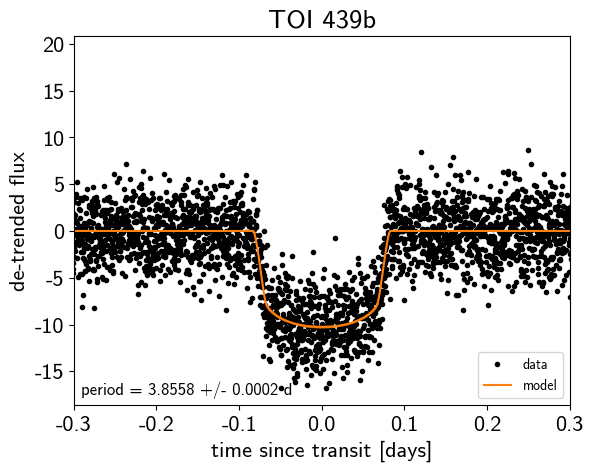

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

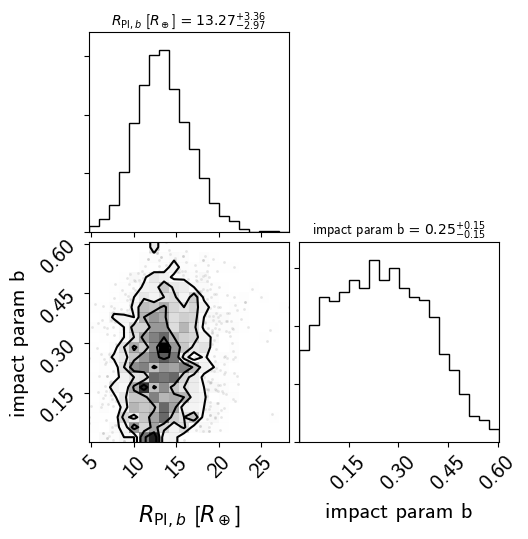

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

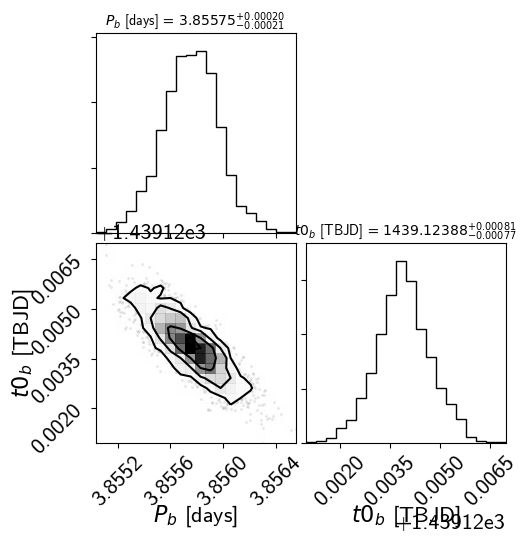

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

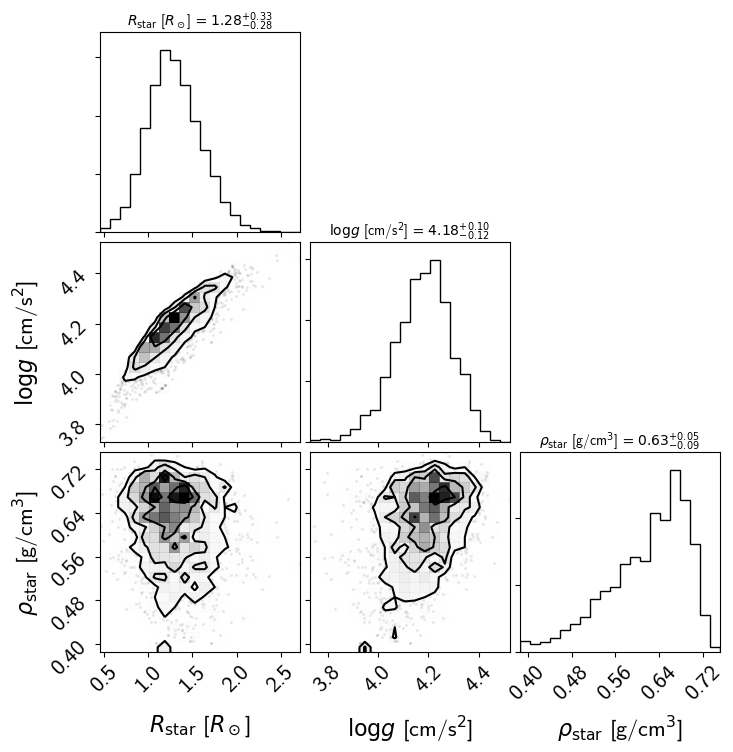

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3